# Clasificador de Imagenes

En esta notebook realizamos un clasificador de images para el Obligatorio de Machine Learning en produccion

## Importacion de librerias y conexion con S3

In [1]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.2 MB/s eta 0:00:00


In [2]:
!pip install torchinfo

In [3]:
import boto3
import pandas as pd
import io
from io import StringIO
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import multiprocessing
import os

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode
from torchinfo import summary

from utils import (
    train,
    model_calassification_report,
    show_tensor_image,
    show_tensor_images,
    evaluate,
    plot_taining,
)


In [4]:
!pip install wandb

In [5]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: valeriaeskenazi (valeriaeskenazi-universidad-ort-uruguay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 23

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
multiprocessing.cpu_count()

2

In [5]:
# Algunas constantes

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

print(f"Usando {DEVICE}")

NUM_WORKERS = max(os.cpu_count() - 1, 1)  # número de workers para cargar los datos
BATCH_SIZE = 32  # tamaño del batch

print(f"Device: {DEVICE}")
print(f"Num Workers: {NUM_WORKERS}")

Usando cuda
Device: cuda
Num Workers: 1


## Configuracion de Credenciales

In [ ]:
aws_access_key_id = ''
aws_secret_access_key = ''
aws_session_token = ''

session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    aws_session_token=aws_session_token
)
s3 = session.client('s3')


## Analisis Exploratorio

En este apartado se realiza el anailisi exploratorio comenzando con:

* evaluacion sobre el tamaño de las imagenes
* El balance entre clases

### Leer Datos desde S3

In [11]:
bucket_name = '1000-imagenes-scrapper-obligatorio-ml'
csv_key = 'scraped_data/results/etiquetas_octogonos.csv'

csv_obj = s3.get_object(Bucket=bucket_name, Key=csv_key)
csv_data = csv_obj['Body'].read().decode('utf-8')


df = pd.read_csv(StringIO(csv_data))
print(df.head())


                                        image         label
0  data/scraped_data/images/201109/201109.jpg  sin_octogono
1  data/scraped_data/images/210208/210208.jpg  sin_octogono
2  data/scraped_data/images/211683/211683.jpg  sin_octogono
3  data/scraped_data/images/211684/211684.jpg  sin_octogono
4  data/scraped_data/images/220350/220350.jpg  con_octogono


### Distribucion de clases

In [10]:
print("Primeras filas:")
print(df.head())

print("\nInfo general:")
print(df.info())

print("\nDistribución de clases:")
print(df['label'].value_counts())

print("\nCantidad total de imágenes:", len(df))
print("\nCantidad de rutas únicas:", df['image'].nunique())


Primeras filas:
                                        image         label
0  data/scraped_data/images/201109/201109.jpg  sin_octogono
1  data/scraped_data/images/210208/210208.jpg  sin_octogono
2  data/scraped_data/images/211683/211683.jpg  sin_octogono
3  data/scraped_data/images/211684/211684.jpg  sin_octogono
4  data/scraped_data/images/220350/220350.jpg  con_octogono

Info general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   777 non-null    object
 1   label   777 non-null    object
dtypes: object(2)
memory usage: 12.3+ KB
None

Distribución de clases:
label
sin_octogono    615
con_octogono    162
Name: count, dtype: int64

Cantidad total de imágenes: 777

Cantidad de rutas únicas: 777


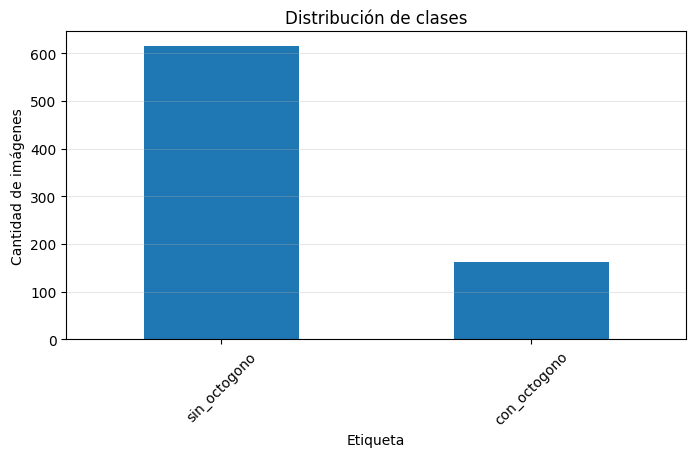

In [ ]:
conteo_clases = df['label'].value_counts()


plt.figure(figsize=(8,4))
conteo_clases.plot(kind='bar', rot=45)
plt.title('Distribución de clases')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de imágenes')
plt.grid(axis='y', alpha=0.3)
plt.show()

### Visualizacion randomica

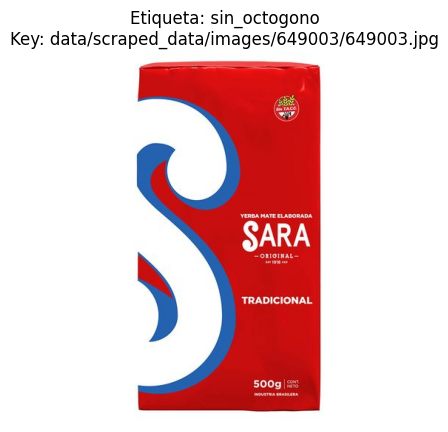

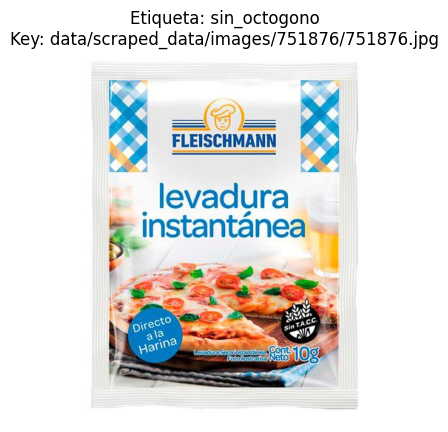

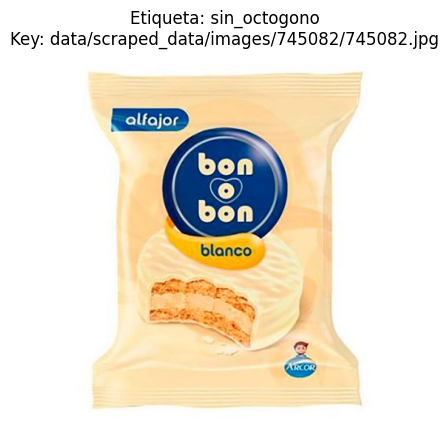

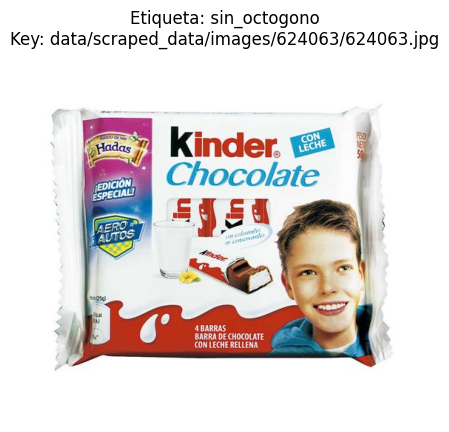

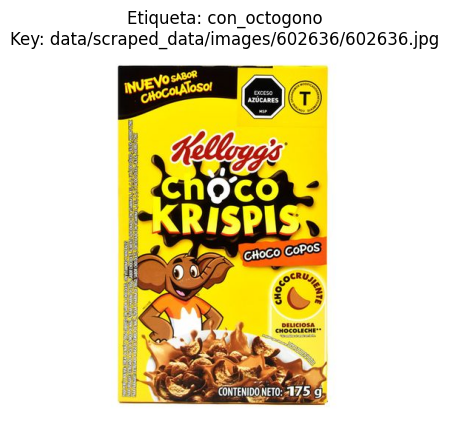

In [ ]:
# N imágenes aleatorias del dataframe
N = 5
muestras = df.sample(N)

for i, row in muestras.iterrows():
    img_key = row['image']
    etiqueta = row['label']
    obj = s3.get_object(Bucket=bucket_name, Key=img_key)
    img_bytes = obj['Body'].read()
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
    plt.figure()
    plt.imshow(img)
    plt.title(f"Etiqueta: {etiqueta}\nKey: {img_key}")
    plt.axis('off')
    plt.show()


### Distribucion de los tamaños

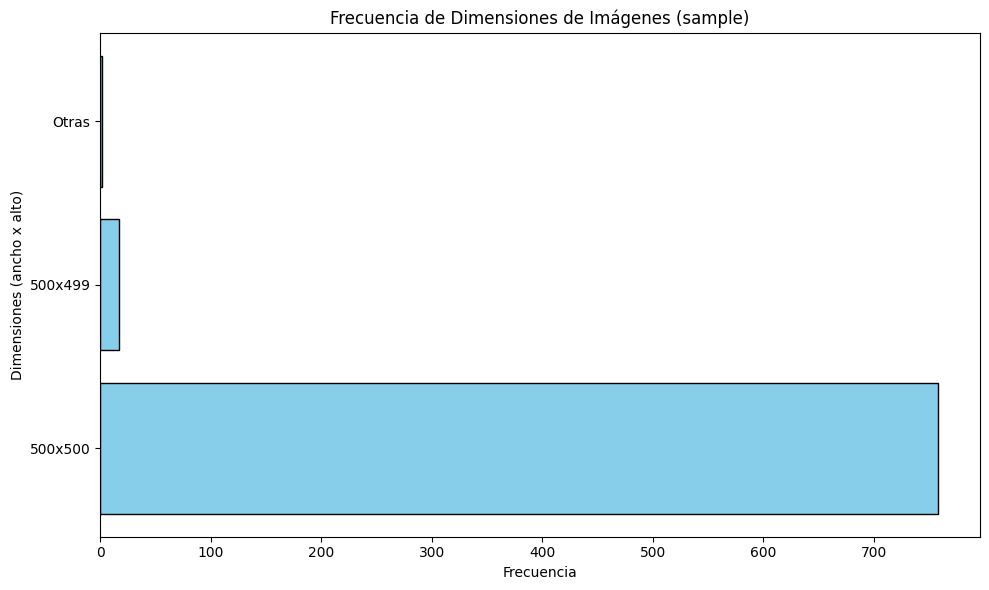

In [ ]:
muestra = df.sample(777) if len(df) > 777 else df

sizes = []

for _, row in muestra.iterrows():
    img_key = row['image']
    try:
        obj = s3.get_object(Bucket=bucket_name, Key=img_key)
        img_bytes = obj['Body'].read()
        img = Image.open(io.BytesIO(img_bytes))
        # Guardar como tupla (ancho, alto)
        sizes.append(img.size)
    except Exception as e:
        pass

# Contar dimensiones
size_counts = Counter(sizes)

# Agrupar tamaños con pocas ocurrencias como "Otras"
grouped_size_counts = {'Otras': 0}
filtered_size_counts = {}

for k, v in size_counts.items():
    if v < 5:  # umbral configurable
        grouped_size_counts['Otras'] += v
    else:
        filtered_size_counts[k] = v

filtered_size_counts.update(grouped_size_counts)

# Convertí a etiquetas tipo "500x500"
size_labels = [f"{size[0]}x{size[1]}" if size != 'Otras' else 'Otras' for size in filtered_size_counts.keys()]
size_frequencies = list(filtered_size_counts.values())

# Gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(size_labels, size_frequencies, color='skyblue', edgecolor='black')
plt.title('Frecuencia de Dimensiones de Imágenes (sample)')
plt.ylabel('Dimensiones (ancho x alto)')
plt.xlabel('Frecuencia')
plt.tight_layout()
plt.show()




## Modelo

In [14]:
BATCH_SIZE=32

### Modelo 1 - LeNet - Imagenes de 500x500

In [15]:
class LeNet_1(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LeNet_1, self).__init__()
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        # Para imágenes de 500x500:
        self.f6 = nn.Linear(in_features=120*118*118, out_features=84)
        self.output = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.tanh(self.c1(x))
        x = self.s2(x)
        x = F.tanh(self.c3(x))
        x = self.s4(x)
        x = F.tanh(self.c5(x))
        x = x.flatten(start_dim=1)
        x = F.tanh(self.f6(x))
        x = self.output(x)
        return x

summary(LeNet_1(3, 2), input_size=(BATCH_SIZE, 3, 500, 500))


Layer (type:depth-idx)                   Output Shape              Param #
LeNet_1                                  [32, 2]                   --
├─Conv2d: 1-1                            [32, 6, 496, 496]         456
├─AvgPool2d: 1-2                         [32, 6, 248, 248]         --
├─Conv2d: 1-3                            [32, 16, 244, 244]        2,416
├─AvgPool2d: 1-4                         [32, 16, 122, 122]        --
├─Conv2d: 1-5                            [32, 120, 118, 118]       48,120
├─Linear: 1-6                            [32, 84]                  140,354,004
├─Linear: 1-7                            [32, 2]                   170
Total params: 140,405,166
Trainable params: 140,405,166
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 34.12
Input size (MB): 96.00
Forward/backward pass size (MB): 1049.51
Params size (MB): 561.62
Estimated Total Size (MB): 1707.13

### Modelo 2 - LeNet - Imagenes de 256x256

In [16]:
class LeNet_2(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LeNet_2, self).__init__()
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)     # -> (6, 252, 252)
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)                                  # -> (6, 126, 126)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)               # -> (16, 122, 122)
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)                                  # -> (16, 61, 61)
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)             # -> (120, 57, 57)

        self.f6 = nn.Linear(in_features=120*57*57, out_features=84)
        self.output = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.tanh(self.c1(x))
        x = self.s2(x)
        x = F.tanh(self.c3(x))
        x = self.s4(x)
        x = F.tanh(self.c5(x))
        x = x.flatten(start_dim=1)
        x = F.tanh(self.f6(x))
        x = self.output(x)
        return x


summary(LeNet_2(3, 2), input_size=(BATCH_SIZE, 3, 256, 256))


Layer (type:depth-idx)                   Output Shape              Param #
LeNet_2                                  [32, 2]                   --
├─Conv2d: 1-1                            [32, 6, 252, 252]         456
├─AvgPool2d: 1-2                         [32, 6, 126, 126]         --
├─Conv2d: 1-3                            [32, 16, 122, 122]        2,416
├─AvgPool2d: 1-4                         [32, 16, 61, 61]          --
├─Conv2d: 1-5                            [32, 120, 57, 57]         48,120
├─Linear: 1-6                            [32, 84]                  32,750,004
├─Linear: 1-7                            [32, 2]                   170
Total params: 32,801,166
Trainable params: 32,801,166
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 8.13
Input size (MB): 25.17
Forward/backward pass size (MB): 258.34
Params size (MB): 131.20
Estimated Total Size (MB): 414.71

### Modelo 3 - ResNet18 - AdaptiveAvgPool2d

In [17]:
import torch
import torch.nn as nn

class ResNet18_3(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet18_3, self).__init__()
        self.relu = nn.ReLU()

        # BLOCK 1 (Input: cualquier tamaño, es adaptativo)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # BLOCK 2 (2 x Conv3x3, skip connection)
        self.conv2_1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # BLOCK 3 (stride 2 → downsampling, skip connection with adjust)
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.adjust3 = nn.Conv2d(64, 128, kernel_size=1, stride=2)

        # BLOCK 4 (igual que BLOCK 3)
        self.conv4_1 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.adjust4 = nn.Conv2d(128, 256, kernel_size=1, stride=2)

        # BLOCK 5
        self.conv5_1 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.adjust5 = nn.Conv2d(256, 512, kernel_size=1, stride=2)

        # Pool & classifier
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool1(x)

        # Block 2
        residual = x
        x = self.relu(self.conv2_1(x))
        x = self.conv2_2(x)
        x = self.relu(x + residual)

        # Block 3
        residual = self.adjust3(x)
        x = self.relu(self.conv3_1(x))
        x = self.conv3_2(x)
        x = self.relu(x + residual)

        # Block 4
        residual = self.adjust4(x)
        x = self.relu(self.conv4_1(x))
        x = self.conv4_2(x)
        x = self.relu(x + residual)

        # Block 5
        residual = self.adjust5(x)
        x = self.relu(self.conv5_1(x))
        x = self.conv5_2(x)
        x = self.relu(x + residual)

        # Pool & FC
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

summary(ResNet18_3(3, 2), input_size=(BATCH_SIZE, 3, 500, 500))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18_3                               [32, 2]                   --
├─Conv2d: 1-1                            [32, 64, 250, 250]        9,472
├─ReLU: 1-2                              [32, 64, 250, 250]        --
├─MaxPool2d: 1-3                         [32, 64, 125, 125]        --
├─Conv2d: 1-4                            [32, 64, 125, 125]        36,928
├─ReLU: 1-5                              [32, 64, 125, 125]        --
├─Conv2d: 1-6                            [32, 64, 125, 125]        36,928
├─ReLU: 1-7                              [32, 64, 125, 125]        --
├─Conv2d: 1-8                            [32, 128, 63, 63]         8,320
├─Conv2d: 1-9                            [32, 128, 63, 63]         73,856
├─ReLU: 1-10                             [32, 128, 63, 63]         --
├─Conv2d: 1-11                           [32, 128, 63, 63]         147,584
├─ReLU: 1-12                             [32, 128, 63, 63]    

### Modelo 4 - ResNet - Adaptativo - Regularizacion

In [18]:
class ResNet18_4(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(ResNet18_4, self).__init__()

        self.dropout_percentage_1_2 = 0.1
        self.dropout_percentage_3_4 = 0.2
        self.dropout_percentage_5 = 0.3
        self.relu = nn.ReLU()

        # BLOCK-1 (starting block) input=(256x256) output=(64x64)
        self.conv1 = nn.Conv2d(in_channels, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))

        # BLOCK-2 (1) input=(64x64) output = (64x64)
        self.conv2_1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_1 = nn.BatchNorm2d(64)
        self.conv2_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_2 = nn.BatchNorm2d(64)
        self.dropout2_1 = nn.Dropout(p=self.dropout_percentage_1_2)
        # BLOCK-2 (2)
        self.conv2_2_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_1 = nn.BatchNorm2d(64)
        self.conv2_2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_2 = nn.BatchNorm2d(64)
        self.dropout2_2 = nn.Dropout(p=self.dropout_percentage_1_2)

        # BLOCK-3 (1) input=(64x64) output = (32x32)
        self.conv3_1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm3_1_1 = nn.BatchNorm2d(128)
        self.conv3_1_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_1_2 = nn.BatchNorm2d(128)
        self.concat_adjust_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout3_1 = nn.Dropout(p=self.dropout_percentage_3_4)
        # BLOCK-3 (2)
        self.conv3_2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_1 = nn.BatchNorm2d(128)
        self.conv3_2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_2 = nn.BatchNorm2d(128)
        self.dropout3_2 = nn.Dropout(p=self.dropout_percentage_3_4)

        # BLOCK-4 (1) input=(32x32) output = (16x16)
        self.conv4_1_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm4_1_1 = nn.BatchNorm2d(256)
        self.conv4_1_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_1_2 = nn.BatchNorm2d(256)
        self.concat_adjust_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout4_1 = nn.Dropout(p=self.dropout_percentage_3_4)
        # BLOCK-4 (2)
        self.conv4_2_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_1 = nn.BatchNorm2d(256)
        self.conv4_2_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_2 = nn.BatchNorm2d(256)
        self.dropout4_2 = nn.Dropout(p=self.dropout_percentage_3_4)

        # BLOCK-5 (1) input=(16x16) output = (8x8)
        self.conv5_1_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm5_1_1 = nn.BatchNorm2d(512)
        self.conv5_1_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_1_2 = nn.BatchNorm2d(512)
        self.concat_adjust_5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout5_1 = nn.Dropout(p=self.dropout_percentage_5)
        # BLOCK-5 (2)
        self.conv5_2_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_1 = nn.BatchNorm2d(512)
        self.conv5_2_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_2 = nn.BatchNorm2d(512)
        self.dropout5_2 = nn.Dropout(p=self.dropout_percentage_5)

        # Final Block input=(8x8)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(in_features=1*1*512, out_features=1000)
        self.dropout_fc = nn.Dropout(p=0.5)
        self.out = nn.Linear(in_features=1000, out_features=n_classes)
        # END

    def forward(self, x):

        # block 1 --> Starting block
        x = self.relu(self.batchnorm1(self.conv1(x)))
        op1 = self.maxpool1(x)


        # block2 - 1
        x = self.relu(self.batchnorm2_1_1(self.conv2_1_1(op1)))    # conv2_1
        x = self.batchnorm2_1_2(self.conv2_1_2(x))                 # conv2_1
        x = self.dropout2_1(x)
        # block2 - Adjust - No adjust in this layer as dimensions are already same
        # block2 - Concatenate 1
        op2_1 = self.relu(x + op1)
        # block2 - 2
        x = self.relu(self.batchnorm2_2_1(self.conv2_2_1(op2_1)))  # conv2_2
        x = self.batchnorm2_2_2(self.conv2_2_2(x))                 # conv2_2
        x = self.dropout2_2(x)
        # op - block2
        op2 = self.relu(x + op2_1)


        # block3 - 1[Convolution block]
        x = self.relu(self.batchnorm3_1_1(self.conv3_1_1(op2)))    # conv3_1
        x = self.batchnorm3_1_2(self.conv3_1_2(x))                 # conv3_1
        x = self.dropout3_1(x)
        # block3 - Adjust
        op2 = self.concat_adjust_3(op2) # SKIP CONNECTION
        # block3 - Concatenate 1
        op3_1 = self.relu(x + op2)
        # block3 - 2[Identity Block]
        x = self.relu(self.batchnorm3_2_1(self.conv3_2_1(op3_1)))  # conv3_2
        x = self.batchnorm3_2_2(self.conv3_2_2(x))                 # conv3_2
        x = self.dropout3_2(x)
        # op - block3
        op3 = self.relu(x + op3_1)


        # block4 - 1[Convolution block]
        x = self.relu(self.batchnorm4_1_1(self.conv4_1_1(op3)))    # conv4_1
        x = self.batchnorm4_1_2(self.conv4_1_2(x))                 # conv4_1
        x = self.dropout4_1(x)
        # block4 - Adjust
        op3 = self.concat_adjust_4(op3) # SKIP CONNECTION
        # block4 - Concatenate 1
        op4_1 = self.relu(x + op3)
        # block4 - 2[Identity Block]
        x = self.relu(self.batchnorm4_2_1(self.conv4_2_1(op4_1)))  # conv4_2
        x = self.batchnorm4_2_2(self.conv4_2_2(x))                 # conv4_2
        x = self.dropout4_2(x)
        # op - block4
        op4 = self.relu(x + op4_1)


        # block5 - 1[Convolution Block]
        x = self.relu(self.batchnorm5_1_1(self.conv5_1_1(op4)))    # conv5_1
        x = self.batchnorm5_1_2(self.conv5_1_2(x))                 # conv5_1
        x = self.dropout5_1(x)
        # block5 - Adjust
        op4 = self.concat_adjust_5(op4) # SKIP CONNECTION
        # block5 - Concatenate 1
        op5_1 = self.relu(x + op4)
        # block5 - 2[Identity Block]
        x = self.relu(self.batchnorm5_2_1(self.conv5_2_1(op5_1)))  # conv5_2
        x = self.batchnorm5_2_2(self.conv5_2_2(x))                 # conv5_2
        x = self.dropout5_2(x)
        # op - block5
        op5 = self.relu(x + op5_1)


        # FINAL BLOCK - classifier
        x = self.avgpool(op5)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc(x))
        x = self.dropout_fc(x)
        x = self.out(x)

        return x

summary(ResNet18_4(3, 2), input_size=(BATCH_SIZE, 3, 500, 500))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18_4                               [32, 2]                   --
├─Conv2d: 1-1                            [32, 64, 250, 250]        9,472
├─BatchNorm2d: 1-2                       [32, 64, 250, 250]        128
├─ReLU: 1-3                              [32, 64, 250, 250]        --
├─MaxPool2d: 1-4                         [32, 64, 125, 125]        --
├─Conv2d: 1-5                            [32, 64, 125, 125]        36,928
├─BatchNorm2d: 1-6                       [32, 64, 125, 125]        128
├─ReLU: 1-7                              [32, 64, 125, 125]        --
├─Conv2d: 1-8                            [32, 64, 125, 125]        36,928
├─BatchNorm2d: 1-9                       [32, 64, 125, 125]        128
├─Dropout: 1-10                          [32, 64, 125, 125]        --
├─ReLU: 1-11                             [32, 64, 125, 125]        --
├─Conv2d: 1-12                           [32, 64, 125, 125]        36,9

## Wights and biase

Se utiliza la herramienta Weights and biase, desde la busqueda del mejor modelo como el ajuste de sus hiperparametros, asi como para mentener la trazabilidad de los experimentos.

### EXPERIMENTO 1 - Sin Data Augmentation

En este apartado se busca comparar el comportamiento de los modelos propuestos sin Data agumentation

#### Dataset, dataloader y Transformaciones

In [ ]:
class S3ImageDataset_EX1(Dataset):
    def __init__(self, df, bucket_name, s3_client, transform=None):
        self.df = df.reset_index(drop=True)
        self.bucket = bucket_name
        self.s3 = s3_client
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_key = self.df.iloc[idx]['image']
        label = self.df.iloc[idx]['label']

        # Leer imagen desde S3
        obj = self.s3.get_object(Bucket=self.bucket, Key=img_key)
        img_bytes = obj['Body'].read()
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # Clasificación binaria: convertir a 0 (sin_octogonos) o 1 (con_octogonos)
        if isinstance(label, str):
            label = 1 if label.strip().lower() == "con_octogono" else 0

        return img, label

In [ ]:
def get_data_loaders_EX1(train_df, val_df, test_df, train_transf, test_transf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):

  #Segundo: Realizar las transformadas sobre los sub dataset
  dataset_train = S3ImageDataset_EX1(train_df, bucket_name, s3, transform=train_transf)
  dataset_val = S3ImageDataset_EX1(val_df, bucket_name, s3, transform=test_transf)
  dataset_test = S3ImageDataset_EX1(test_df, bucket_name, s3, transform=test_transf)

  #Tercero: Crear los dataloaders
  train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
  val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
  test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

  return train_loader, val_loader, test_loader

In [ ]:
def calculate_class_weights(dataset):
    """Calcula los pesos de clase para un dataset desbalanceado."""
    class_counts = Counter([label for _, label in dataset])
    total_samples = len(dataset)
    num_classes = len(class_counts)
    class_weights = [
        total_samples / (count * num_classes) for count in class_counts.values()
    ]
    return class_weights

In [ ]:
transforms_1 = T.Compose(
    [
        T.Resize((500, 500)),
        T.ToTensor(),
    ]
)

transforms_2 = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


#### W&B - Imagenes 500x500

In [ ]:
WANDB_TEAM_NAME = "valeriaeskenazi-universidad-ort-uruguay"
WANDB_PROJECT = "Obligatorio-ML-en-produccion"

# La configuración del sweep: los parámetros que queremos optimizar
sweep_config = {
    "name": "experimento_1_500x500",
    "method": "grid", #puede haber tres variantes, se puede ir probando para ver cual es el mejor:
    #grid search: todas las opciones
    #busqueda: ver tipo de correlaciones y le mete mas al que le parezca
    #random: el mas recomendable
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "model": {"values": ["lenet_model_1", "resnet_model_3", "resnet_model_4"]},
    },
}

# Crea un nuevo sweep (podríamos usar un sweep existente si ya lo hubiéramos creado)
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: hw56xbqg
Sweep URL: https://wandb.ai/valeriaeskenazi-universidad-ort-uruguay/Obligatorio-ML-en-produccion/sweeps/hw56xbqg


In [ ]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()

    # leer la configuración del run
    config = wandb.config
    run_model = config.model

    if run_model == "lenet_model_1":
        model = LeNet_1(3, 2).to(DEVICE)
        train_loader, valid_loader, test_loader = get_data_loaders_EX1(train_df, val_df, test_df, transforms_1, transforms_1, batch_size=BATCH_SIZE)
    elif run_model == "resnet_model_3":
        model = ResNet18_3(3, 2).to(DEVICE)
        train_loader, valid_loader, test_loader = get_data_loaders_EX1(train_df, val_df, test_df, transforms_1, transforms_1, batch_size=BATCH_SIZE)
    elif run_model == "resnet_model_4":
        model = ResNet18_4(3, 2).to(DEVICE)
        train_loader, valid_loader, test_loader = get_data_loaders_EX1(train_df, val_df, test_df, transforms_1, transforms_1, batch_size=BATCH_SIZE)
    else:
        raise ValueError(f"Modelo '{run_model}' no válido para dimensión 500x500")

    optimizer = optim.Adam(model.parameters(), lr=LR)
    CRITERION = nn.CrossEntropyLoss(weight=weights).to(DEVICE)
    train_errors_ln_nda, val_errors_ln_nda=train(
            model=model,
            optimizer=optimizer,
            criterion=CRITERION,
            train_loader=train_loader,
            val_loader=valid_loader,
            device=DEVICE,
            do_early_stopping=True,
            patience=5,
            epochs=EPOCHS,
            log_fn=wand_log,
            log_every=1,
        )
    plot_taining(train_errors_ln_nda, val_errors_ln_nda)
    model_calassification_report(model, test_loader, DEVICE, 2)


    # Guardar el modelo al final
    torch.save(model.state_dict(), f"Experimento1_500x500_{wandb.run.name}.pth")
    wandb.save(f"Experimento1_500x500_{wandb.run.name}.pth")
    wandb.finish()


In [19]:
  #Primero: dividir el dataset
  train_df, intermedio_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=SEED)
  val_df, test_df = train_test_split(intermedio_df, test_size=0.5, stratify=intermedio_df['label'], random_state=SEED)

In [20]:
class_counts = train_df['label'].value_counts().sort_index()  # Ordenar por índice de clase
total_samples = len(train_df)

# Calcular pesos: total_samples / (num_classes * count_per_class)
class_weights = total_samples / (len(class_counts) * class_counts)

# O más simple: peso inverso
class_weights = 1.0 / class_counts

weights = torch.tensor(class_weights.values, dtype=torch.float).to(DEVICE)


In [21]:
LR = 0.001
EPOCHS = 8
BATCH_SIZE=32

wandb: Agent Starting Run: b5tqzsl1 with config:
wandb: 	model: lenet_model_1


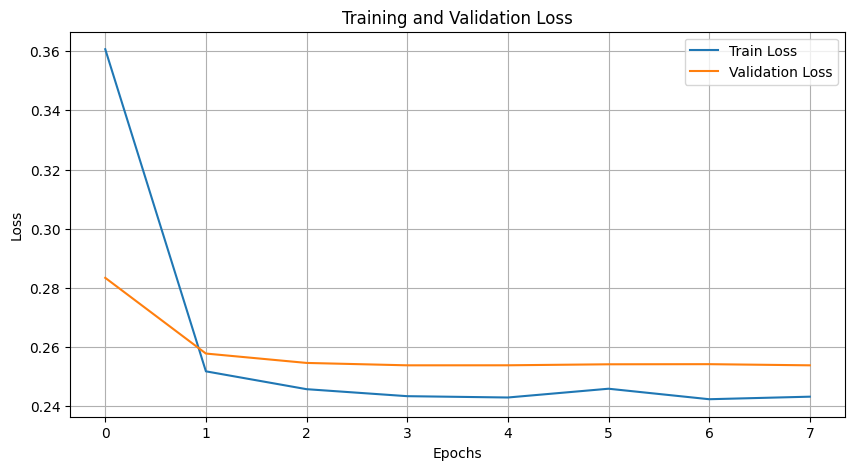

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: ombvbgmd with config:
wandb: 	model: resnet_model_3


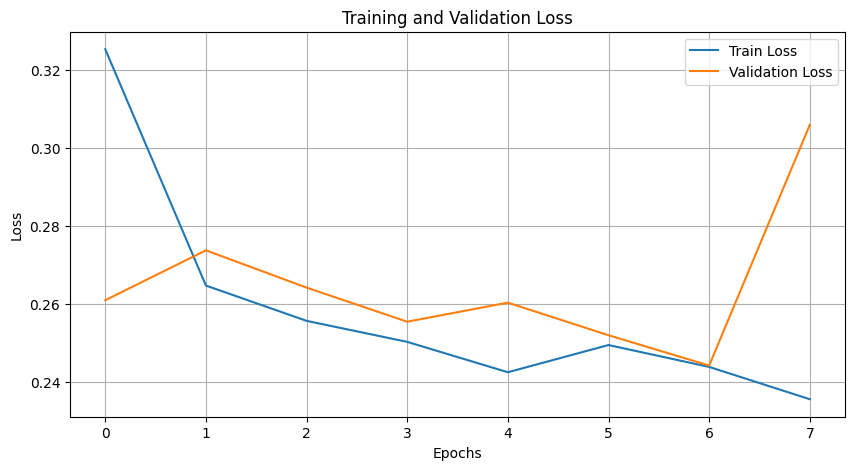

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 7n54uta2 with config:
wandb: 	model: resnet_model_4


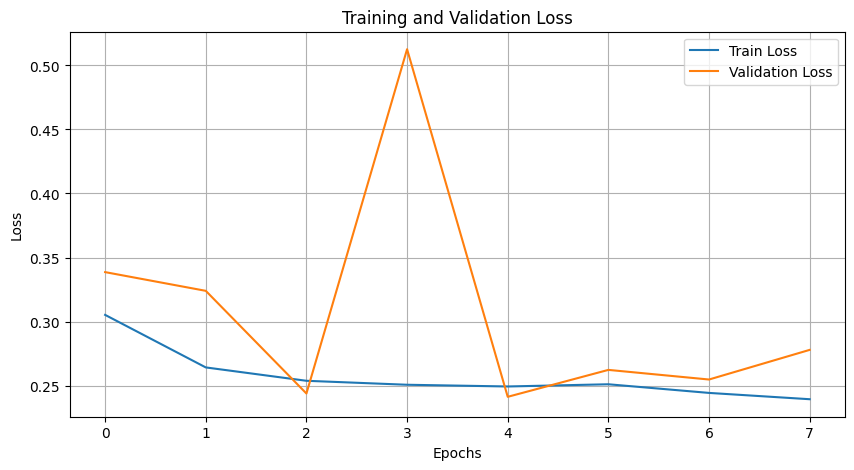

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
wandb.agent(sweep_id, function=sweep_run)

#### W&B - Imagenes 256x256

In [ ]:
WANDB_TEAM_NAME = "valeriaeskenazi-universidad-ort-uruguay"
WANDB_PROJECT = "Obligatorio-ML-en-produccion"

# La configuración del sweep: los parámetros que queremos optimizar
sweep_config = {
    "name": "experimento_1_256x256",
    "method": "grid", #puede haber tres variantes, se puede ir probando para ver cual es el mejor:
    #grid search: todas las opciones
    #busqueda: ver tipo de correlaciones y le mete mas al que le parezca
    #random: el mas recomendable
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "model": {"values": ["lenet_model_2", "resnet_model_3", "resnet_model_4"]},
    },
}

# Crea un nuevo sweep (podríamos usar un sweep existente si ya lo hubiéramos creado)
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: 38rl2ndi
Sweep URL: https://wandb.ai/valeriaeskenazi-universidad-ort-uruguay/Obligatorio-ML-en-produccion/sweeps/38rl2ndi


In [ ]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()

    # leer la configuración del run
    config = wandb.config
    run_model = config.model

    if run_model == "lenet_model_2":
        model = LeNet_2(3, 2).to(DEVICE)
        train_loader, valid_loader, test_loader = get_data_loaders_EX1(train_df, val_df, test_df, transforms_2, transforms_2, batch_size=BATCH_SIZE)
    elif run_model == "resnet_model_3":
        model = ResNet18_3(3, 2).to(DEVICE)
        train_loader, valid_loader, test_loader = get_data_loaders_EX1(train_df, val_df, test_df, transforms_2, transforms_2, batch_size=BATCH_SIZE)
    elif run_model == "resnet_model_4":
        model = ResNet18_4(3, 2).to(DEVICE)
        train_loader, valid_loader, test_loader = get_data_loaders_EX1(train_df, val_df, test_df, transforms_2, transforms_2, batch_size=BATCH_SIZE)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    CRITERION = nn.CrossEntropyLoss(weight=weights).to(DEVICE)
    train_errors_ln_nda, val_errors_ln_nda=train(
            model=model,
            optimizer=optimizer,
            criterion=CRITERION,
            train_loader=train_loader,
            val_loader=valid_loader,
            device=DEVICE,
            do_early_stopping=True,
            patience=5,
            epochs=EPOCHS,
            log_fn=wand_log,
            log_every=1,
        )
    plot_taining(train_errors_ln_nda, val_errors_ln_nda)
    model_calassification_report(model, test_loader, DEVICE, 2)


    # Guardar el modelo al final
    torch.save(model.state_dict(), f"Experimento1_256x256_{wandb.run.name}.pth")
    wandb.save(f"Experimento1_256x256_{wandb.run.name}.pth")
    wandb.finish()


wandb: Agent Starting Run: bgqpw1n6 with config:
wandb: 	model: lenet_model_2


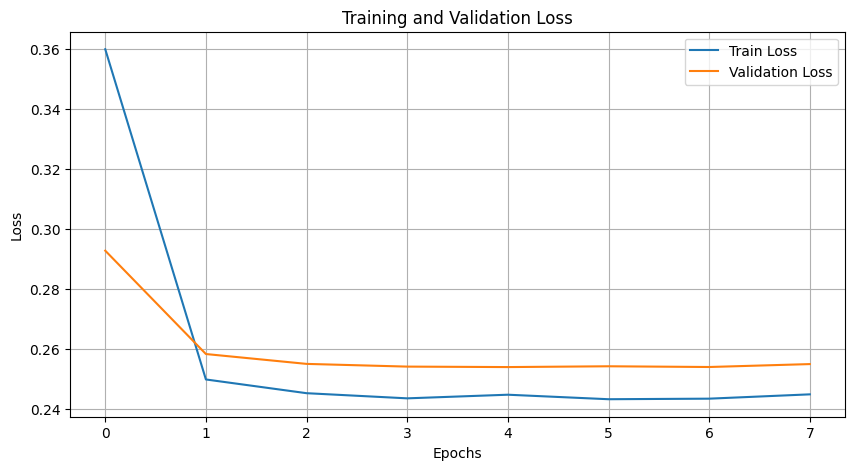

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8wf5xlsb with config:
wandb: 	model: resnet_model_3


Detener entrenamiento en la época 6, la mejor pérdida fue 0.25336


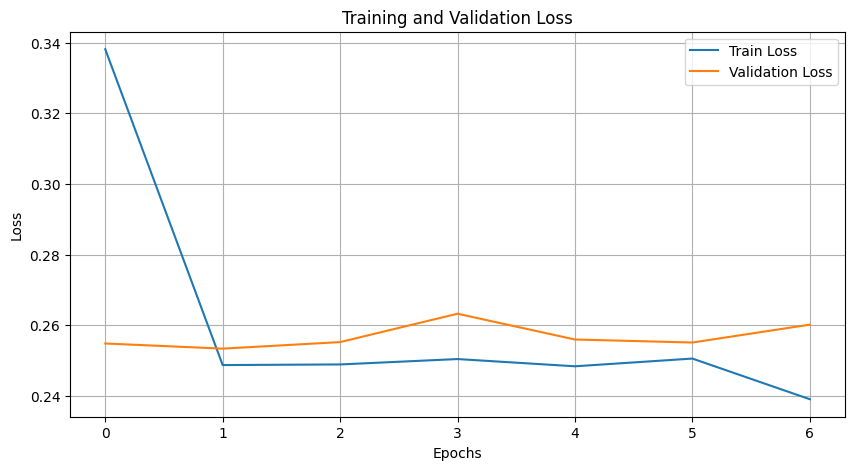

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: k9k6xeat with config:
wandb: 	model: resnet_model_4


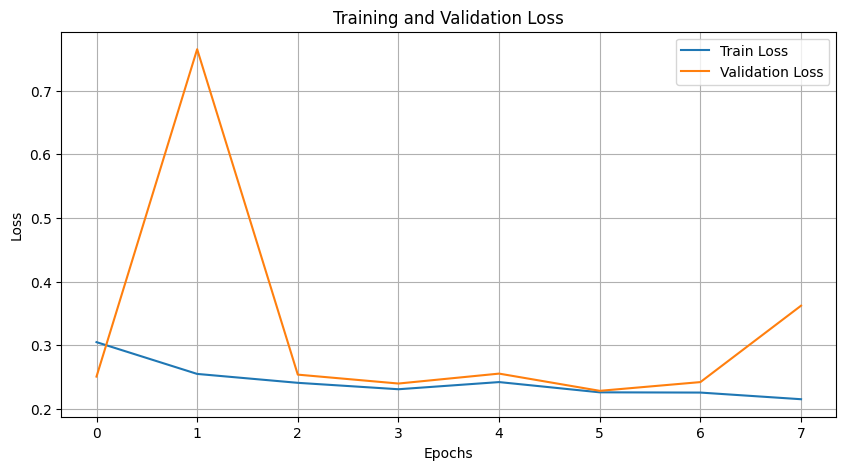

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
wandb.agent(sweep_id, function=sweep_run)

### EXPERIMENTO 2 - Con Data Augmentation

En este apartado se busca comparar el comportamiento de los modelos propuestos con Data agumentation

#### Dataset, dataloader y Transformaciones

In [22]:
class S3ImageDataset_EX2(Dataset):
    def __init__(self, df, bucket_name, s3_client, basic_transform=None, augment_transform=None):
        self.df = df.reset_index(drop=True)
        self.bucket = bucket_name
        self.s3 = s3_client
        self.basic_transform = basic_transform
        self.augment_transform = augment_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_key = self.df.iloc[idx]['image']
        label = self.df.iloc[idx]['label']

        # Leer imagen desde S3
        obj = self.s3.get_object(Bucket=self.bucket, Key=img_key)
        img_bytes = obj['Body'].read()
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')

        # Clasificación binaria: convertir a 0 (sin_octogonos) o 1 (con_octogonos)
        if isinstance(label, str):
            label = 1 if label.strip().lower() == "con_octogono" else 0

        # Aplicar transformaciones según la clase
        if label == 1 and self.augment_transform:  # Clase desbalanceada "con_octogono"
            img = self.augment_transform(img)
        elif self.basic_transform:
            img = self.basic_transform(img)

        return img, label

In [23]:
def get_data_loaders_EX2(train_df, val_df, test_df, basic_transform, augment_transform, test_transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    # Crear datasets con transformaciones diferenciadas
    dataset_train = S3ImageDataset_EX2(
        df=train_df,
        bucket_name=bucket_name,
        s3_client=s3,
        basic_transform=basic_transform,
        augment_transform=augment_transform
    )

    dataset_val = S3ImageDataset_EX2(
        df=val_df,
        bucket_name=bucket_name,
        s3_client=s3,
        basic_transform=test_transform,
        augment_transform=None  # No augmentation en validación
    )

    dataset_test = S3ImageDataset_EX2(
        df=test_df,
        bucket_name=bucket_name,
        s3_client=s3,
        basic_transform=test_transform,
        augment_transform=None  # No augmentation en test
    )

    # Crear DataLoaders
    train_loader = DataLoader(
        dataset=dataset_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    val_loader = DataLoader(
        dataset=dataset_val,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    test_loader = DataLoader(
        dataset=dataset_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    return train_loader, val_loader, test_loader

In [24]:
# IMAGENES DE 500X500
BS_500_1 = T.Compose([
    T.Resize((500, 500)),
    T.ToTensor(),
])

AG_500_1 = T.Compose([
    T.Resize((500, 500)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
])

AG_500_2 = T.Compose([
    T.Resize((500, 500)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ToTensor(),
])

AG_500_3 = T.Compose([
    T.Resize((500, 500)),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
])

AG_500_4 = T.Compose([
    T.Resize((500, 500)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
])

AG_500_5 = T.Compose([
    T.Resize((500, 500)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
])

AG_500_6 = T.Compose([
    T.Resize((500, 500)),
    T.RandomRotation(degrees=15),
    T.ToTensor(),
])

AG_500_7 = T.Compose([
    T.Resize((500, 500)),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
])
# IMAGENES DE 256X256
BS_256 = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

AG_256_1 = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
])

AG_256_2 = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ToTensor(),
])

AG_256_3 = T.Compose([
    T.Resize((256, 256)),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
])

AG_256_4 = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
])

AG_256_5 = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
])

AG_256_6 = T.Compose([
    T.Resize((256, 256)),
    T.RandomRotation(degrees=15),
    T.ToTensor(),
])

AG_256_7 = T.Compose([
    T.Resize((256, 256)),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


#### W&B - imagenes 500x500

In [ ]:
WANDB_TEAM_NAME = "valeriaeskenazi-universidad-ort-uruguay"
WANDB_PROJECT = "Obligatorio-ML-en-produccion"

# La configuración del sweep: los parámetros que queremos optimizar
sweep_config = {
    "name": "experimento_2_500x500",
    "method": "grid", #puede haber tres variantes, se puede ir probando para ver cual es el mejor:
    #grid search: todas las opciones
    #busqueda: ver tipo de correlaciones y le mete mas al que le parezca
    #random: el mas recomendable
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "model": {"values": ["lenet_model_1", "resnet_model_3", "resnet_model_4"]},
        "transforms": {"values": ["AG_500_1", "AG_500_2", "AG_500_3", "AG_500_4", "AG_500_5", "AG_500_6", "AG_500_7"]},
    },
}

# Crea un nuevo sweep (podríamos usar un sweep existente si ya lo hubiéramos creado)
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: 8fo4a1d3
Sweep URL: https://wandb.ai/valeriaeskenazi-universidad-ort-uruguay/Obligatorio-ML-en-produccion/sweeps/8fo4a1d3


In [ ]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()

    # leer la configuración del run
    config = wandb.config
    run_model = config.model
    run_transforms = config.transforms

    if run_model == "lenet_model_1":
        model = LeNet_1(3, 2).to(DEVICE)
        if run_transforms == "AG_500_1":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_1, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_2":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_2, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_3":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_3, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_4":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_4, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_5":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_5, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_6":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_6, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_7":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_7, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    elif run_model == "resnet_model_3":
        model = ResNet18_3(3, 2).to(DEVICE)
        if run_transforms == "AG_500_1":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_1, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_2":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_2, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_3":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_3, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_4":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_4, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_5":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_5, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_6":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_6, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_7":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_7, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    elif run_model == "resnet_model_4":
        model = ResNet18_4(3, 2).to(DEVICE)
        if run_transforms == "AG_500_1":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_1, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_2":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_2, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_3":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_3, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_4":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_4, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_5":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_5, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_6":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_6, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_500_7":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_7, BS_500_1, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)


    optimizer = optim.Adam(model.parameters(), lr=LR)
    CRITERION = nn.CrossEntropyLoss(weight=weights).to(DEVICE)
    train_errors_ln_nda, val_errors_ln_nda =train(
            model=model,
            optimizer=optimizer,
            criterion=CRITERION,
            train_loader=train_loader,
            val_loader=valid_loader,
            device=DEVICE,
            do_early_stopping=True,
            patience=5,
            epochs=EPOCHS,
            log_fn=wand_log,
            log_every=1,
        )
    plot_taining(train_errors_ln_nda, val_errors_ln_nda)
    model_calassification_report(model, test_loader, DEVICE, 2)


    # Guardar el modelo al final
    torch.save(model.state_dict(), f"Experimento2_500x500_{wandb.run.name}.pth")
    wandb.save(f"Experimento2_500x500_{wandb.run.name}.pth")
    wandb.finish()


wandb: Agent Starting Run: vr74ig2l with config:
wandb: 	model: lenet_model_1
wandb: 	transforms: AG_500_1


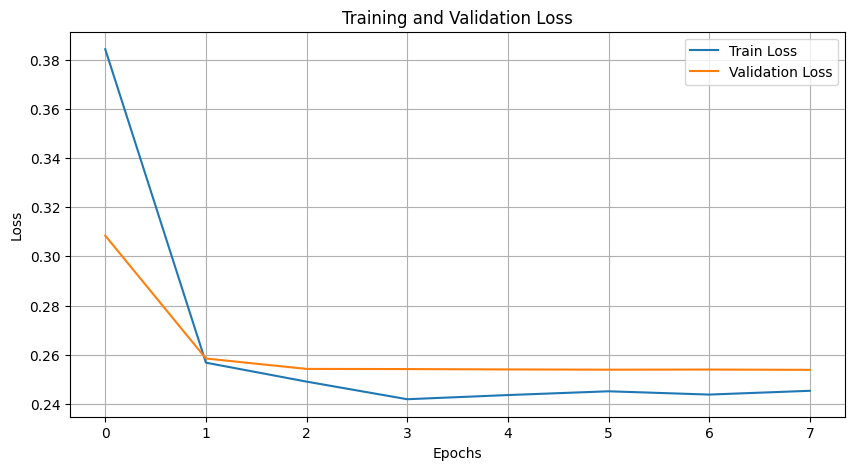

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 2zjziw8i with config:
wandb: 	model: lenet_model_1
wandb: 	transforms: AG_500_2


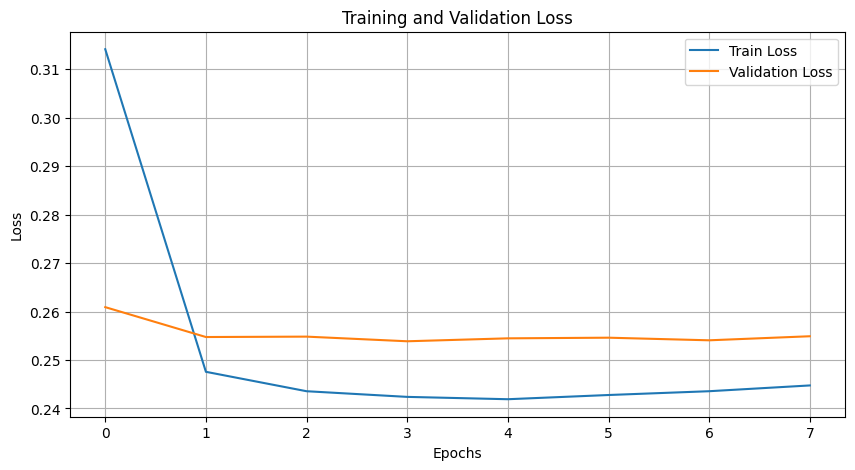

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: wt5nz99t with config:
wandb: 	model: lenet_model_1
wandb: 	transforms: AG_500_3


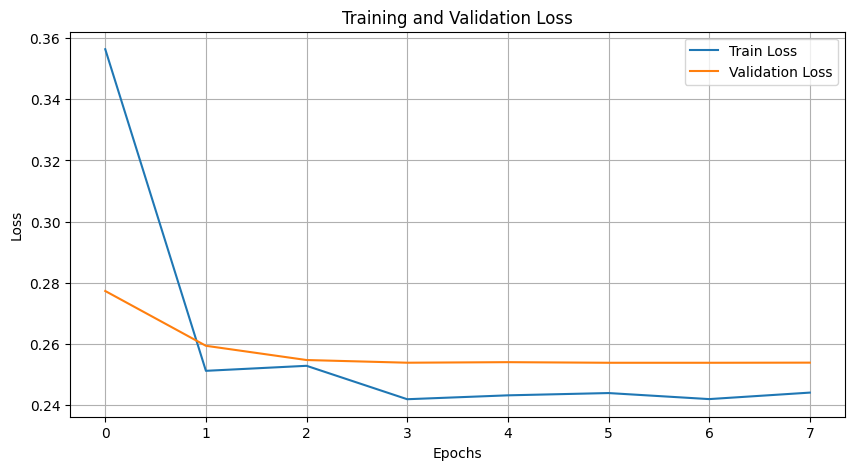

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 9qvxnex9 with config:
wandb: 	model: lenet_model_1
wandb: 	transforms: AG_500_4


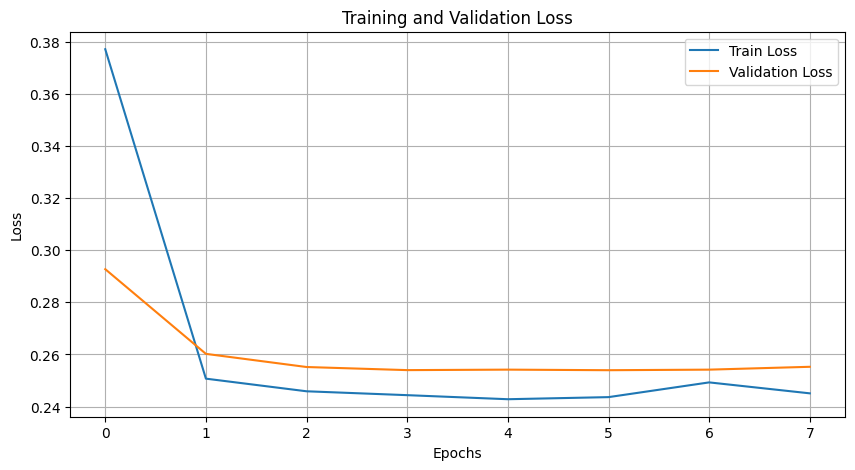

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: go1fwylw with config:
wandb: 	model: lenet_model_1
wandb: 	transforms: AG_500_5


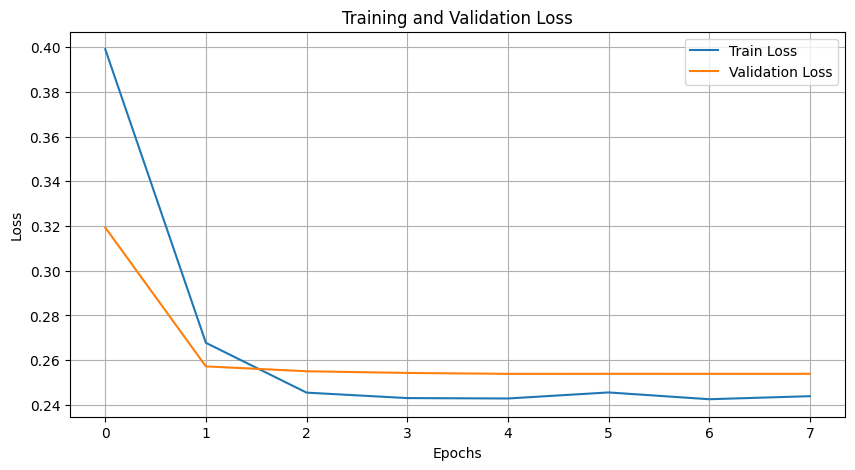

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: zcb7darr with config:
wandb: 	model: lenet_model_1
wandb: 	transforms: AG_500_6


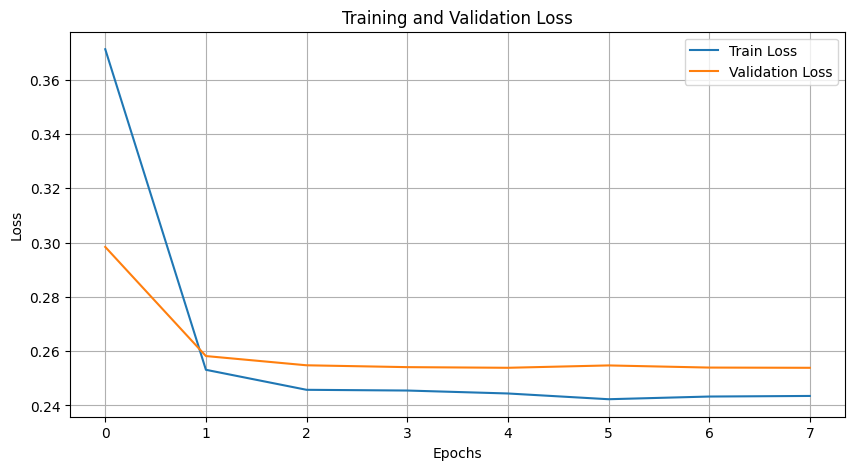

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 9oti9uy0 with config:
wandb: 	model: lenet_model_1
wandb: 	transforms: AG_500_7


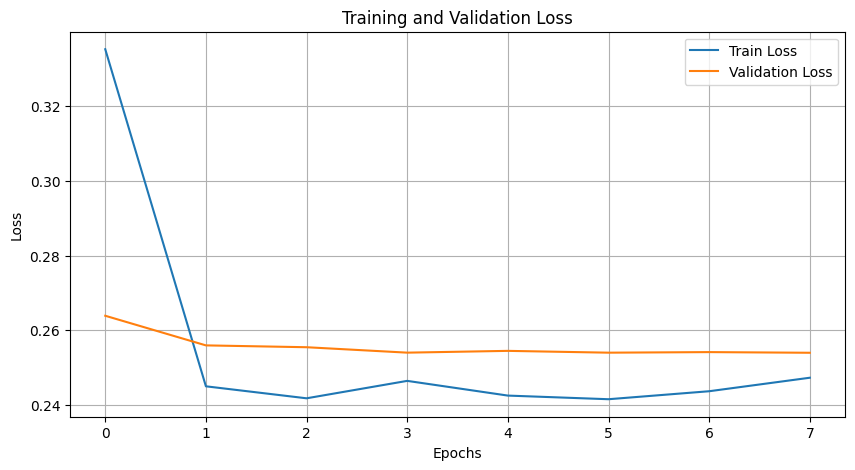

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: dxab1wiy with config:
wandb: 	model: resnet_model_3
wandb: 	transforms: AG_500_1


Detener entrenamiento en la época 5, la mejor pérdida fue 0.25748


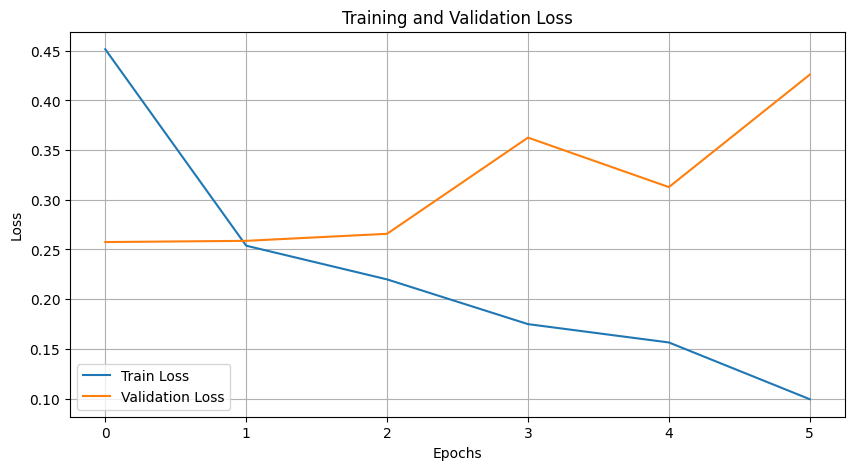

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 8cah4waa with config:
wandb: 	model: resnet_model_3
wandb: 	transforms: AG_500_2


Detener entrenamiento en la época 6, la mejor pérdida fue 0.26017


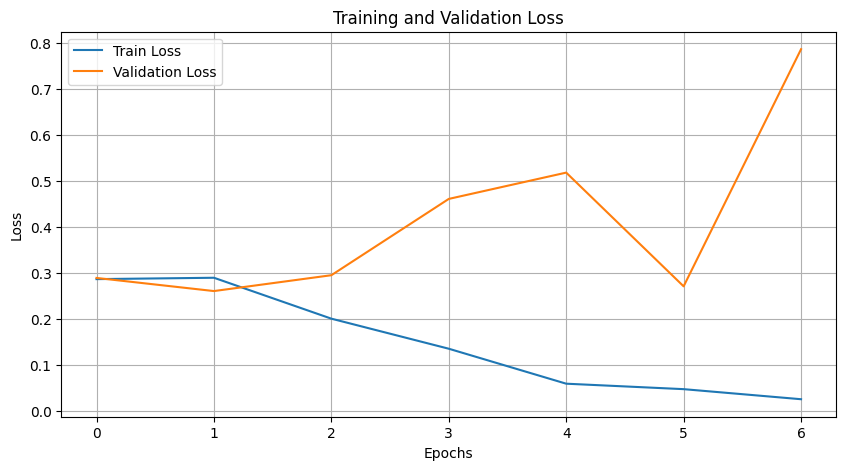

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 46z3jdwp with config:
wandb: 	model: resnet_model_3
wandb: 	transforms: AG_500_3


Detener entrenamiento en la época 5, la mejor pérdida fue 0.26247


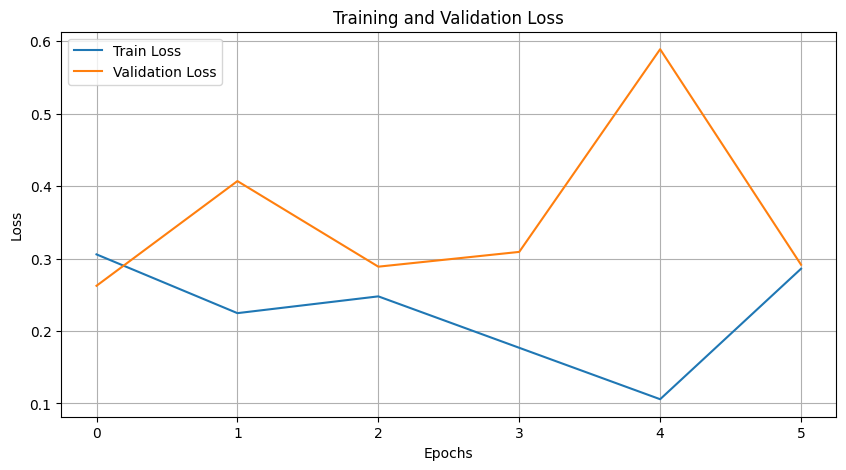

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: ar7k9jef with config:
wandb: 	model: resnet_model_3
wandb: 	transforms: AG_500_4


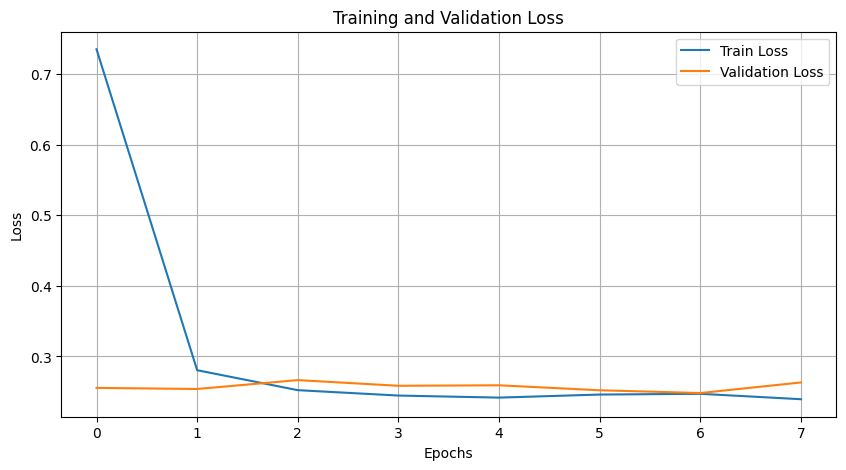

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 2pwwmvi4 with config:
wandb: 	model: resnet_model_3
wandb: 	transforms: AG_500_5


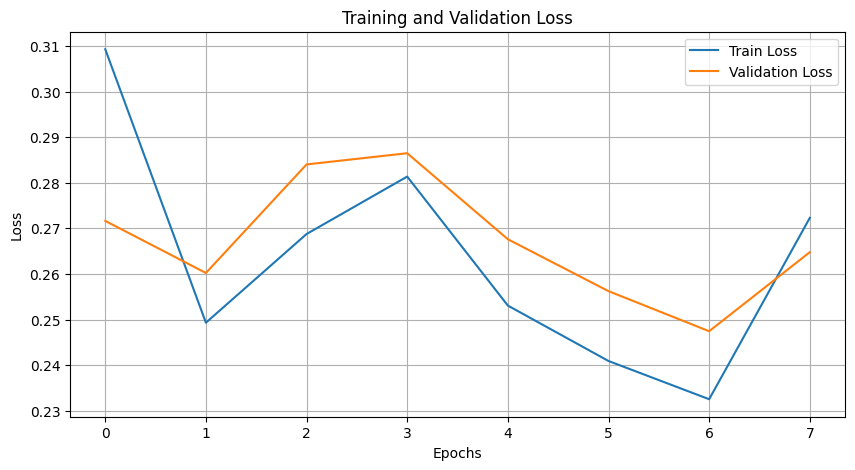

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 46gmgw6s with config:
wandb: 	model: resnet_model_3
wandb: 	transforms: AG_500_6


Detener entrenamiento en la época 5, la mejor pérdida fue 0.25148


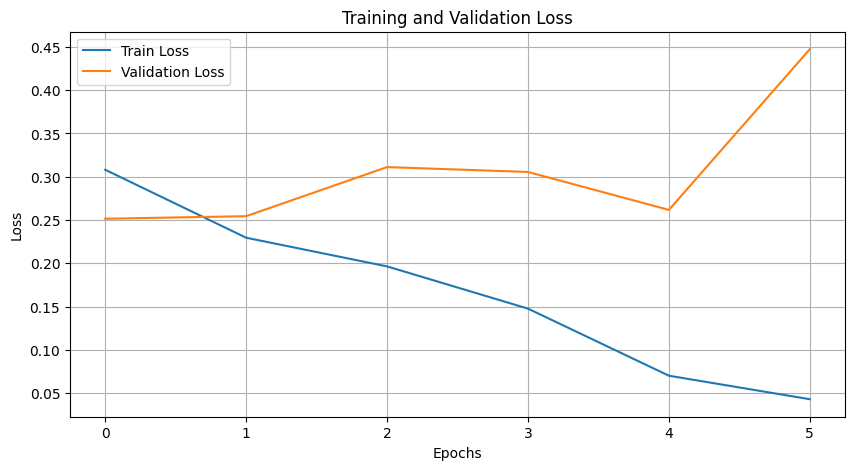

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: ym8at0b3 with config:
wandb: 	model: resnet_model_3
wandb: 	transforms: AG_500_7


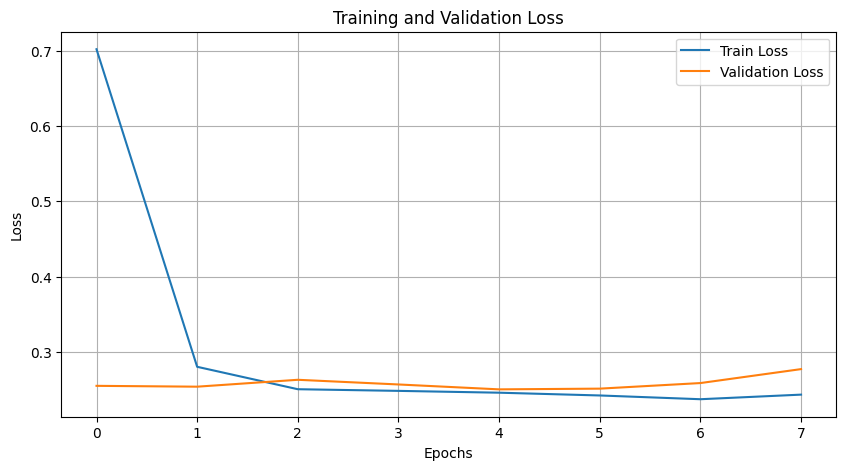

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: mjy0l328 with config:
wandb: 	model: resnet_model_4
wandb: 	transforms: AG_500_1


Detener entrenamiento en la época 5, la mejor pérdida fue 0.62169


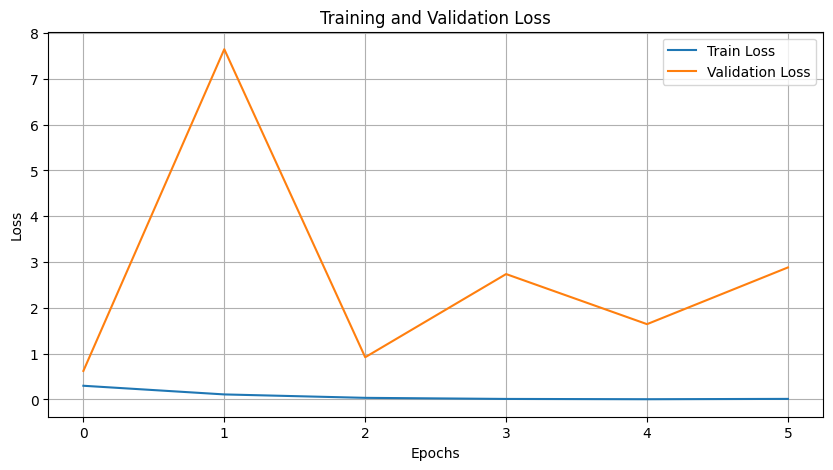

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qhv2in71 with config:
wandb: 	model: resnet_model_4
wandb: 	transforms: AG_500_2


Detener entrenamiento en la época 5, la mejor pérdida fue 0.32280


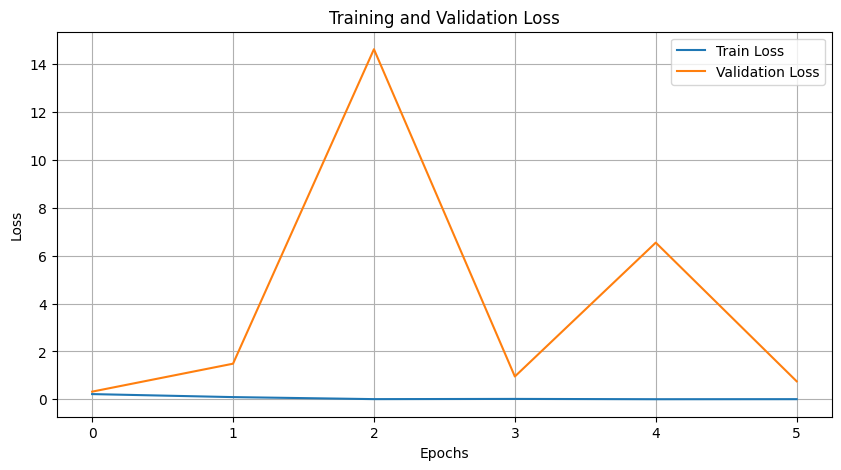

Accuracy: 0.7350

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84        93
           1       0.23      0.12      0.16        24

    accuracy                           0.74       117
   macro avg       0.51      0.51      0.50       117
weighted avg       0.68      0.74      0.70       117



wandb: Agent Starting Run: ngug64uu with config:
wandb: 	model: resnet_model_4
wandb: 	transforms: AG_500_3


Detener entrenamiento en la época 5, la mejor pérdida fue 0.33767


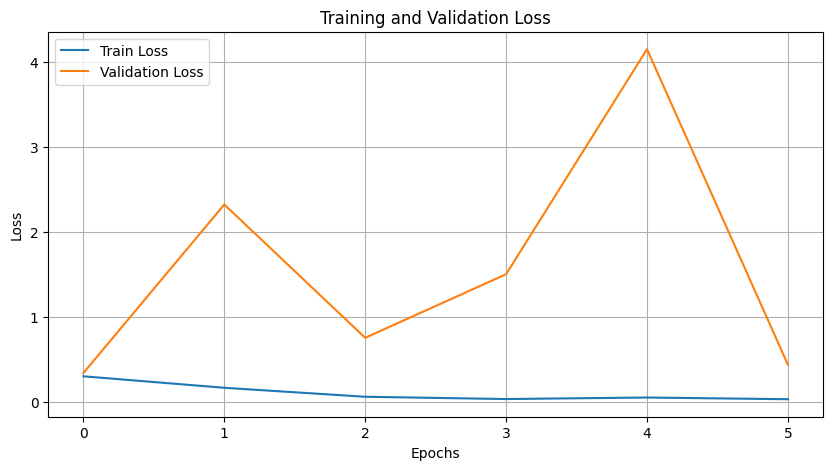

Accuracy: 0.7778

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.98      0.88        93
           1       0.00      0.00      0.00        24

    accuracy                           0.78       117
   macro avg       0.40      0.49      0.44       117
weighted avg       0.63      0.78      0.70       117



wandb: Agent Starting Run: jebxet87 with config:
wandb: 	model: resnet_model_4
wandb: 	transforms: AG_500_4


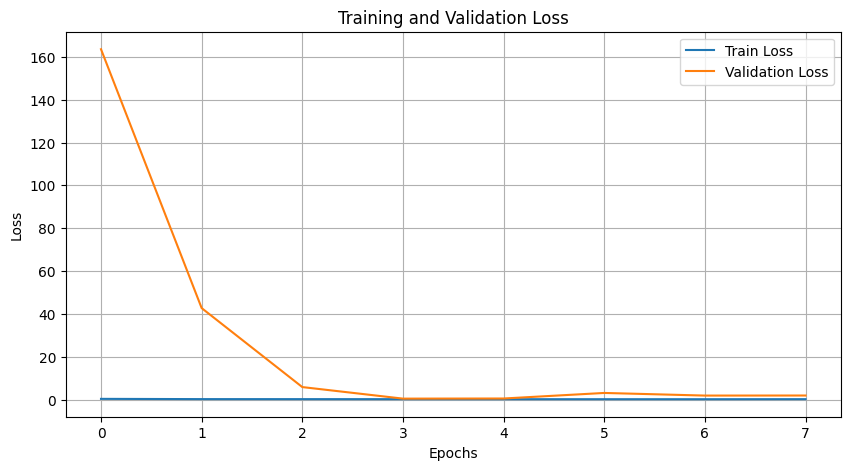

Accuracy: 0.2222

Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      0.02      0.04        93
           1       0.21      1.00      0.35        24

    accuracy                           0.22       117
   macro avg       0.60      0.51      0.19       117
weighted avg       0.84      0.22      0.10       117



wandb: Agent Starting Run: tdgivhtc with config:
wandb: 	model: resnet_model_4
wandb: 	transforms: AG_500_5


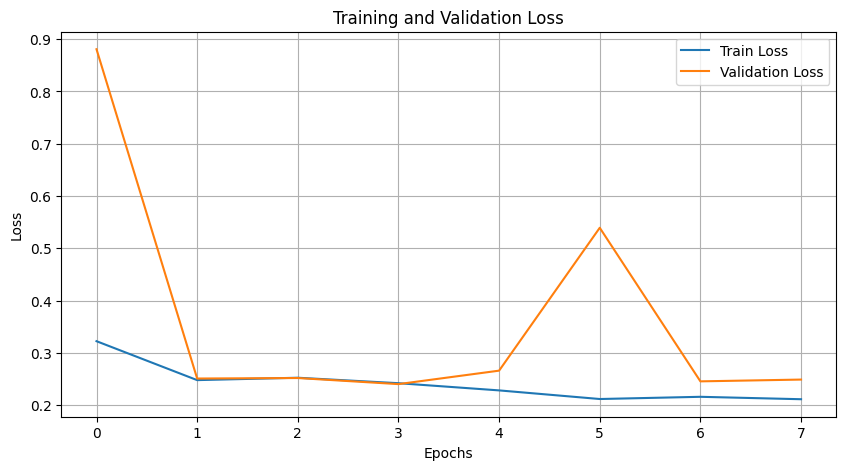

Accuracy: 0.8034

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        93
           1       1.00      0.04      0.08        24

    accuracy                           0.80       117
   macro avg       0.90      0.52      0.48       117
weighted avg       0.84      0.80      0.72       117



wandb: Agent Starting Run: rf6uobku with config:
wandb: 	model: resnet_model_4
wandb: 	transforms: AG_500_6


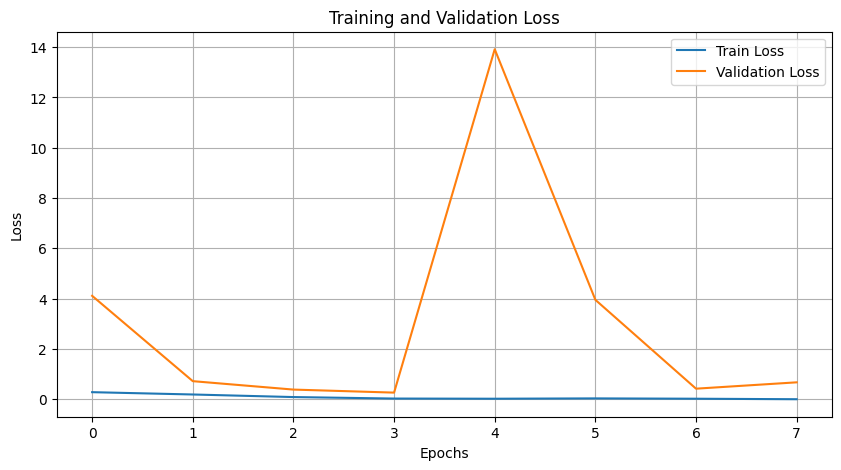

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: gye70l9p with config:
wandb: 	model: resnet_model_4
wandb: 	transforms: AG_500_7


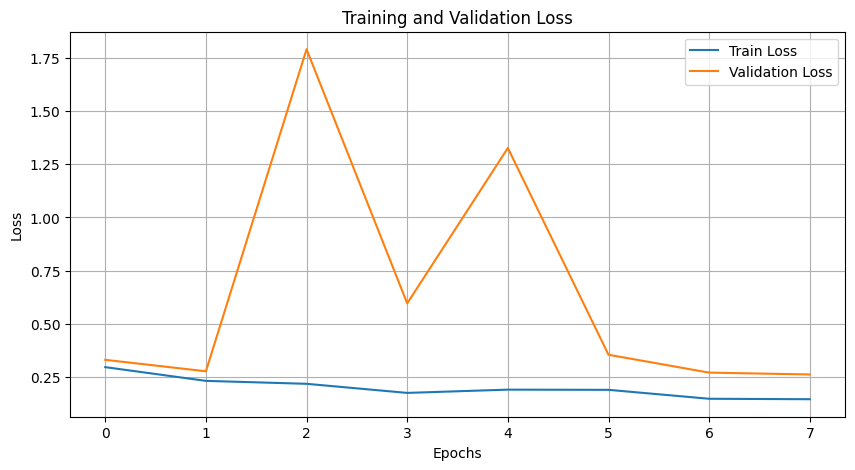

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
wandb.agent(sweep_id, function=sweep_run)

#### W&B - imagenes 256x256

In [ ]:
WANDB_TEAM_NAME = "valeriaeskenazi-universidad-ort-uruguay"
WANDB_PROJECT = "Obligatorio-ML-en-produccion"

# La configuración del sweep: los parámetros que queremos optimizar
sweep_config = {
    "name": "experimento_2_256x256",
    "method": "grid", #puede haber tres variantes, se puede ir probando para ver cual es el mejor:
    #grid search: todas las opciones
    #busqueda: ver tipo de correlaciones y le mete mas al que le parezca
    #random: el mas recomendable
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "model": {"values": ["lenet_model_2", "resnet_model_3", "resnet_model_4"]},
        "transforms": {"values": [ "AG_256_1", "AG_256_2", "AG_256_3", "AG_256_4", "AG_256_5", "AG_256_6", "AG_256_7"]},
    },
}

# Crea un nuevo sweep (podríamos usar un sweep existente si ya lo hubiéramos creado)
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: gqtt9uew
Sweep URL: https://wandb.ai/valeriaeskenazi-universidad-ort-uruguay/Obligatorio-ML-en-produccion/sweeps/gqtt9uew


In [ ]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()

    # leer la configuración del run
    config = wandb.config
    run_model = config.model
    run_transforms = config.transforms

    if run_model == "lenet_model_2":
        model = LeNet_2(3, 2).to(DEVICE)
        if run_transforms == "AG_256_1":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_1, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_2":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_2, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_3":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_3, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_4":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_4, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_5":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_5, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_6":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_6, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_7":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_7, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    elif run_model == "resnet_model_3":
        model = ResNet18_3(3, 2).to(DEVICE)
        if run_transforms == "AG_256_1":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_1, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_2":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_2, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_3":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_3, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_4":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_4, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_5":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_5, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_6":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_6, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_7":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_7, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    elif run_model == "resnet_model_4":
        model = ResNet18_4(3, 2).to(DEVICE)
        if run_transforms == "AG_256_1":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_1, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_2":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_2, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_3":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_3, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_4":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_4, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_5":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_5, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_6":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_6, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
        elif run_transforms == "AG_256_7":
          train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_7, BS_256, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    CRITERION = nn.CrossEntropyLoss(weight=weights).to(DEVICE)
    train_errors_ln_nda, val_errors_ln_nda =train(
            model=model,
            optimizer=optimizer,
            criterion=CRITERION,
            train_loader=train_loader,
            val_loader=valid_loader,
            device=DEVICE,
            do_early_stopping=True,
            patience=5,
            epochs=EPOCHS,
            log_fn=wand_log,
            log_every=1,
        )
    plot_taining(train_errors_ln_nda, val_errors_ln_nda)
    model_calassification_report(model, test_loader, DEVICE, 2)


    # Guardar el modelo al final
    torch.save(model.state_dict(), f"Experimento2__256x256_{wandb.run.name}.pth")
    wandb.save(f"Experimento2_256x256_{wandb.run.name}.pth")
    wandb.finish()


wandb: Agent Starting Run: kexkw57h with config:
wandb: 	model: lenet_model_2
wandb: 	transforms: AG_256_1


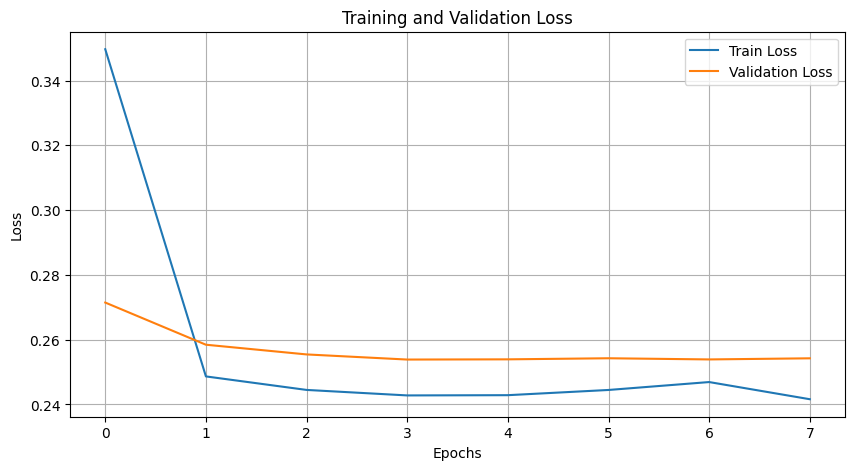

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: ymju0y8g with config:
wandb: 	model: lenet_model_2
wandb: 	transforms: AG_256_2


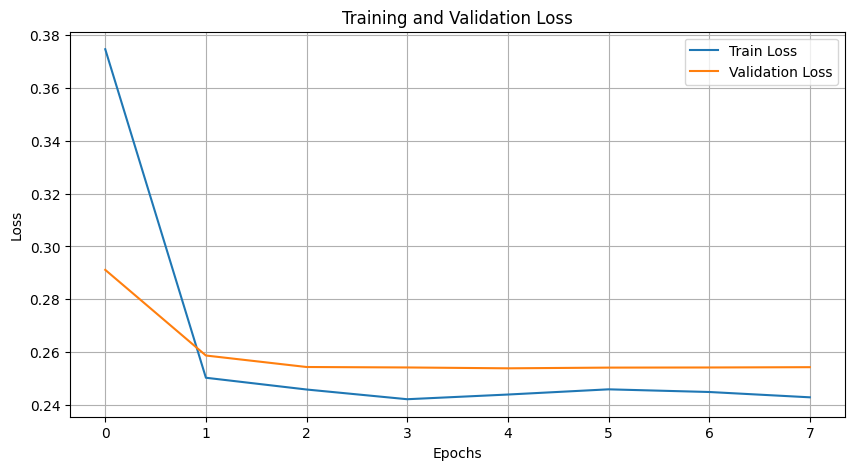

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 52ovuani with config:
wandb: 	model: lenet_model_2
wandb: 	transforms: AG_256_3


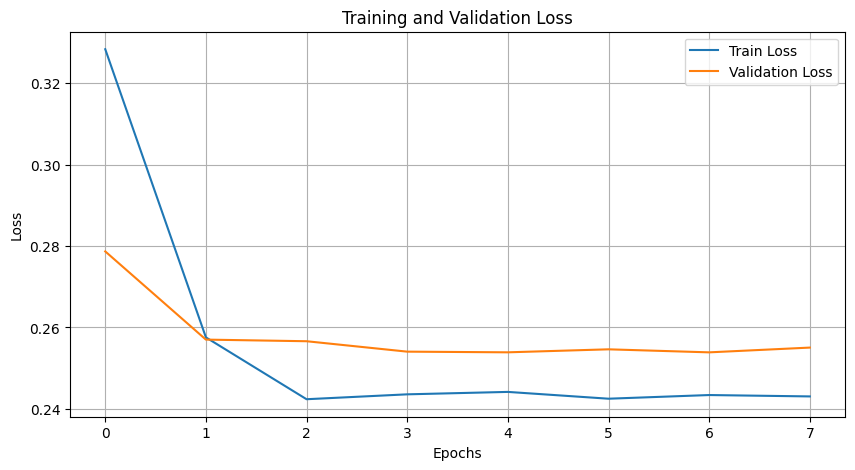

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: xvtsgfu0 with config:
wandb: 	model: lenet_model_2
wandb: 	transforms: AG_256_4


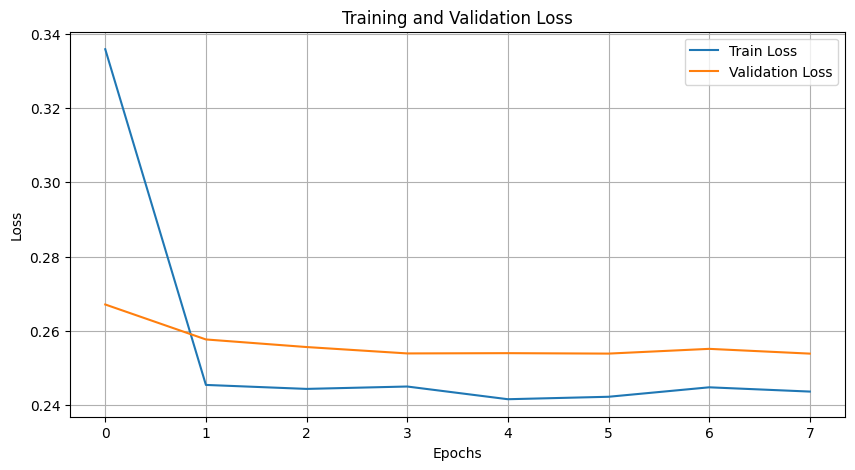

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: gkt68yl7 with config:
wandb: 	model: lenet_model_2
wandb: 	transforms: AG_256_5


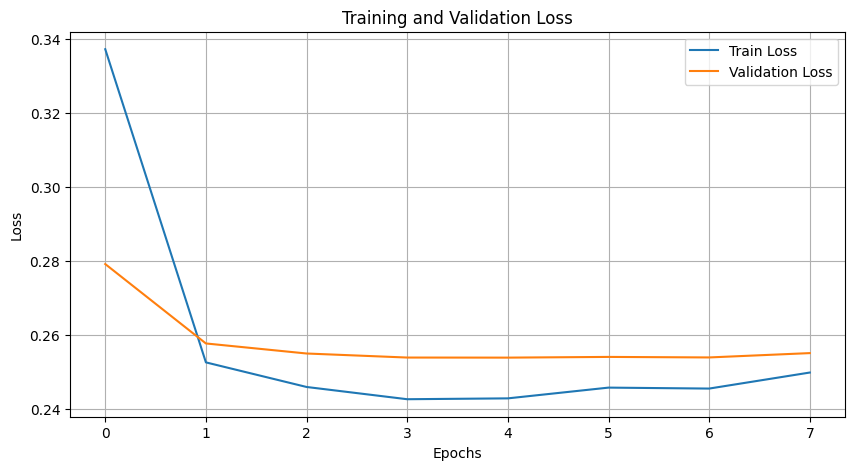

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 5lvnhbgm with config:
wandb: 	model: lenet_model_2
wandb: 	transforms: AG_256_6


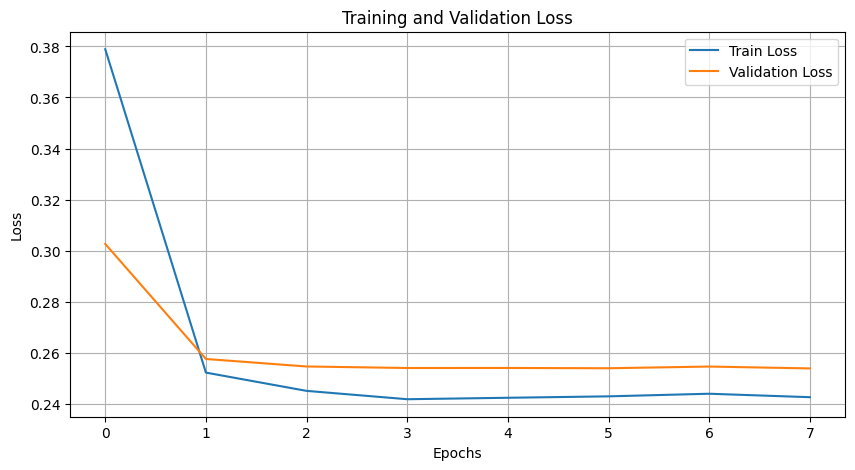

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: pc12s2gl with config:
wandb: 	model: lenet_model_2
wandb: 	transforms: AG_256_7


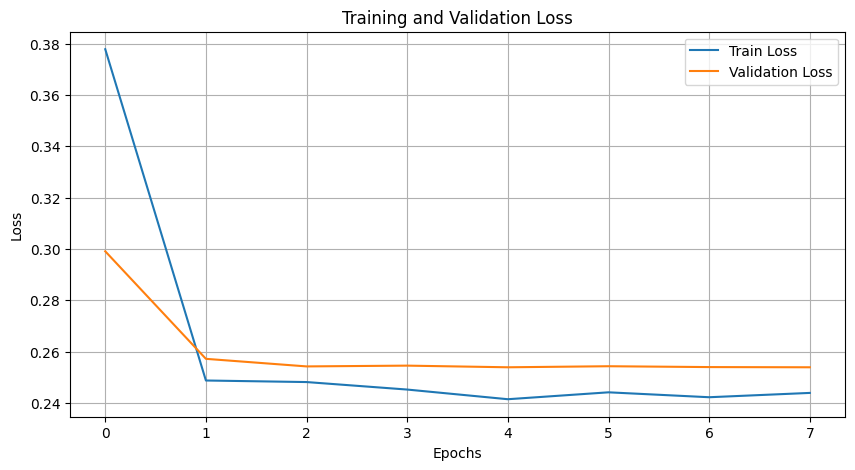

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 8s2rjz9f with config:
wandb: 	model: resnet_model_3
wandb: 	transforms: AG_256_1


Detener entrenamiento en la época 6, la mejor pérdida fue 0.24742


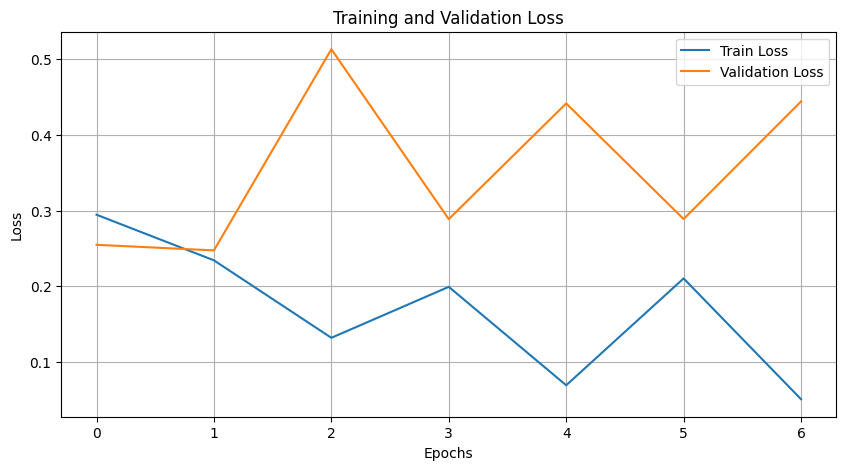

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: mfq3rqtx with config:
wandb: 	model: resnet_model_3
wandb: 	transforms: AG_256_2


Detener entrenamiento en la época 6, la mejor pérdida fue 0.25151


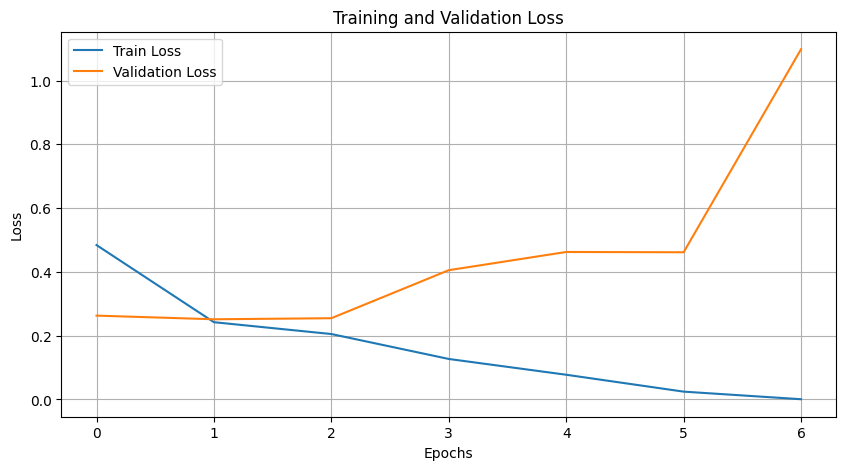

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: b2u4j1zy with config:
wandb: 	model: resnet_model_3
wandb: 	transforms: AG_256_3


Detener entrenamiento en la época 5, la mejor pérdida fue 0.25793


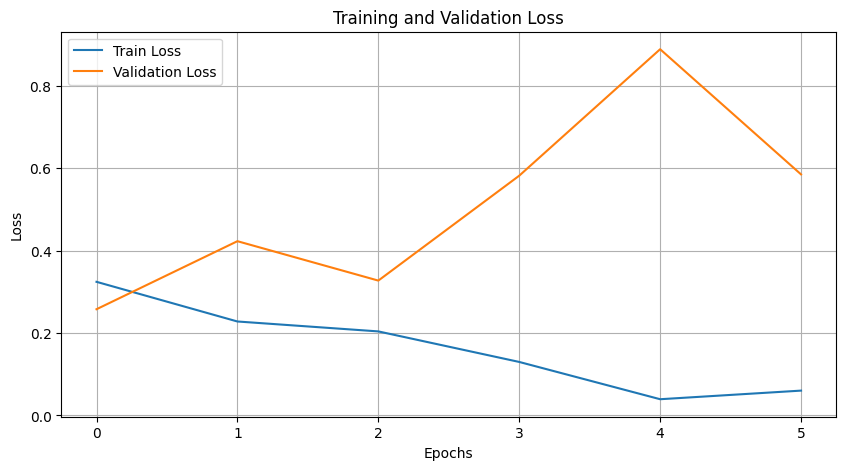

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: pb6uj863 with config:
wandb: 	model: resnet_model_3
wandb: 	transforms: AG_256_4


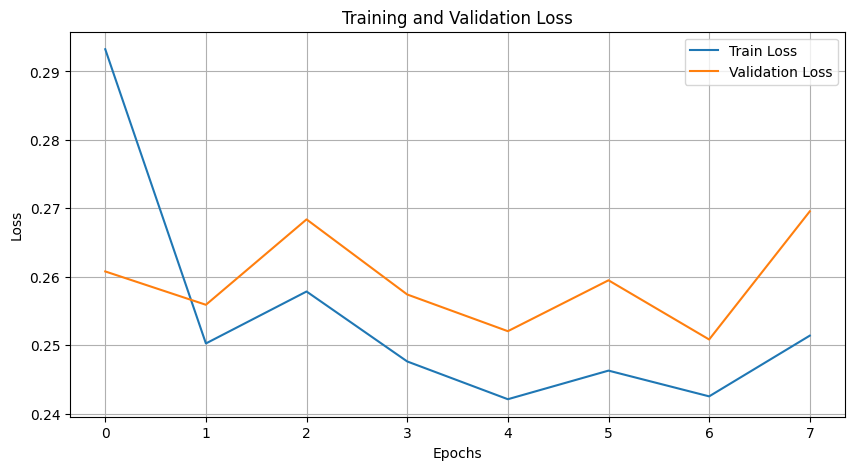

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 7v0f5trl with config:
wandb: 	model: resnet_model_3
wandb: 	transforms: AG_256_5


Detener entrenamiento en la época 5, la mejor pérdida fue 0.25358


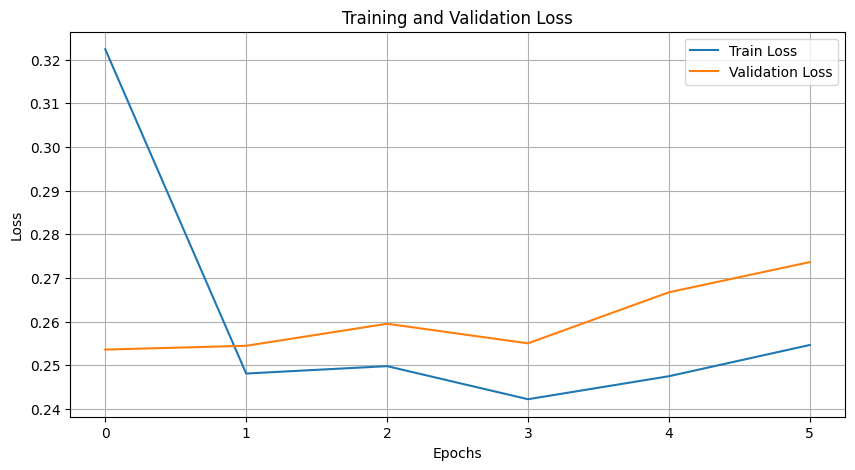

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: d31oj3co with config:
wandb: 	model: resnet_model_3
wandb: 	transforms: AG_256_6


Detener entrenamiento en la época 6, la mejor pérdida fue 0.25679


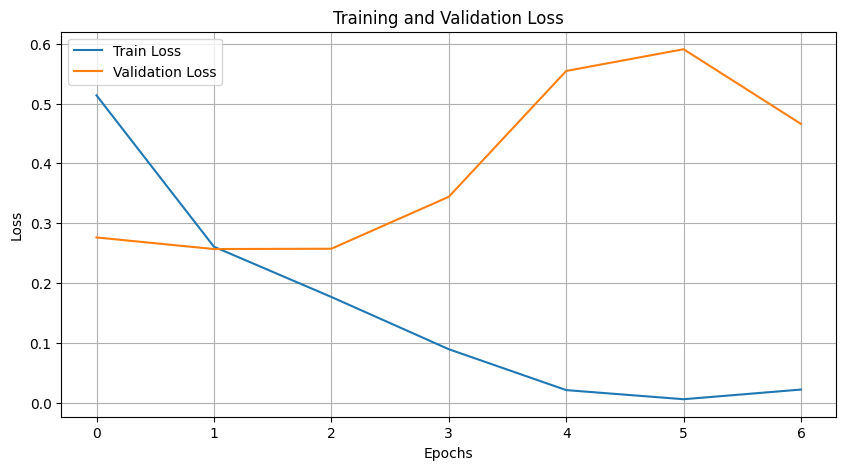

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: s5pilpjz with config:
wandb: 	model: resnet_model_3
wandb: 	transforms: AG_256_7


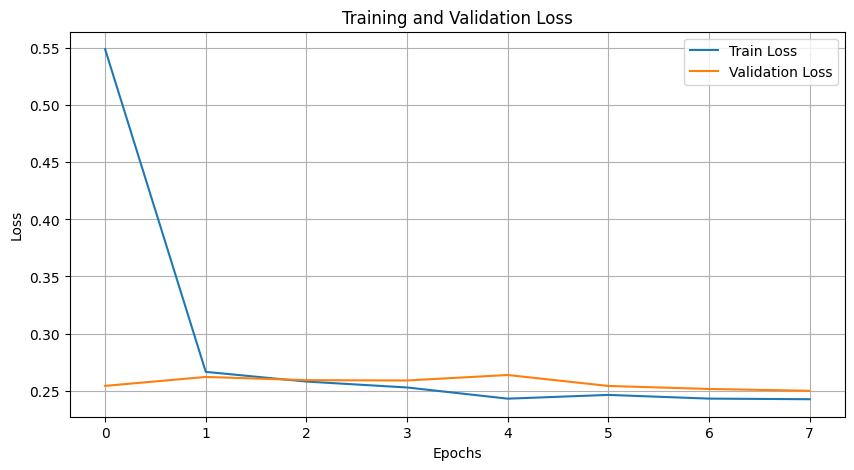

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: c46213iv with config:
wandb: 	model: resnet_model_4
wandb: 	transforms: AG_256_1


Detener entrenamiento en la época 5, la mejor pérdida fue 0.27101


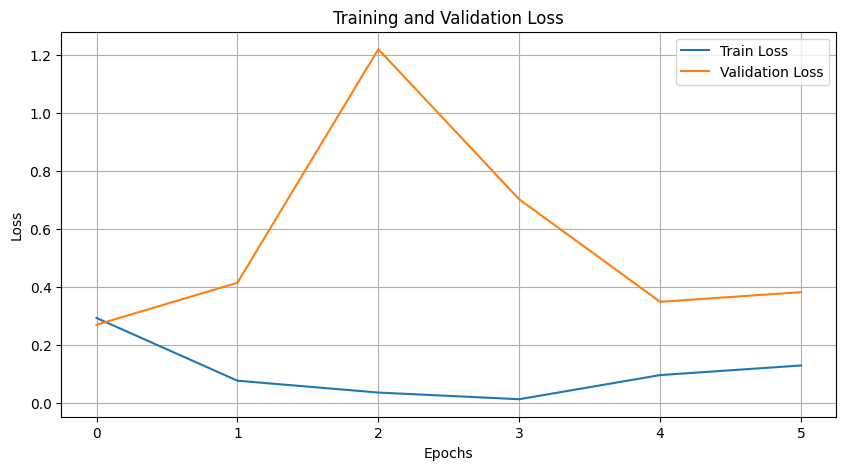

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: yzf62mrk with config:
wandb: 	model: resnet_model_4
wandb: 	transforms: AG_256_2


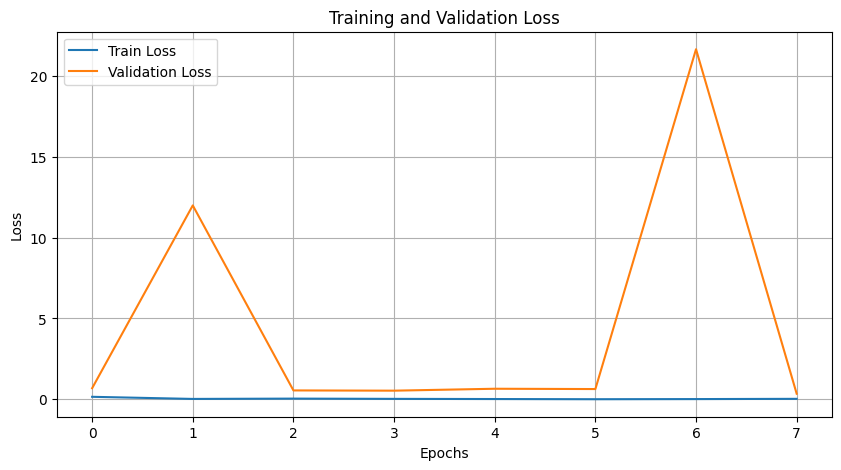

Accuracy: 0.7863

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88        93
           1       0.33      0.04      0.07        24

    accuracy                           0.79       117
   macro avg       0.57      0.51      0.48       117
weighted avg       0.70      0.79      0.71       117



wandb: Agent Starting Run: f78742nn with config:
wandb: 	model: resnet_model_4
wandb: 	transforms: AG_256_3


Detener entrenamiento en la época 5, la mejor pérdida fue 0.29482


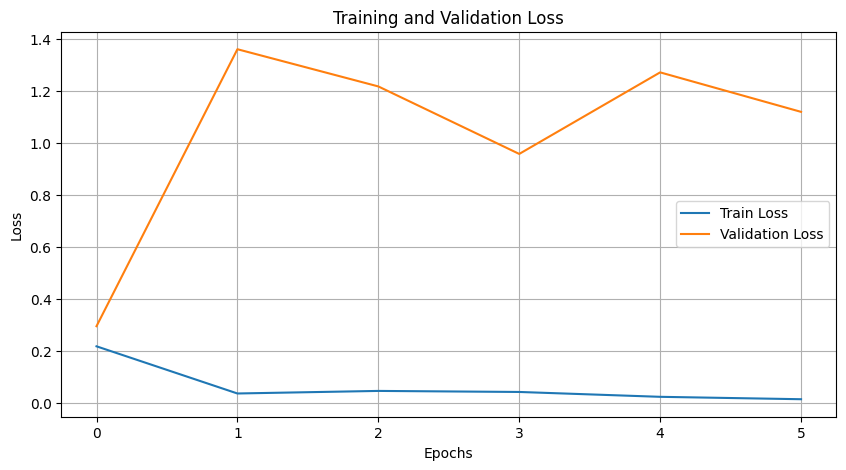

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: g62csdl8 with config:
wandb: 	model: resnet_model_4
wandb: 	transforms: AG_256_4


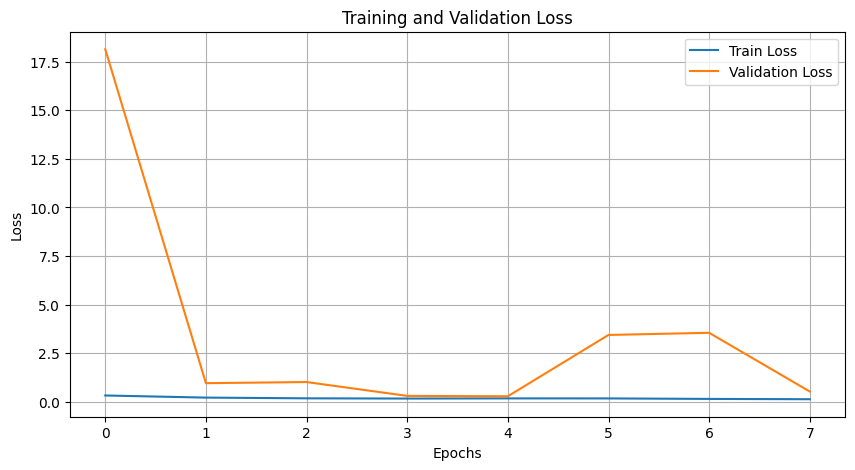

Accuracy: 0.7094

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82        93
           1       0.29      0.29      0.29        24

    accuracy                           0.71       117
   macro avg       0.55      0.55      0.55       117
weighted avg       0.71      0.71      0.71       117



wandb: Agent Starting Run: 4uvouxvt with config:
wandb: 	model: resnet_model_4
wandb: 	transforms: AG_256_5


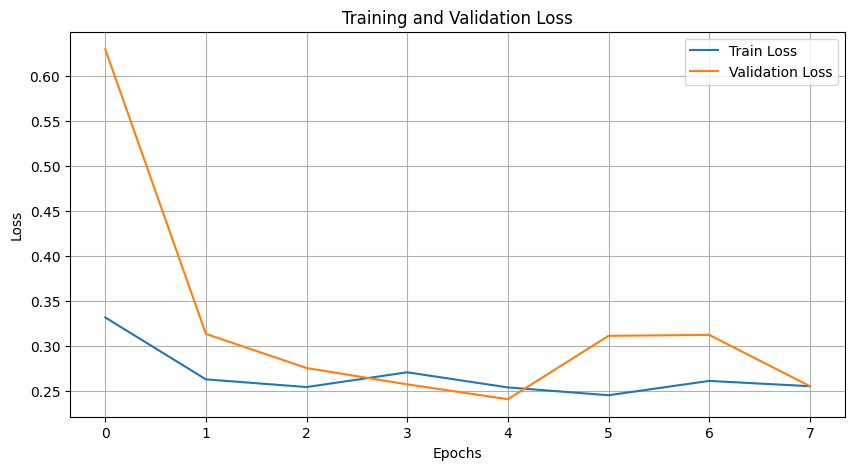

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ct16m28 with config:
wandb: 	model: resnet_model_4
wandb: 	transforms: AG_256_6


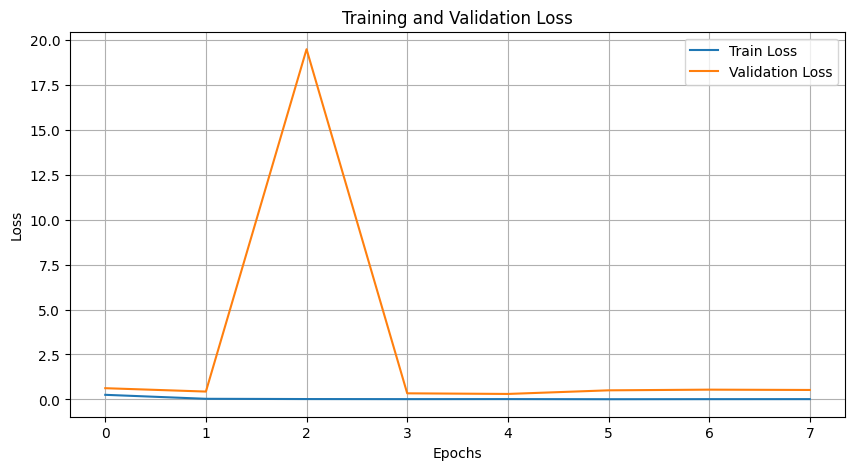

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: aha3u852 with config:
wandb: 	model: resnet_model_4
wandb: 	transforms: AG_256_7


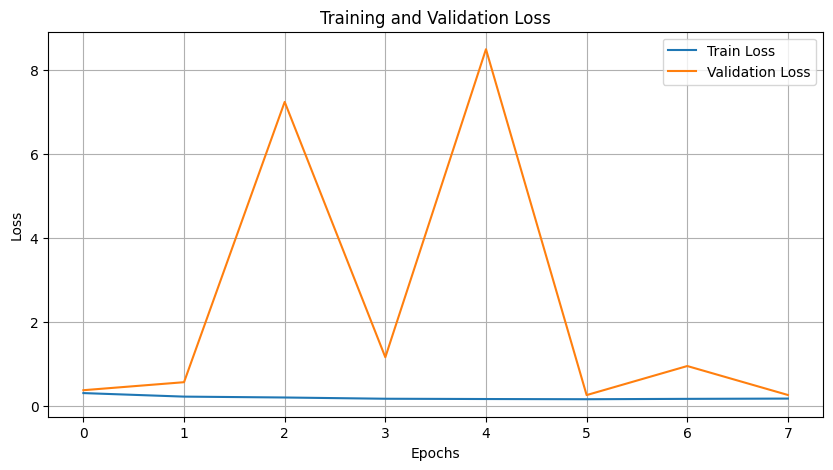

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
wandb.agent(sweep_id, function=sweep_run)

### EXPERIMENTO 3 - Ajuste de Hiperparametros

En este apartado se busca optimizar el mejor modelo obtenido en los experimentos anteriores

#### W&B - imagenes 500x500

In [ ]:
WANDB_TEAM_NAME = "valeriaeskenazi-universidad-ort-uruguay"
WANDB_PROJECT = "Obligatorio-ML-en-produccion"

# La configuración del sweep: los parámetros que queremos optimizar
sweep_config = {
    "name": "experimento_3_500x500",
    "method": "random", #puede haber tres variantes, se puede ir probando para ver cual es el mejor:
    #grid search: todas las opciones
    #busqueda: ver tipo de correlaciones y le mete mas al que le parezca
    #random: el mas recomendable
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"distribution": "uniform", "max": 0.1, "min": 0}, # tambien se puede poner formulas en vez de hardcoodear
        "batch_size": {"values": [8, 16, 32]},
        "optimizer": {"values": ["adam", "SGD"]},
    },
}

# Crea un nuevo sweep (podríamos usar un sweep existente si ya lo hubiéramos creado)
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: 5f37uxmc
Sweep URL: https://wandb.ai/valeriaeskenazi-universidad-ort-uruguay/Obligatorio-ML-en-produccion/sweeps/5f37uxmc


In [ ]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()

    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_batch_size = config.batch_size
    run_optimizer = config.optimizer



    model = ResNet18_4(3, 2).to(DEVICE)
    train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_5, BS_500_1, batch_size=run_batch_size, num_workers=NUM_WORKERS)

    if run_optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=run_learning_rate)
    elif run_optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=run_learning_rate)

    CRITERION = nn.CrossEntropyLoss(weight=weights).to(DEVICE)
    train_errors_ln_nda, val_errors_ln_nda=train(
            model=model,
            optimizer=optimizer,
            criterion=CRITERION,
            train_loader=train_loader,
            val_loader=valid_loader,
            device=DEVICE,
            do_early_stopping=True,
            patience=5,
            epochs=EPOCHS,
            log_fn=wand_log,
            log_every=1,
        )
    plot_taining(train_errors_ln_nda, val_errors_ln_nda)
    model_calassification_report(model, test_loader, DEVICE, 2)


    # Guardar el modelo al final
    torch.save(model.state_dict(), f"Experimento3_500x500{wandb.run.name}.pth")
    wandb.save(f"Experimento3_500x500{wandb.run.name}.pth")
    wandb.finish()


In [ ]:
EPOCHS = 15

wandb: Agent Starting Run: 7cjukpd0 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.09620021555618102
wandb: 	optimizer: SGD


Detener entrenamiento en la época 14, la mejor pérdida fue 0.20483


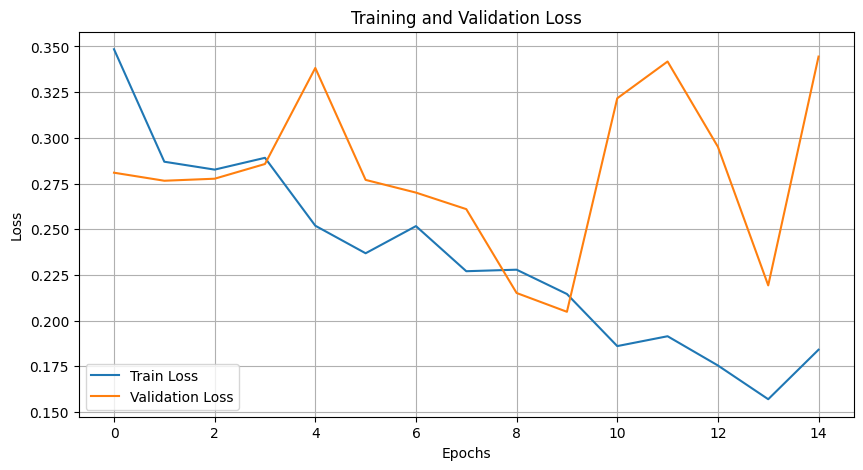

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 5dsxu1ix with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.08971782139484752
wandb: 	optimizer: SGD


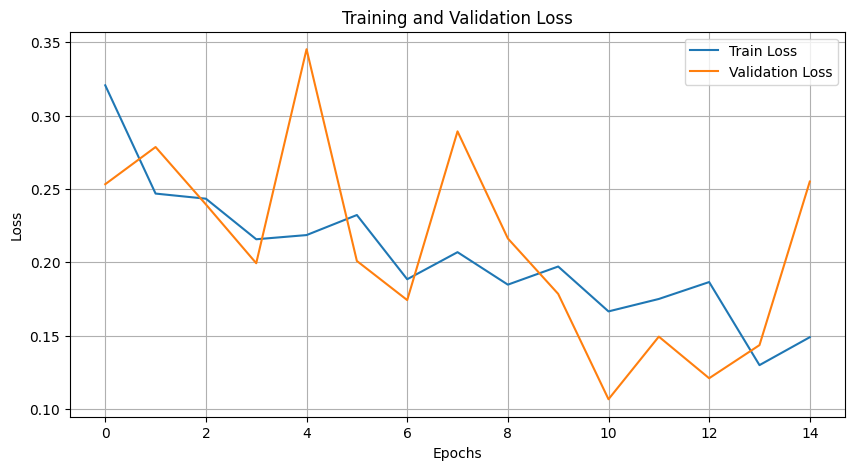

Accuracy: 0.8462

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91        93
           1       1.00      0.25      0.40        24

    accuracy                           0.85       117
   macro avg       0.92      0.62      0.66       117
weighted avg       0.87      0.85      0.81       117



wandb: Agent Starting Run: 51ujgy8t with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.09527858468299558
wandb: 	optimizer: SGD


Detener entrenamiento en la época 13, la mejor pérdida fue 0.15789


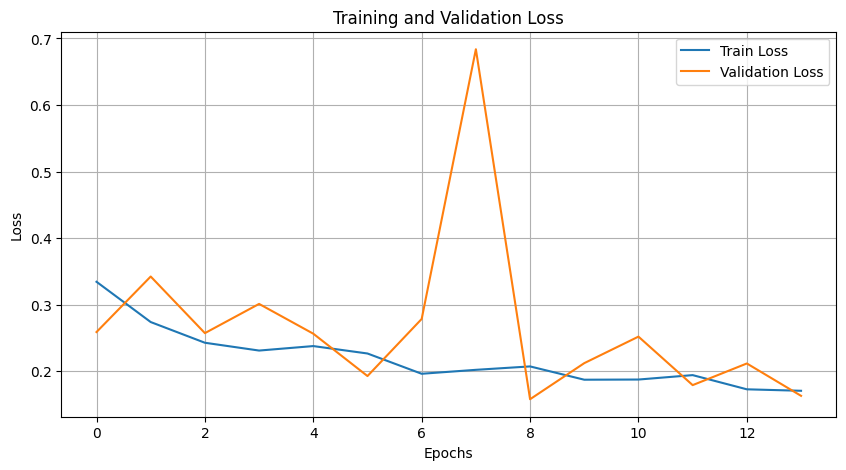

Accuracy: 0.8718

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93        93
           1       1.00      0.38      0.55        24

    accuracy                           0.87       117
   macro avg       0.93      0.69      0.74       117
weighted avg       0.89      0.87      0.85       117



wandb: Agent Starting Run: sj0g5tqk with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.014663492228779874
wandb: 	optimizer: adam


Detener entrenamiento en la época 6, la mejor pérdida fue 0.28049


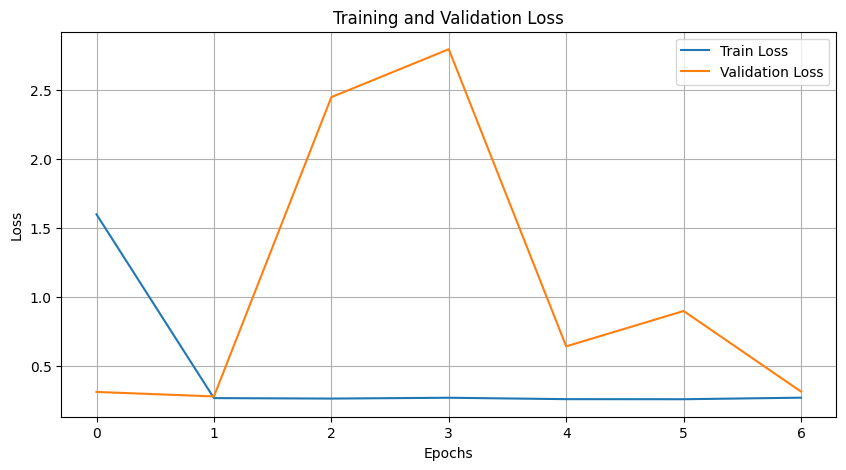

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: lcsww7lc with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.05672147121758201
wandb: 	optimizer: SGD


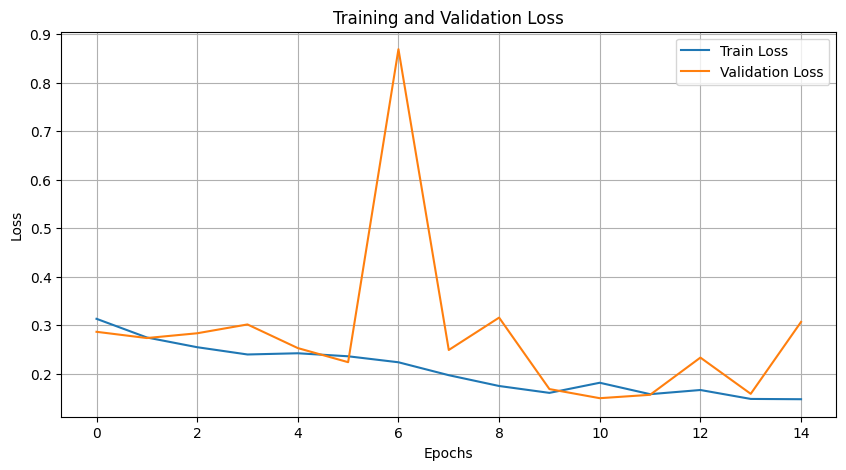

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: los7sr9k with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.03656756716856071
wandb: 	optimizer: SGD


Detener entrenamiento en la época 9, la mejor pérdida fue 0.23605


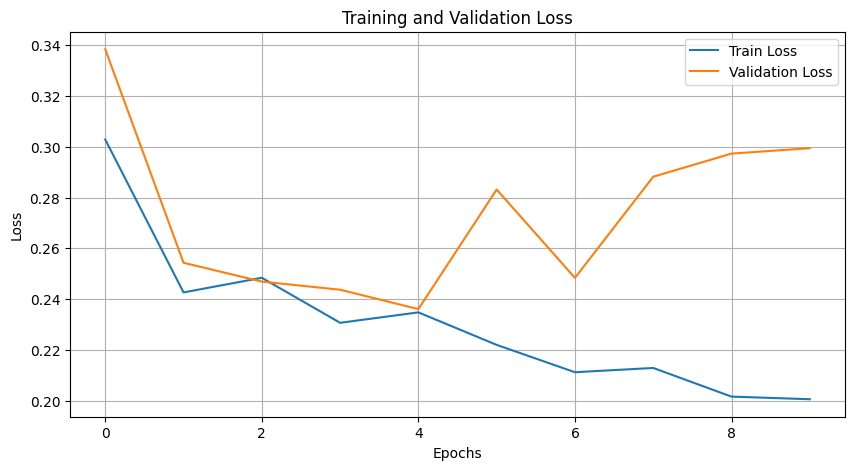

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: w8fdl2be with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.003788160276223496
wandb: 	optimizer: SGD


Detener entrenamiento en la época 6, la mejor pérdida fue 0.27343


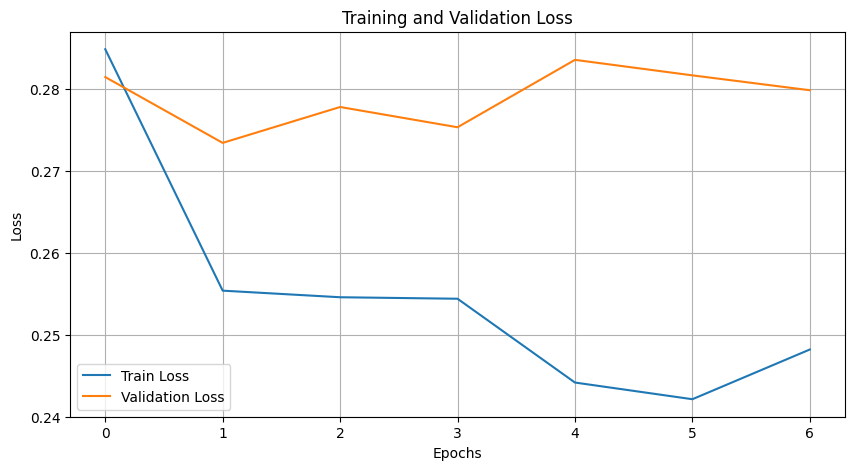

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: pcqcuhpr with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.07099163423055432
wandb: 	optimizer: SGD


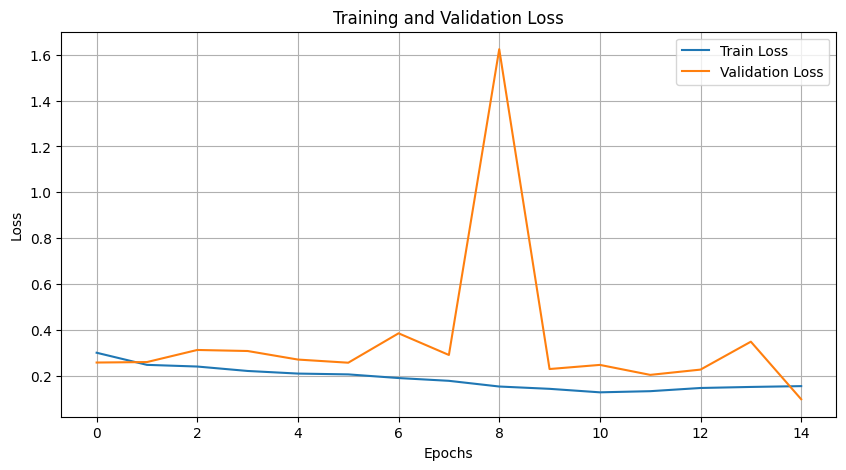

Accuracy: 0.8803

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93        93
           1       1.00      0.42      0.59        24

    accuracy                           0.88       117
   macro avg       0.93      0.71      0.76       117
weighted avg       0.90      0.88      0.86       117



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uhj73q7t with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.09807520190806604
wandb: 	optimizer: SGD


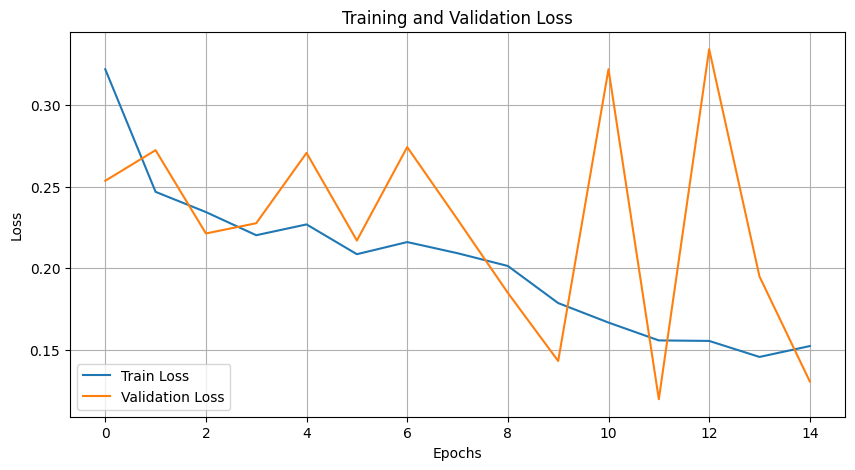

Accuracy: 0.8803

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93        93
           1       0.92      0.46      0.61        24

    accuracy                           0.88       117
   macro avg       0.90      0.72      0.77       117
weighted avg       0.88      0.88      0.86       117



wandb: Agent Starting Run: kp5vm20e with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.0269104723624138
wandb: 	optimizer: adam


Detener entrenamiento en la época 6, la mejor pérdida fue 0.27891


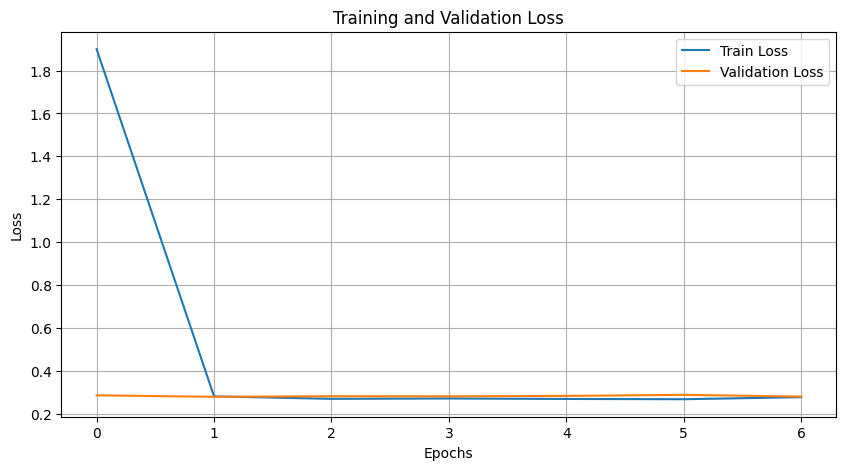

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 2x1ltvy9 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.016803395092953144
wandb: 	optimizer: adam


Detener entrenamiento en la época 6, la mejor pérdida fue 0.29683


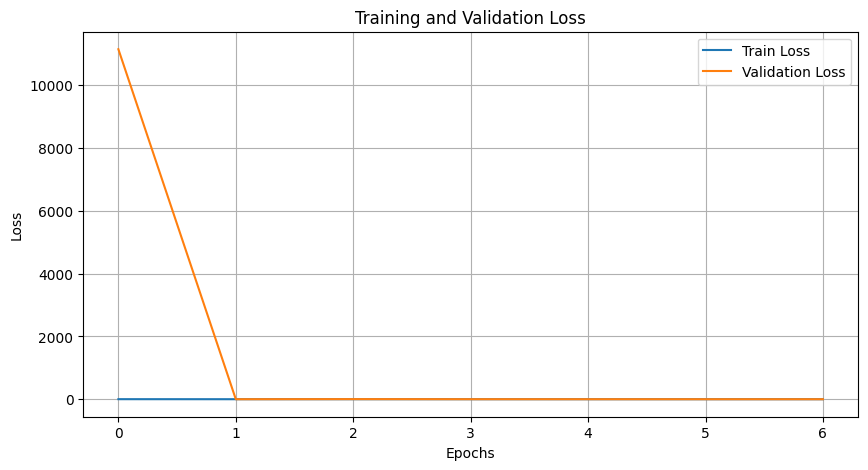

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: rlj050nl with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.023754664428582907
wandb: 	optimizer: adam


Detener entrenamiento en la época 11, la mejor pérdida fue 0.25365


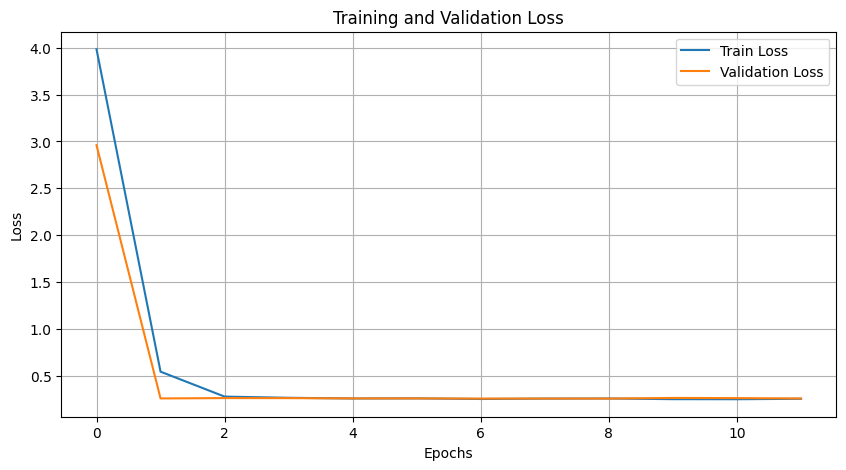

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: lpere859 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.02057862289546941
wandb: 	optimizer: SGD


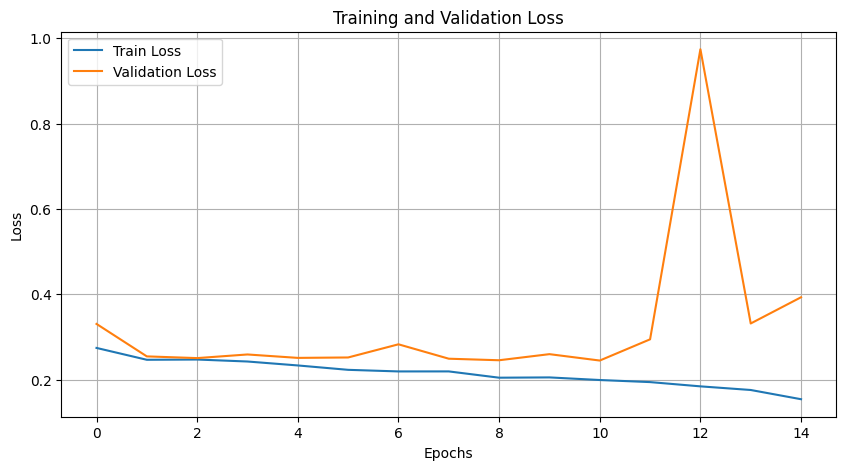

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: nt8524y5 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.018489742497002592
wandb: 	optimizer: SGD


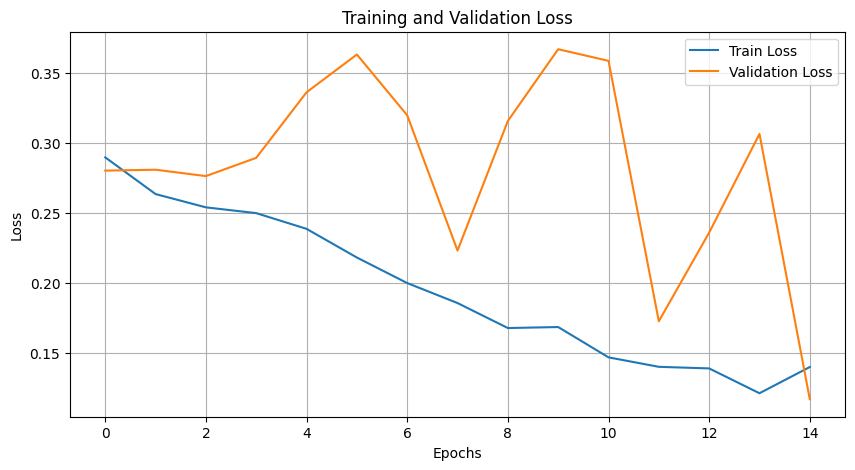

Accuracy: 0.8974

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        93
           1       1.00      0.50      0.67        24

    accuracy                           0.90       117
   macro avg       0.94      0.75      0.80       117
weighted avg       0.91      0.90      0.88       117



wandb: Agent Starting Run: 31mizkih with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.01832328735756372
wandb: 	optimizer: adam


Detener entrenamiento en la época 14, la mejor pérdida fue 0.27788


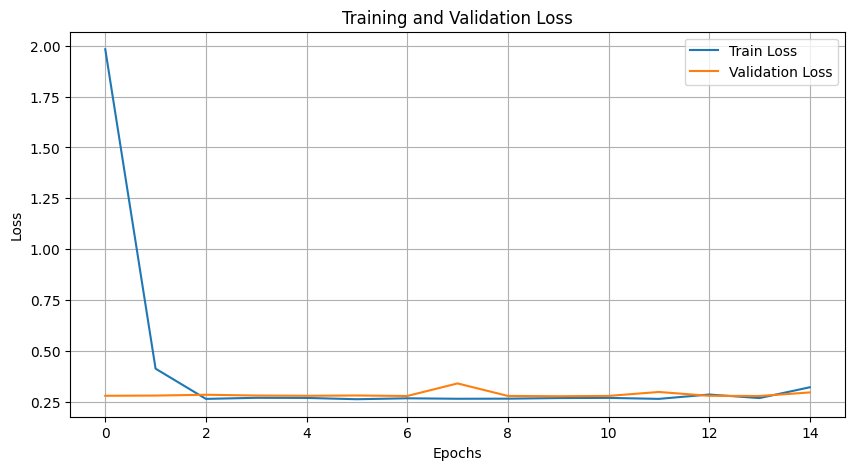

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 9xblmepg with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0946422812434036
wandb: 	optimizer: adam


Detener entrenamiento en la época 14, la mejor pérdida fue 0.25606


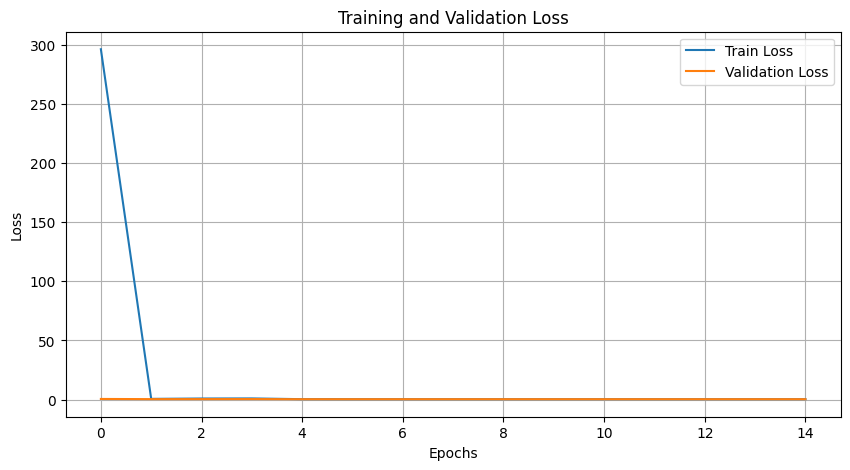

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: bvslcjn1 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.06896599647132629
wandb: 	optimizer: adam


Detener entrenamiento en la época 11, la mejor pérdida fue 0.28027


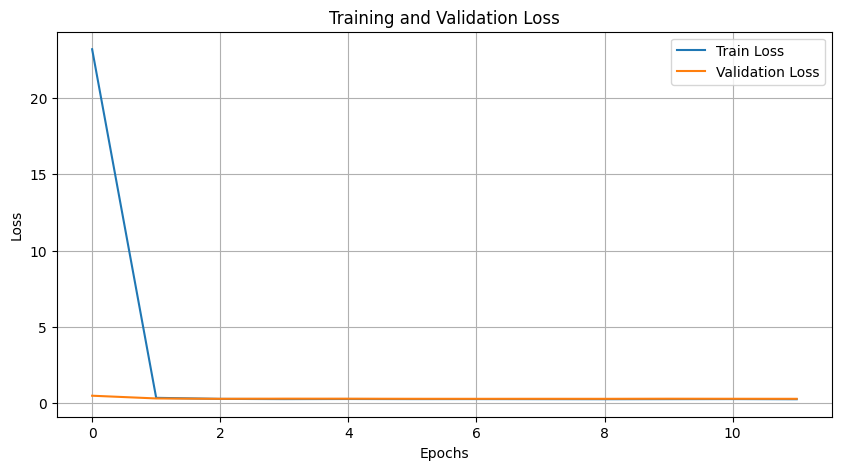

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 3pbbu4nw with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.08957597949545339
wandb: 	optimizer: SGD


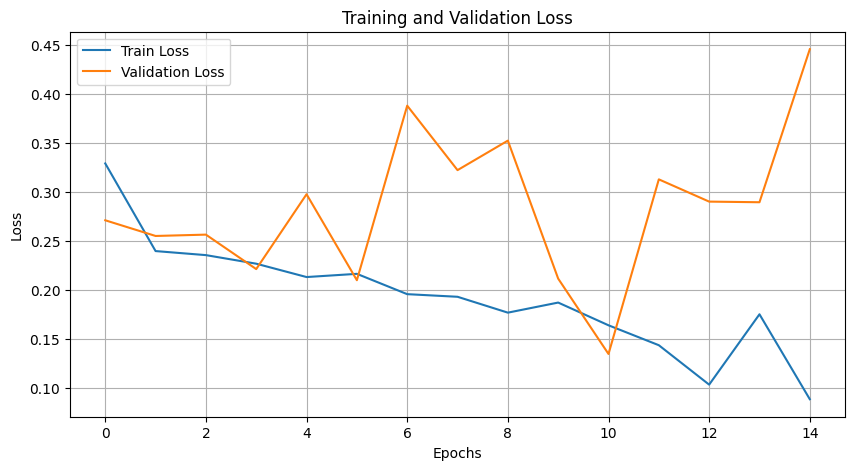

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9pwkyu7v with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01963289461990927
wandb: 	optimizer: adam


Detener entrenamiento en la época 14, la mejor pérdida fue 0.25468


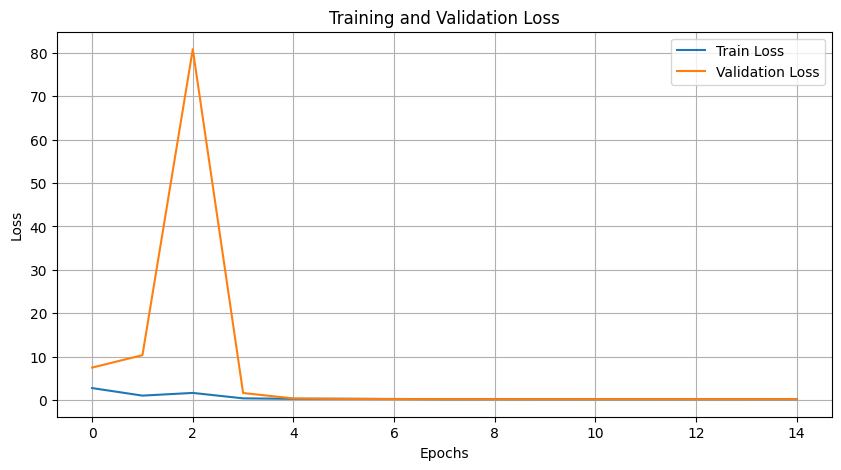

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 7wkv0tqi with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.07744324489060317
wandb: 	optimizer: SGD


Detener entrenamiento en la época 6, la mejor pérdida fue 0.23343


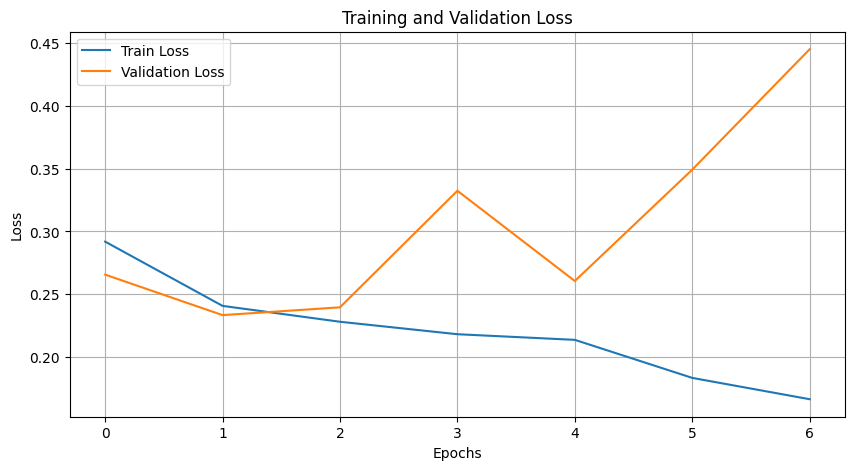

Accuracy: 0.7692

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86        93
           1       0.36      0.17      0.23        24

    accuracy                           0.77       117
   macro avg       0.59      0.55      0.55       117
weighted avg       0.72      0.77      0.73       117



In [ ]:
wandb.agent(sweep_id, function=sweep_run, count=20)

#### W&B - imagenes 256x256

In [ ]:
WANDB_TEAM_NAME = "valeriaeskenazi-universidad-ort-uruguay"
WANDB_PROJECT = "Obligatorio-ML-en-produccion"

# La configuración del sweep: los parámetros que queremos optimizar
sweep_config = {
    "name": "experimento_3_256x256",
    "method": "random", #puede haber tres variantes, se puede ir probando para ver cual es el mejor:
    #grid search: todas las opciones
    #busqueda: ver tipo de correlaciones y le mete mas al que le parezca
    #random: el mas recomendable
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"distribution": "uniform", "max": 0.1, "min": 0}, # tambien se puede poner formulas en vez de hardcoodear
        "batch_size": {"values": [8, 16, 32]},
        "optimizer": {"values": ["adam", "SGD"]},
    },
}

# Crea un nuevo sweep (podríamos usar un sweep existente si ya lo hubiéramos creado)
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: glp1pj1y
Sweep URL: https://wandb.ai/valeriaeskenazi-universidad-ort-uruguay/Obligatorio-ML-en-produccion/sweeps/glp1pj1y


In [ ]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()

    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_batch_size = config.batch_size
    run_optimizer = config.optimizer

    model = ResNet18_3(3, 2).to(DEVICE)
    train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_256, AG_256_7, BS_256, batch_size=run_batch_size, num_workers=NUM_WORKERS)

    if run_optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=run_learning_rate)
    elif run_optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=run_learning_rate)

    CRITERION = nn.CrossEntropyLoss(weight=weights).to(DEVICE)
    train_errors_ln_nda, val_errors_ln_nda=train(
            model=model,
            optimizer=optimizer,
            criterion=CRITERION,
            train_loader=train_loader,
            val_loader=valid_loader,
            device=DEVICE,
            do_early_stopping=True,
            patience=5,
            epochs=EPOCHS,
            log_fn=wand_log,
            log_every=1,
        )
    plot_taining(train_errors_ln_nda, val_errors_ln_nda)
    model_calassification_report(model, test_loader, DEVICE, 2)


    # Guardar el modelo al final
    torch.save(model.state_dict(), f"Experimento3_256x256{wandb.run.name}.pth")
    wandb.save(f"Experimento3_256x256{wandb.run.name}.pth")
    wandb.finish()


In [ ]:
EPOCHS = 15

wandb: Agent Starting Run: rxzwt352 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.013666859952123711
wandb: 	optimizer: adam


Detener entrenamiento en la época 8, la mejor pérdida fue 0.28017


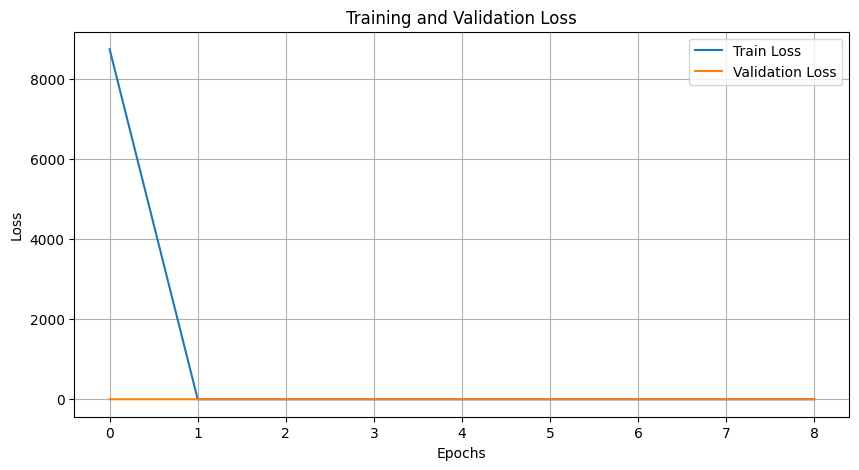

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: i3pscjgu with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.044025250297030416
wandb: 	optimizer: SGD


Detener entrenamiento en la época 8, la mejor pérdida fue 0.25291


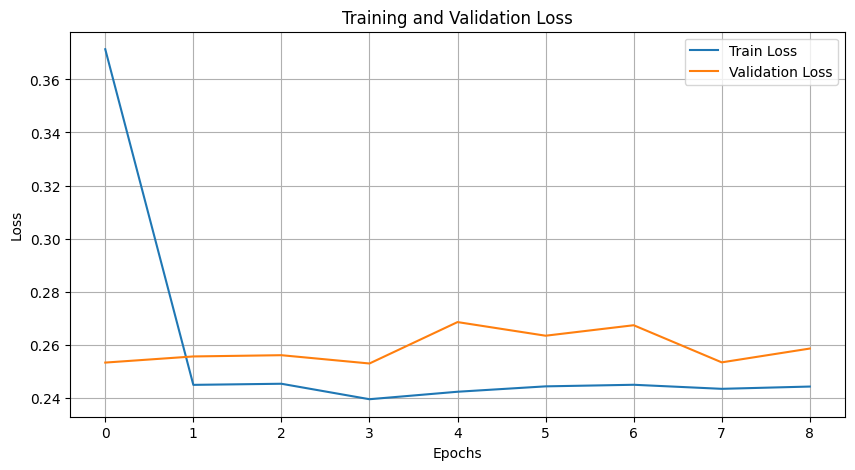

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: gspmv6ja with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.03651541076759481
wandb: 	optimizer: SGD


Detener entrenamiento en la época 8, la mejor pérdida fue 0.27983


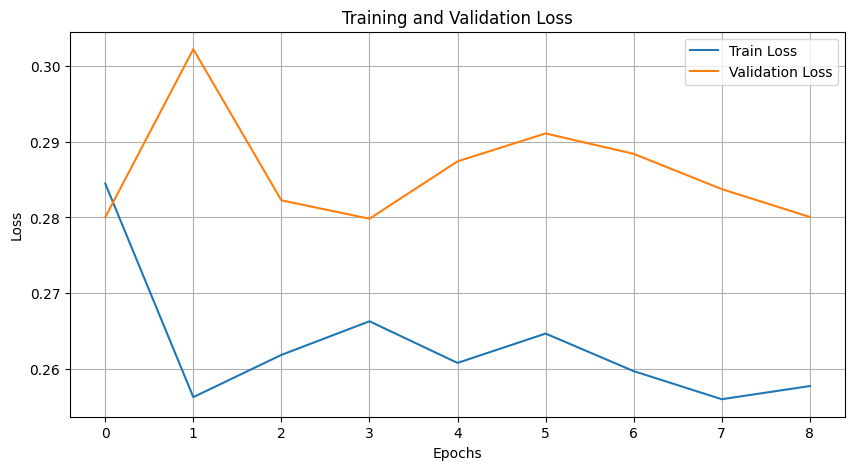

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: tn7h9und with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.06447479848171508
wandb: 	optimizer: SGD


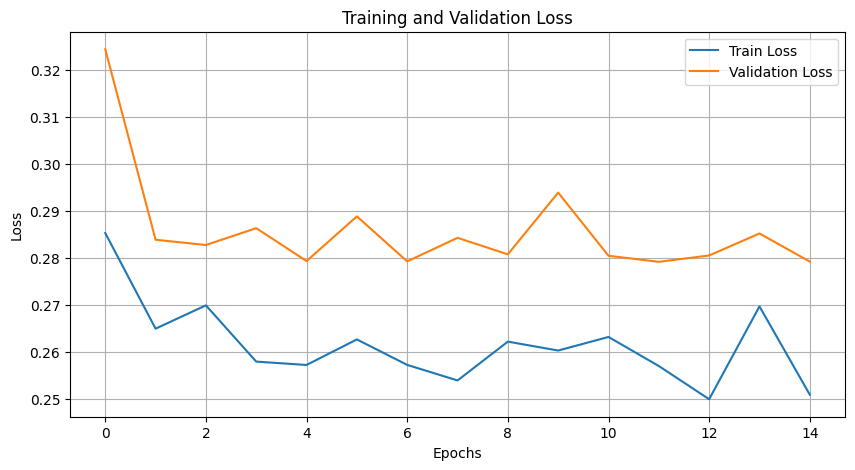

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: kbo8x462 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.004077703040968261
wandb: 	optimizer: SGD


Detener entrenamiento en la época 12, la mejor pérdida fue 0.25298


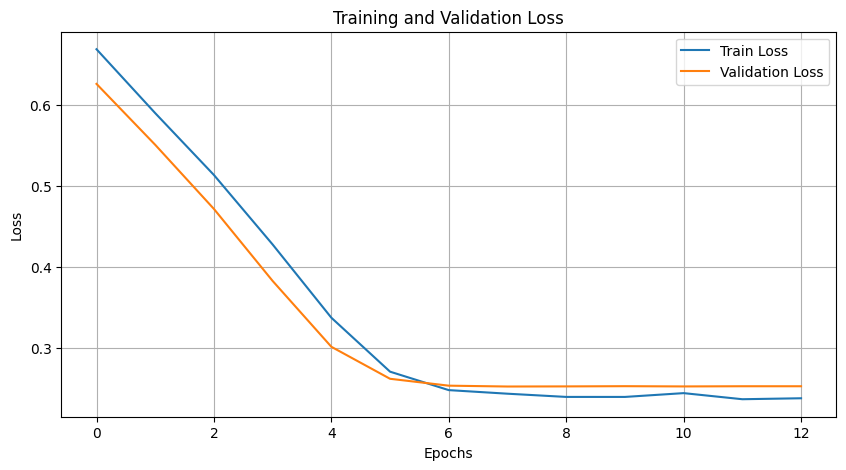

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 8rmi9kyl with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.03565077450864995
wandb: 	optimizer: SGD


Detener entrenamiento en la época 7, la mejor pérdida fue 0.27963


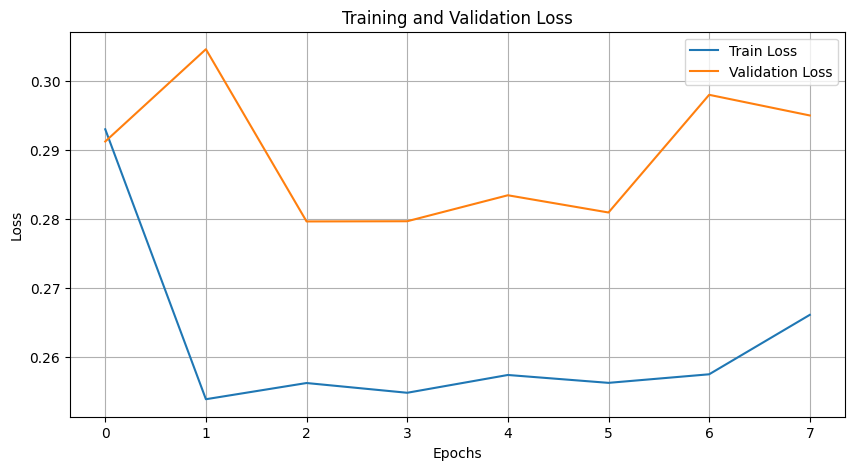

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: kbpjn9f9 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.03261921828384369
wandb: 	optimizer: adam


Detener entrenamiento en la época 14, la mejor pérdida fue 0.25388


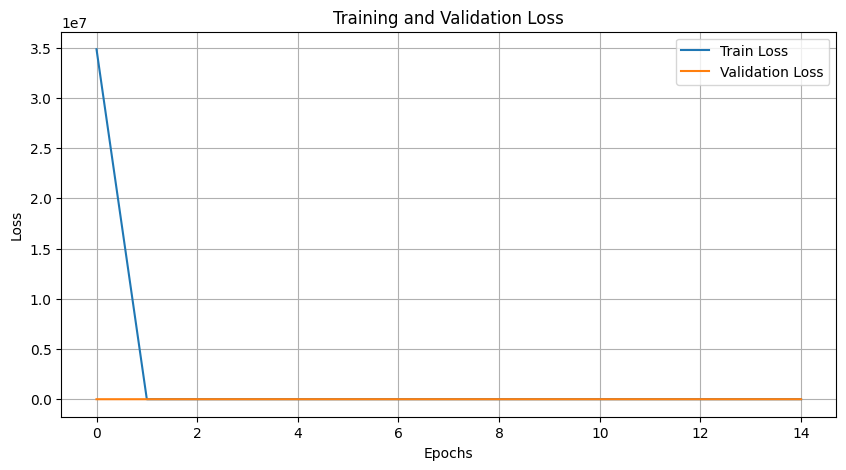

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: bxczku74 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.0065501566844713205
wandb: 	optimizer: SGD


Detener entrenamiento en la época 8, la mejor pérdida fue 0.28012


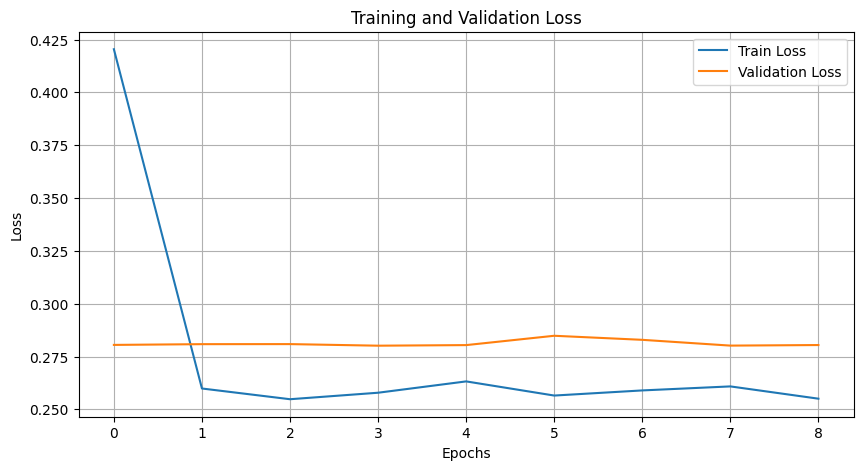

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: km6n3xvr with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.03231537945973031
wandb: 	optimizer: SGD


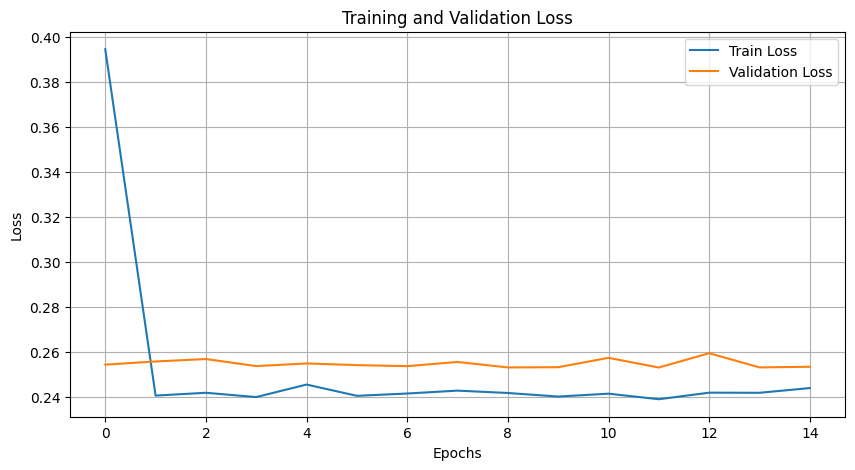

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: qlo6rn8u with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.006527509178898639
wandb: 	optimizer: adam


Detener entrenamiento en la época 5, la mejor pérdida fue 0.25620


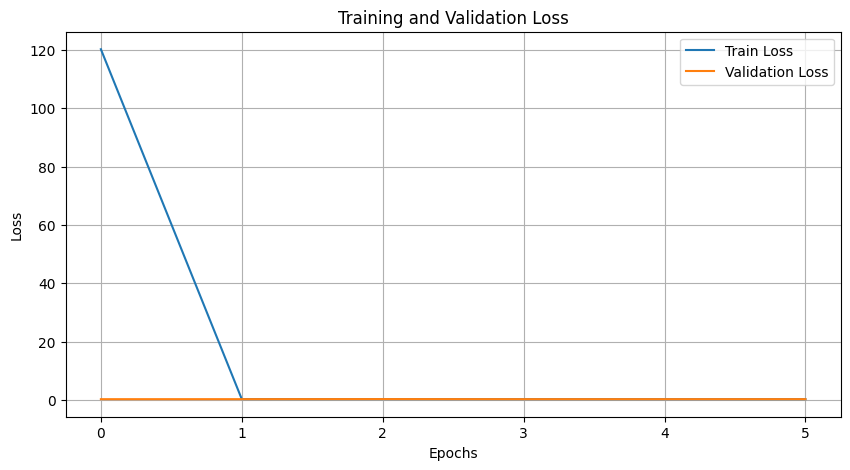

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 2xes5f1e with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0630581526045859
wandb: 	optimizer: adam


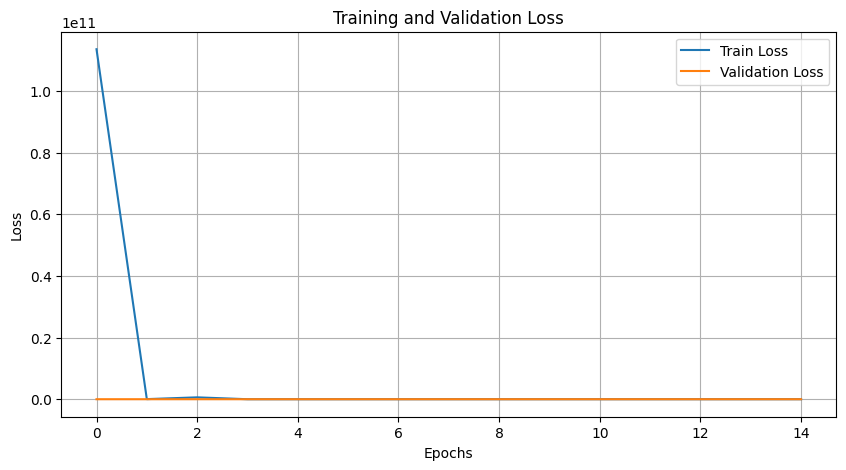

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 1sq3dqlx with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.017120080959981777
wandb: 	optimizer: adam


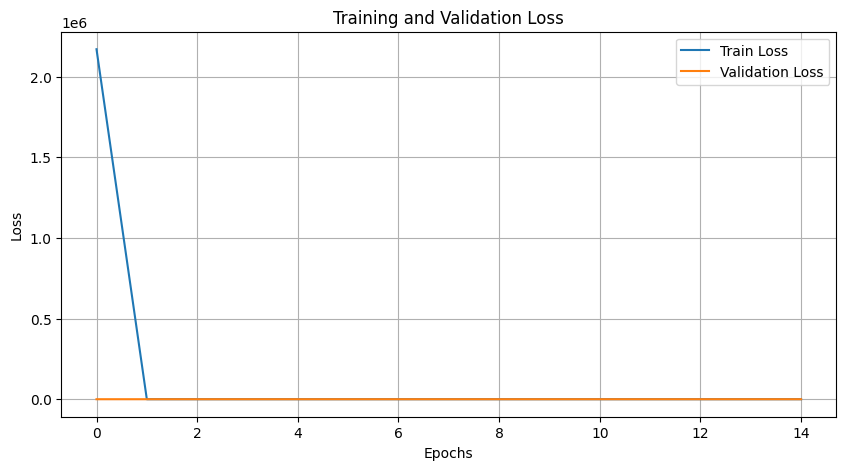

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: ggaew478 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.050384096989000184
wandb: 	optimizer: adam


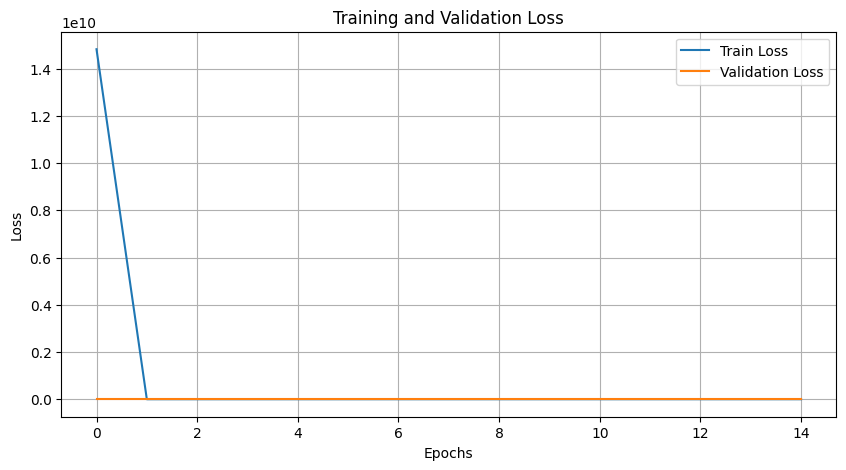

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: vd85fomn with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.031051267326335254
wandb: 	optimizer: SGD


Detener entrenamiento en la época 8, la mejor pérdida fue 0.25483


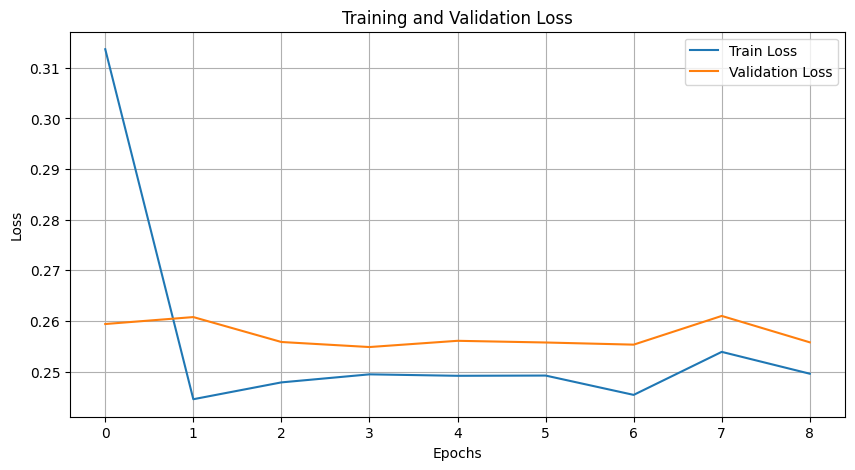

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: e47601i2 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.0873898143277658
wandb: 	optimizer: SGD


Detener entrenamiento en la época 12, la mejor pérdida fue 0.27914


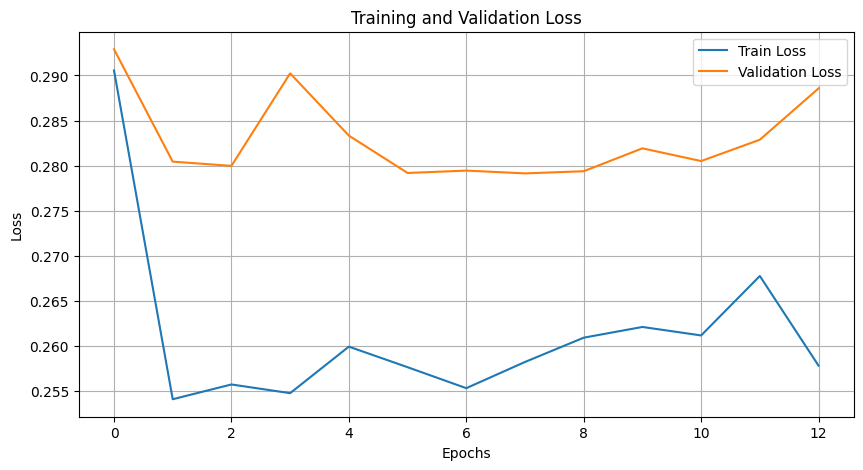

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lx7konrp with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.07144701107285882
wandb: 	optimizer: adam


Detener entrenamiento en la época 8, la mejor pérdida fue 2.88631


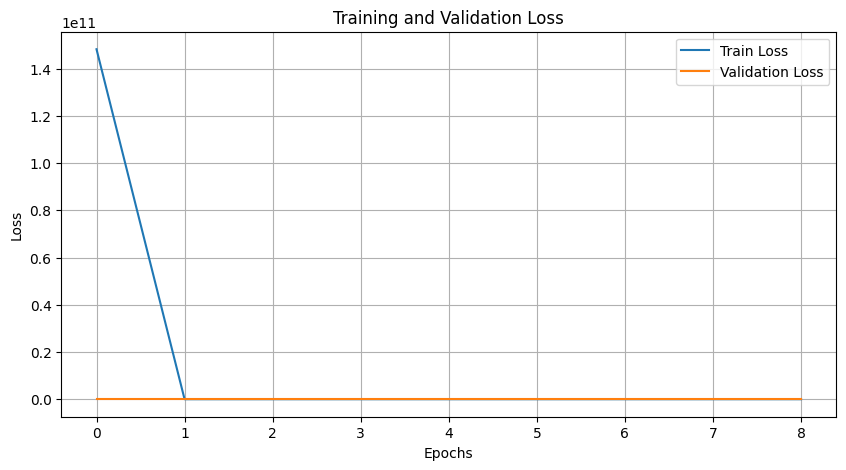

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 1a0v0zd0 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0993000437223435
wandb: 	optimizer: SGD


Detener entrenamiento en la época 5, la mejor pérdida fue 0.25565


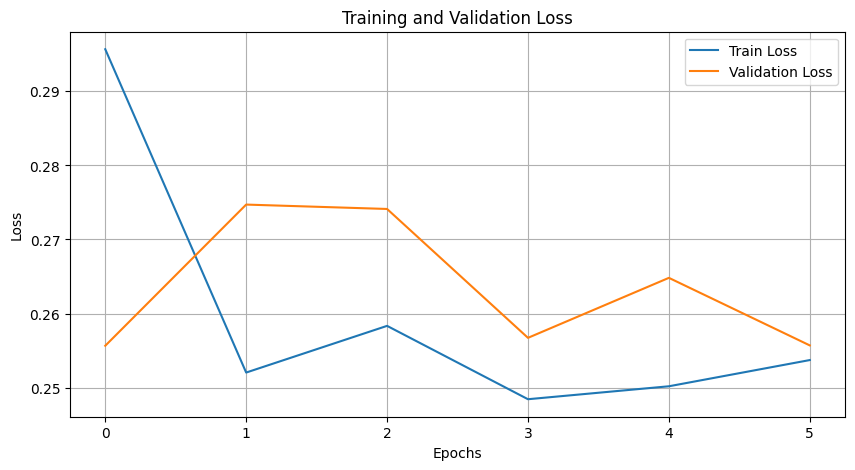

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: fit92uf5 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.054977794669141294
wandb: 	optimizer: SGD


Detener entrenamiento en la época 9, la mejor pérdida fue 0.25334


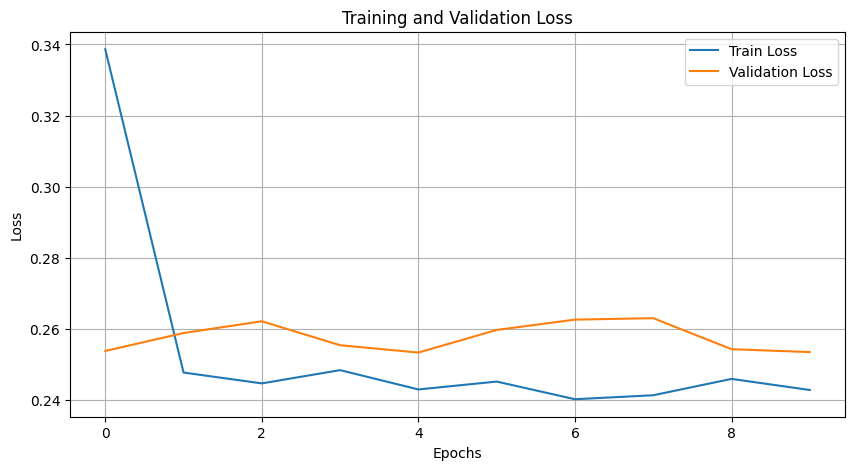

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 97873l87 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0003667845161458794
wandb: 	optimizer: adam


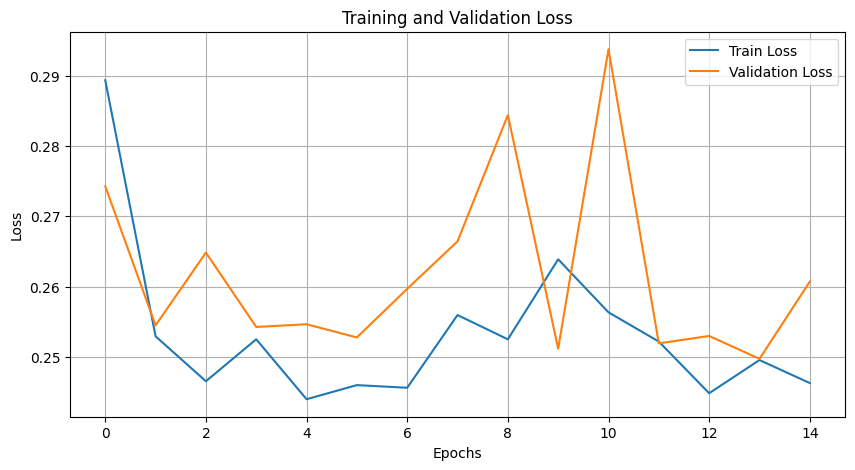

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: sjw6w9sz with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.04036049438905738
wandb: 	optimizer: SGD


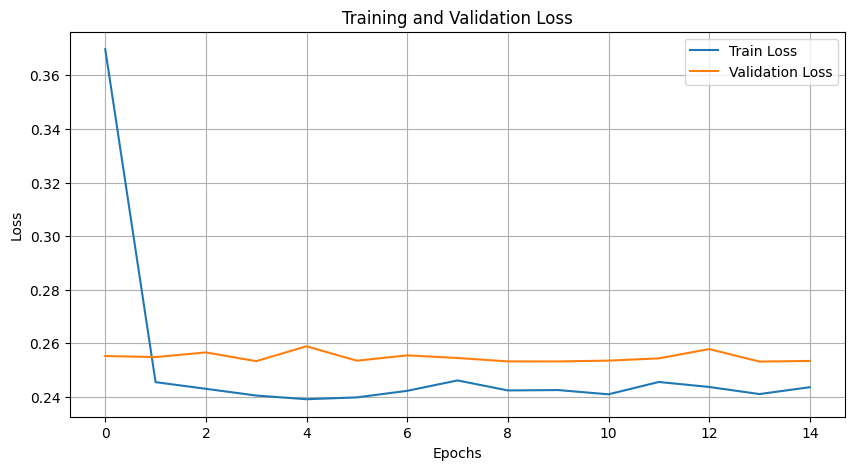

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
wandb.agent(sweep_id, function=sweep_run, count=20)

### EXPERIMENTO 4 - Ajuste fino de hiperparametros

In [ ]:
WANDB_TEAM_NAME = "valeriaeskenazi-universidad-ort-uruguay"
WANDB_PROJECT = "Obligatorio-ML-en-produccion"

# La configuración del sweep: los parámetros que queremos optimizar
sweep_config = {
    "name": "experimento_4_500x500",
    "method": "random", #puede haber tres variantes, se puede ir probando para ver cual es el mejor:
    #grid search: todas las opciones
    #busqueda: ver tipo de correlaciones y le mete mas al que le parezca
    #random: el mas recomendable
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"distribution": "uniform", "max": 0.1, "min": 0}, # tambien se puede poner formulas en vez de hardcoodear
        "batch_size": {"values": [8, 16]},
    },
}

# Crea un nuevo sweep (podríamos usar un sweep existente si ya lo hubiéramos creado)
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: ewwdg3m5
Sweep URL: https://wandb.ai/valeriaeskenazi-universidad-ort-uruguay/Obligatorio-ML-en-produccion/sweeps/ewwdg3m5


In [23]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()

    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_batch_size = config.batch_size


    model = ResNet18_4(3, 2).to(DEVICE)
    train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_5, BS_500_1, batch_size=run_batch_size, num_workers=NUM_WORKERS)
    optimizer = optim.SGD(model.parameters(), lr=run_learning_rate)

    CRITERION = nn.CrossEntropyLoss(weight=weights).to(DEVICE)
    train_errors_ln_nda, val_errors_ln_nda=train(
            model=model,
            optimizer=optimizer,
            criterion=CRITERION,
            train_loader=train_loader,
            val_loader=valid_loader,
            device=DEVICE,
            do_early_stopping=True,
            patience=5,
            epochs=EPOCHS,
            log_fn=wand_log,
            log_every=1,
        )
    plot_taining(train_errors_ln_nda, val_errors_ln_nda)
    model_calassification_report(model, test_loader, DEVICE, 2)


    # Guardar el modelo al final
    torch.save(model.state_dict(), f"Experimento4_500x500{wandb.run.name}.pth")
    wandb.save(f"Experimento4_500x500{wandb.run.name}.pth")
    wandb.finish()


In [21]:
EPOCHS = 30

wandb: Agent Starting Run: hqrbcmlf with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.002325662309679666


Detener entrenamiento en la época 8, la mejor pérdida fue 0.27516


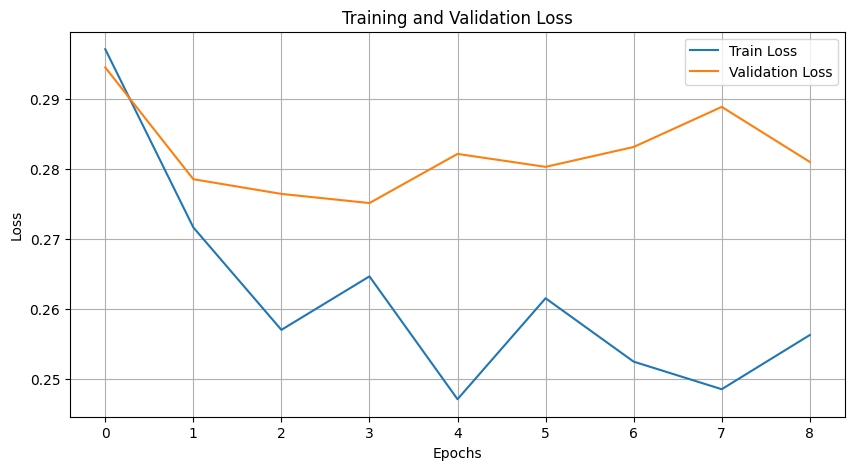

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 7ojeu3kp with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.04136570608635464


Detener entrenamiento en la época 19, la mejor pérdida fue 0.06759


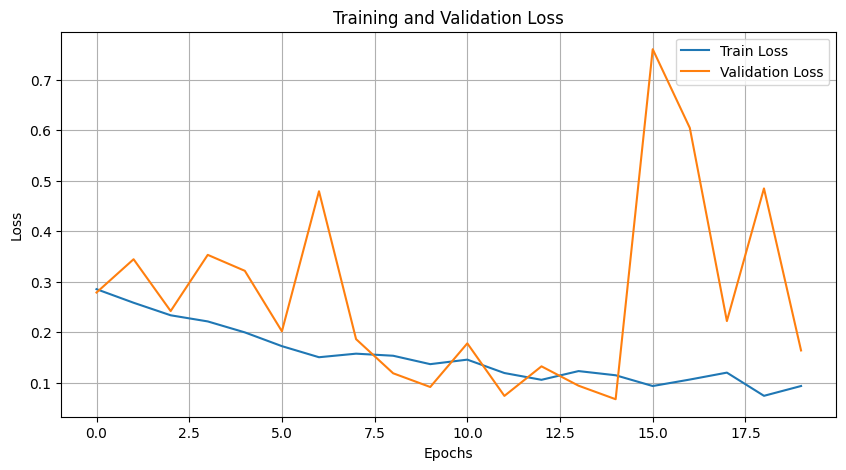

Accuracy: 0.8718

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93        93
           1       1.00      0.38      0.55        24

    accuracy                           0.87       117
   macro avg       0.93      0.69      0.74       117
weighted avg       0.89      0.87      0.85       117



wandb: Agent Starting Run: 45cquk1x with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.01859257251594534


Detener entrenamiento en la época 15, la mejor pérdida fue 0.08705


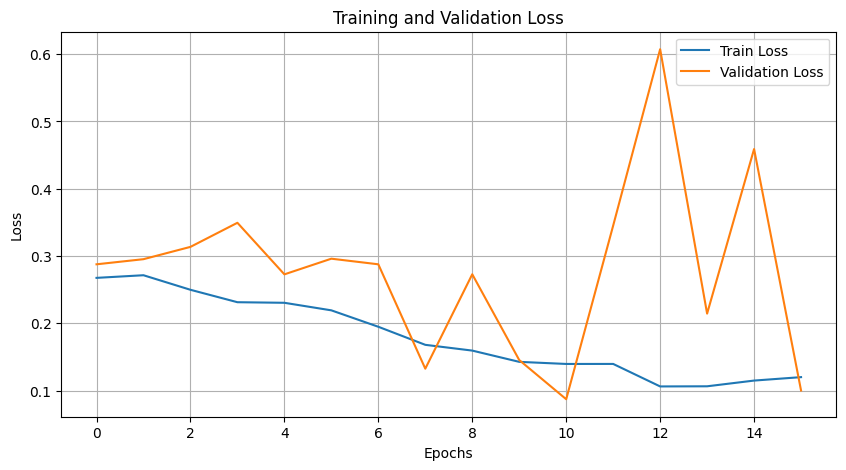

Accuracy: 0.9573

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97        93
           1       0.91      0.88      0.89        24

    accuracy                           0.96       117
   macro avg       0.94      0.93      0.93       117
weighted avg       0.96      0.96      0.96       117



wandb: Agent Starting Run: fbniqsim with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.06143857555737604


Detener entrenamiento en la época 6, la mejor pérdida fue 0.24402


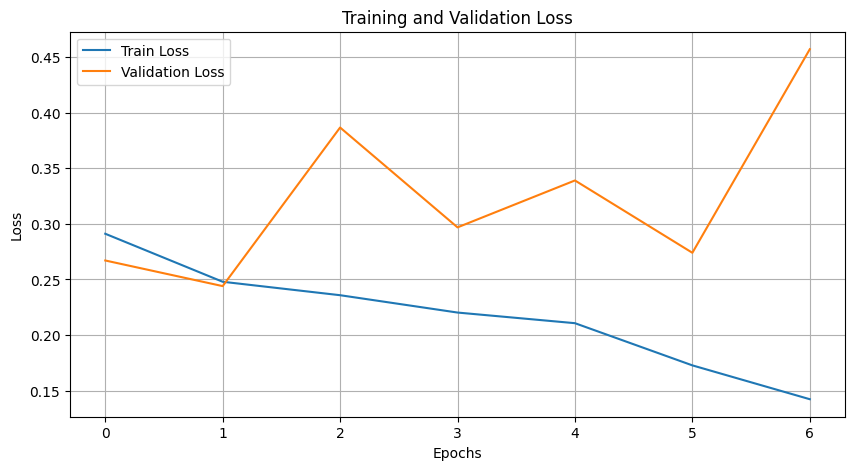

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 4pwebx0o with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.003528906858103054


Detener entrenamiento en la época 8, la mejor pérdida fue 0.27094


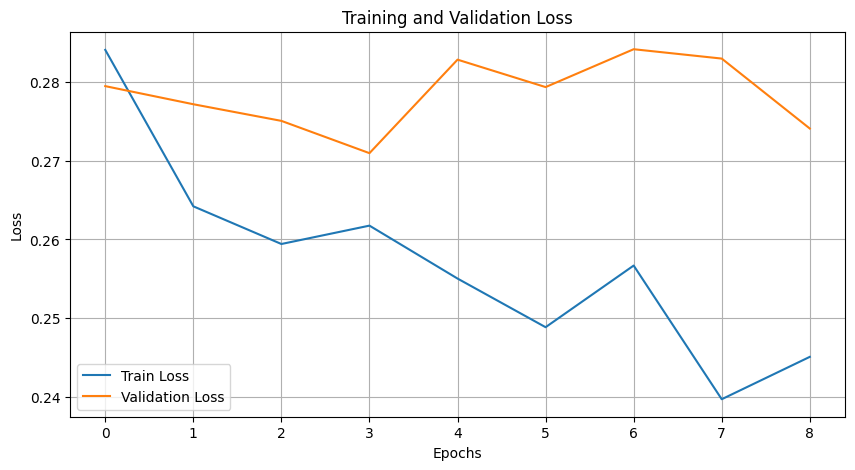

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 2czglfhk with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.010762093988680544


Detener entrenamiento en la época 19, la mejor pérdida fue 0.05164


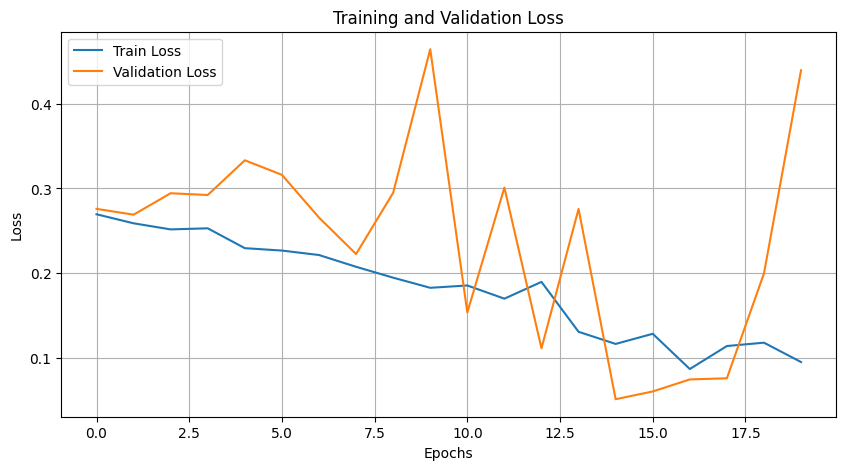

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: xrj5lvjc with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.014755132067574029


Detener entrenamiento en la época 25, la mejor pérdida fue 0.03511


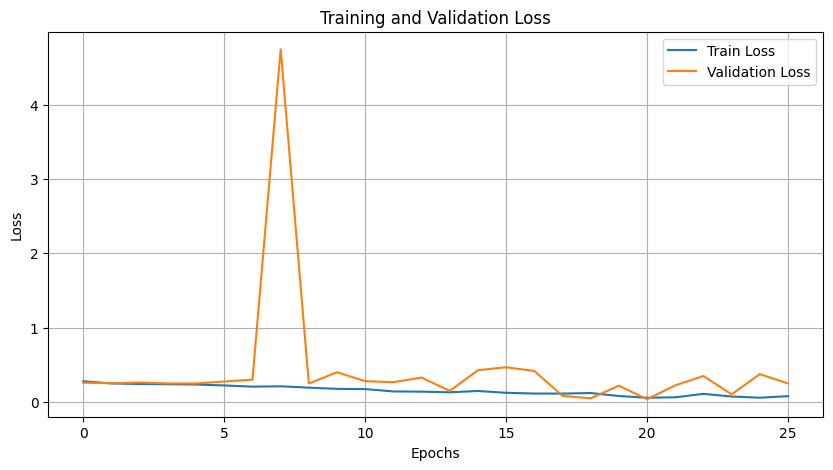

Accuracy: 0.8376

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        93
           1       1.00      0.21      0.34        24

    accuracy                           0.84       117
   macro avg       0.92      0.60      0.63       117
weighted avg       0.87      0.84      0.79       117



wandb: Agent Starting Run: g3l12knv with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.005542763434232323


Detener entrenamiento en la época 13, la mejor pérdida fue 0.24933


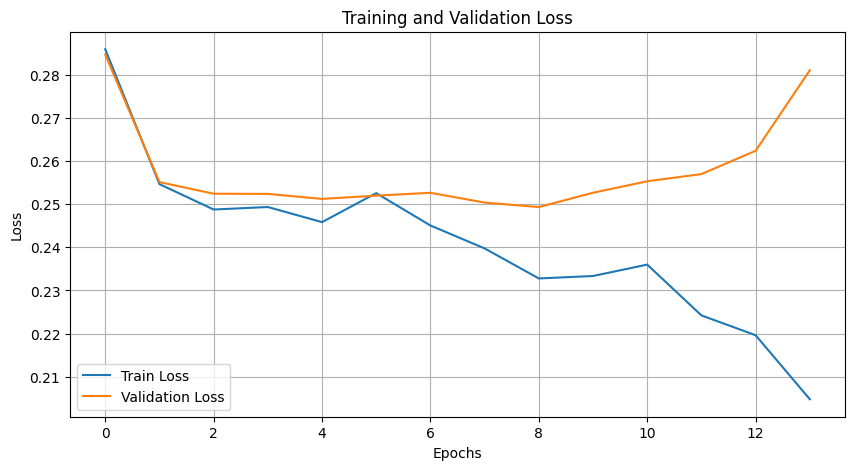

Accuracy: 0.8034

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        93
           1       1.00      0.04      0.08        24

    accuracy                           0.80       117
   macro avg       0.90      0.52      0.48       117
weighted avg       0.84      0.80      0.72       117



wandb: Agent Starting Run: d2c0igmg with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.016991492560839695


Detener entrenamiento en la época 28, la mejor pérdida fue 0.04180


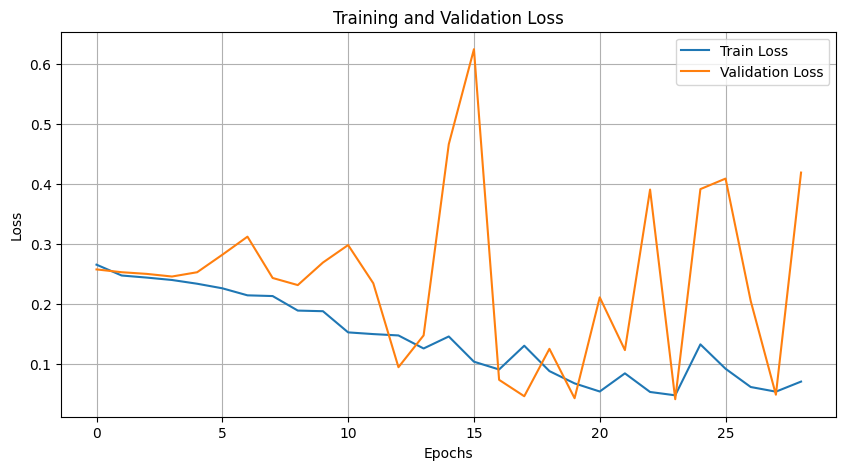

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 4wk53iaq with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.021838385464233036


Detener entrenamiento en la época 12, la mejor pérdida fue 0.19486


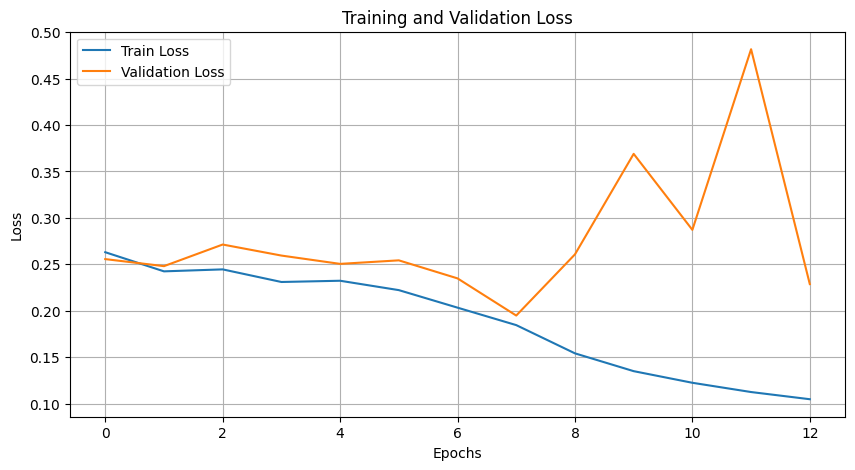

Accuracy: 0.8205

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90        93
           1       1.00      0.12      0.22        24

    accuracy                           0.82       117
   macro avg       0.91      0.56      0.56       117
weighted avg       0.85      0.82      0.76       117



wandb: Agent Starting Run: lc2wu4al with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.03720797561112121


Detener entrenamiento en la época 9, la mejor pérdida fue 0.20701


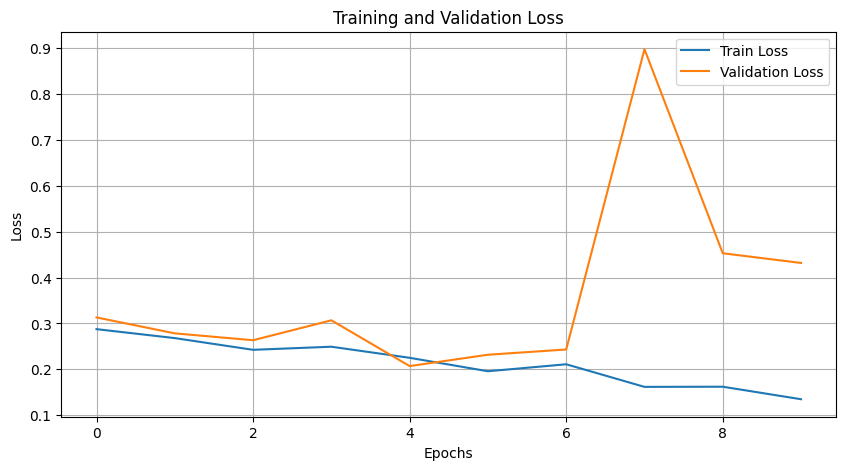

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 47dn1toi with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.03221736311206376


Detener entrenamiento en la época 12, la mejor pérdida fue 0.07613


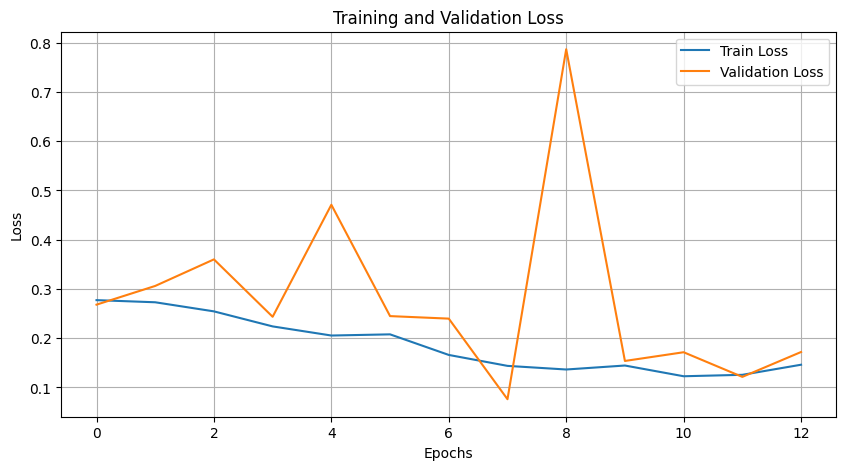

Accuracy: 0.8462

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91        93
           1       1.00      0.25      0.40        24

    accuracy                           0.85       117
   macro avg       0.92      0.62      0.66       117
weighted avg       0.87      0.85      0.81       117



wandb: Agent Starting Run: z3f0q7qt with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.03570751540250427


Detener entrenamiento en la época 28, la mejor pérdida fue 0.03194


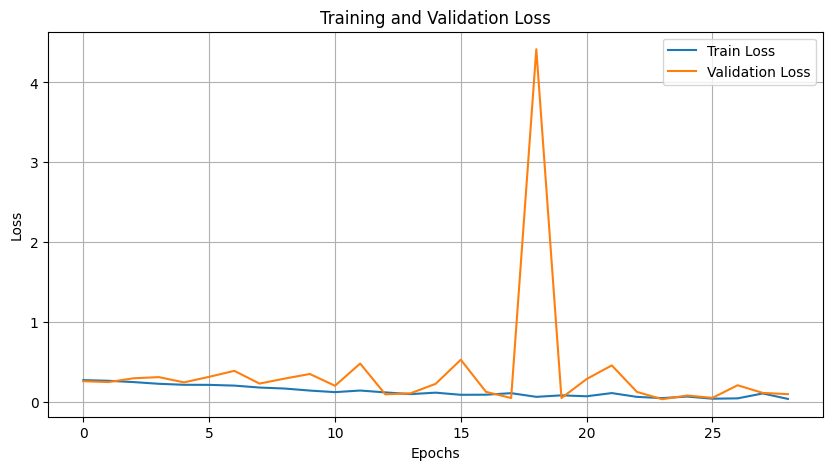

Accuracy: 0.8974

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        93
           1       1.00      0.50      0.67        24

    accuracy                           0.90       117
   macro avg       0.94      0.75      0.80       117
weighted avg       0.91      0.90      0.88       117



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e4r8xm9r with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.02525307618153


Detener entrenamiento en la época 19, la mejor pérdida fue 0.07601


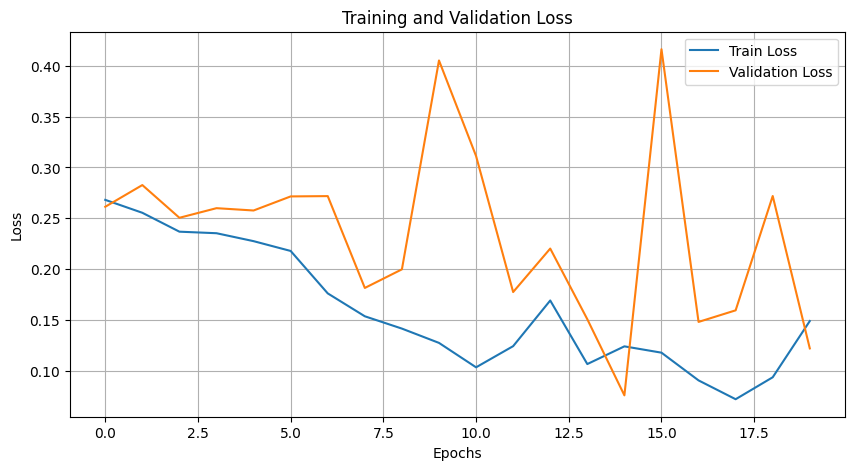

Accuracy: 0.8632

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92        93
           1       1.00      0.33      0.50        24

    accuracy                           0.86       117
   macro avg       0.93      0.67      0.71       117
weighted avg       0.88      0.86      0.83       117



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1pbfpq4o with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.04269765178326266


Detener entrenamiento en la época 22, la mejor pérdida fue 0.04021


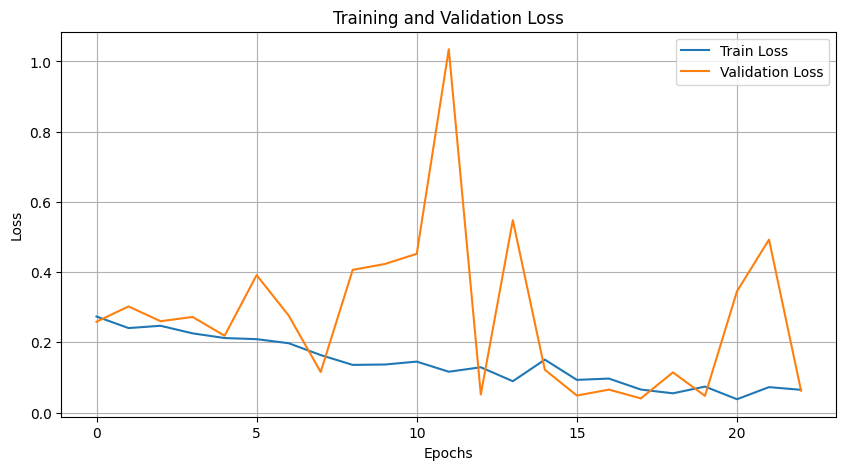

Accuracy: 0.9145

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        93
           1       1.00      0.58      0.74        24

    accuracy                           0.91       117
   macro avg       0.95      0.79      0.84       117
weighted avg       0.92      0.91      0.91       117



wandb: Agent Starting Run: vbpv2675 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.03756275887096963


Detener entrenamiento en la época 6, la mejor pérdida fue 0.26195


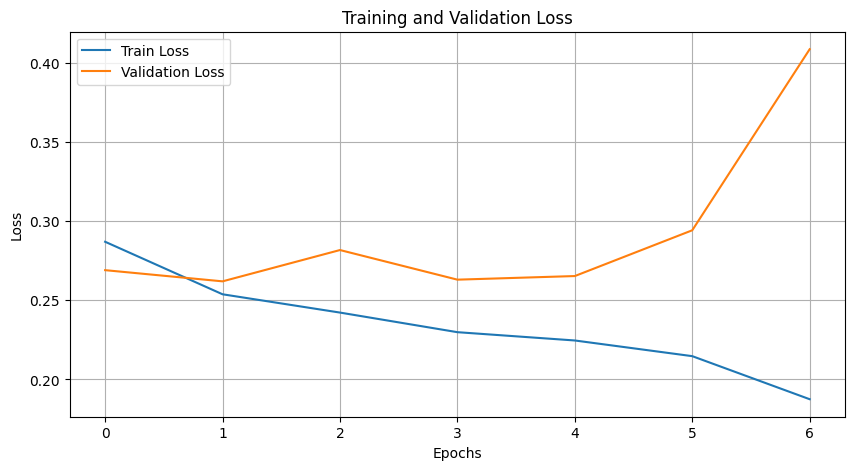

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 4aet5ofv with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.06317822628919396


Detener entrenamiento en la época 11, la mejor pérdida fue 0.10556


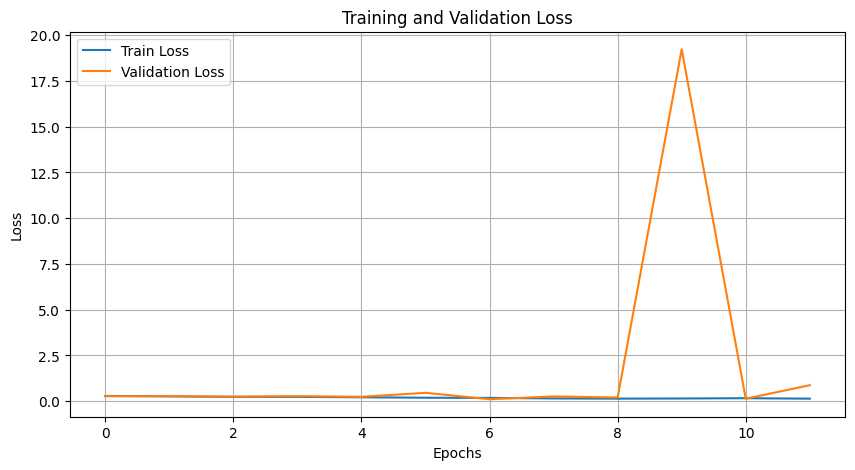

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: djmso1nm with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.00982741154828326


wandb: ERROR Run djmso1nm errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 302, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipython-input-42-637266908.py", line 22, in sweep_run
wandb: ERROR     train_errors_ln_nda, val_errors_ln_nda=train(
wandb: ERROR                                            ^^^^^^
wandb: ERROR   File "/content/utils.py", line 102, in train
wandb: ERROR     for x, y in train_loader:
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
wandb: ERROR     data = self._next_data()
wandb: ERROR            ^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1480, in _next_data
wandb: ERROR     return self._process_data(data)
wandb: ERROR            ^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/d

wandb: ERROR Run 7tfo990f errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 302, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipython-input-42-637266908.py", line 22, in sweep_run
wandb: ERROR     train_errors_ln_nda, val_errors_ln_nda=train(
wandb: ERROR                                            ^^^^^^
wandb: ERROR   File "/content/utils.py", line 102, in train
wandb: ERROR     for x, y in train_loader:
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
wandb: ERROR     data = self._next_data()
wandb: ERROR            ^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1480, in _next_data
wandb: ERROR     return self._process_data(data)
wandb: ERROR            ^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/d

wandb: ERROR Run d1i2afyv errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 302, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipython-input-42-637266908.py", line 22, in sweep_run
wandb: ERROR     train_errors_ln_nda, val_errors_ln_nda=train(
wandb: ERROR                                            ^^^^^^
wandb: ERROR   File "/content/utils.py", line 102, in train
wandb: ERROR     for x, y in train_loader:
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
wandb: ERROR     data = self._next_data()
wandb: ERROR            ^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1480, in _next_data
wandb: ERROR     return self._process_data(data)
wandb: ERROR            ^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/d

In [ ]:
wandb.agent(sweep_id, function=sweep_run, count=20)

Continuamos con las partidas que no corrieron

wandb: Agent Starting Run: szbyj7az with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.00948198630908227


Detener entrenamiento en la época 29, la mejor pérdida fue 0.03032


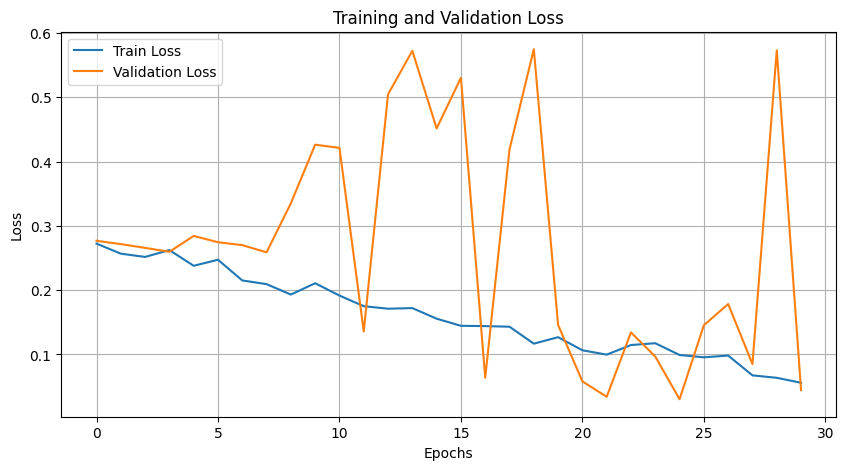

Accuracy: 0.9145

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95        93
           1       0.94      0.62      0.75        24

    accuracy                           0.91       117
   macro avg       0.92      0.81      0.85       117
weighted avg       0.92      0.91      0.91       117



wandb: Agent Starting Run: lly6jouq with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.004273086787124181


Detener entrenamiento en la época 6, la mejor pérdida fue 0.27725


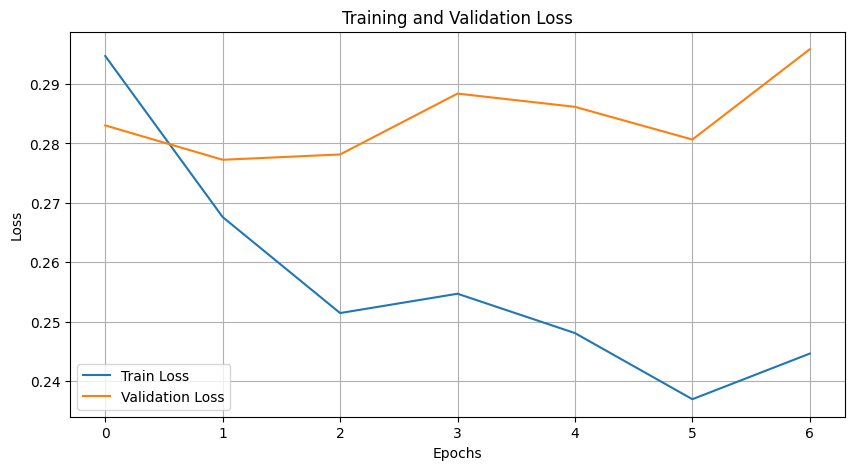

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 6dymcpix with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0222314532948799


Detener entrenamiento en la época 20, la mejor pérdida fue 0.04689


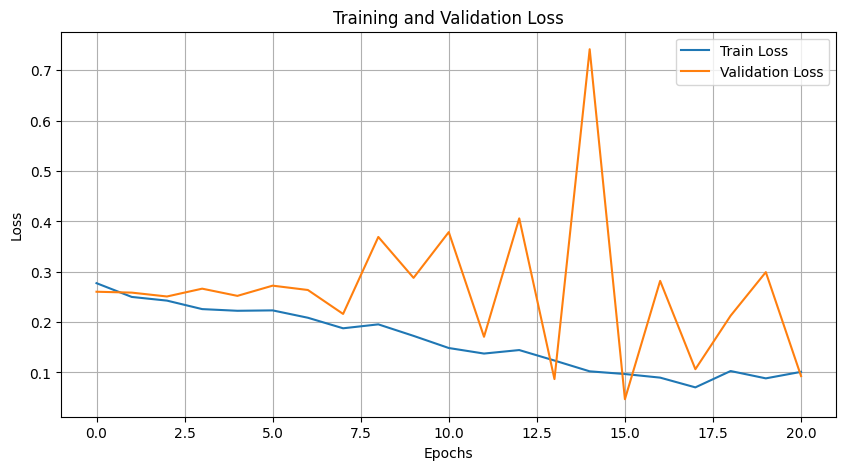

Accuracy: 0.8889

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93        93
           1       1.00      0.46      0.63        24

    accuracy                           0.89       117
   macro avg       0.94      0.73      0.78       117
weighted avg       0.90      0.89      0.87       117



wandb: Agent Starting Run: 1m611whs with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0172658734236009


Detener entrenamiento en la época 22, la mejor pérdida fue 0.06912


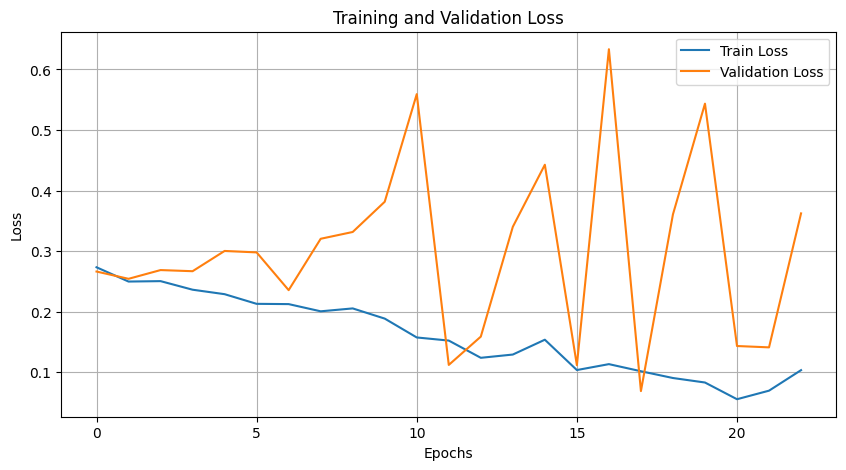

Accuracy: 0.8034

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        93
           1       1.00      0.04      0.08        24

    accuracy                           0.80       117
   macro avg       0.90      0.52      0.48       117
weighted avg       0.84      0.80      0.72       117



wandb: Agent Starting Run: bgj2dvky with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.02319180223557157


Detener entrenamiento en la época 6, la mejor pérdida fue 0.24740


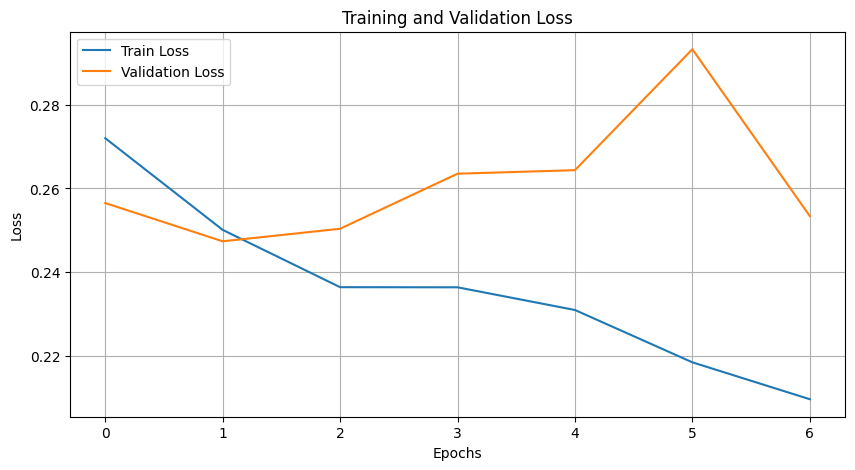

Accuracy: 0.8034

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        93
           1       1.00      0.04      0.08        24

    accuracy                           0.80       117
   macro avg       0.90      0.52      0.48       117
weighted avg       0.84      0.80      0.72       117



wandb: Agent Starting Run: yd6maxj8 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.00044489183178147984


Detener entrenamiento en la época 26, la mejor pérdida fue 0.27696


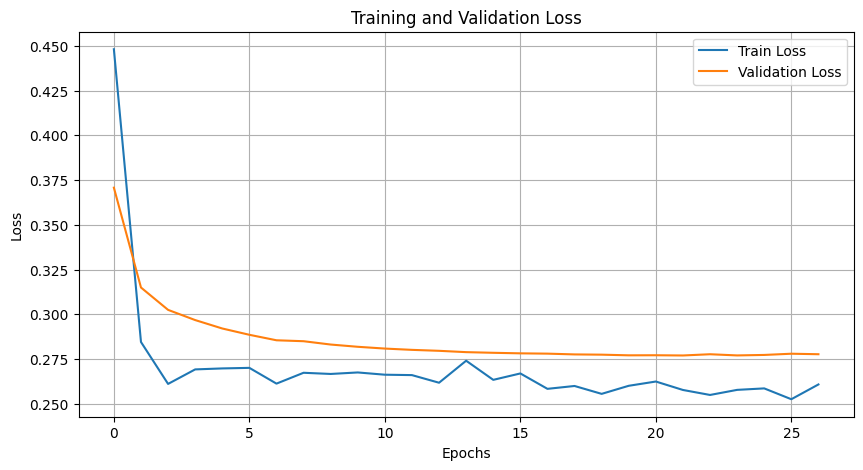

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 50lpfxs3 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.04776414699638059


Detener entrenamiento en la época 8, la mejor pérdida fue 0.23857


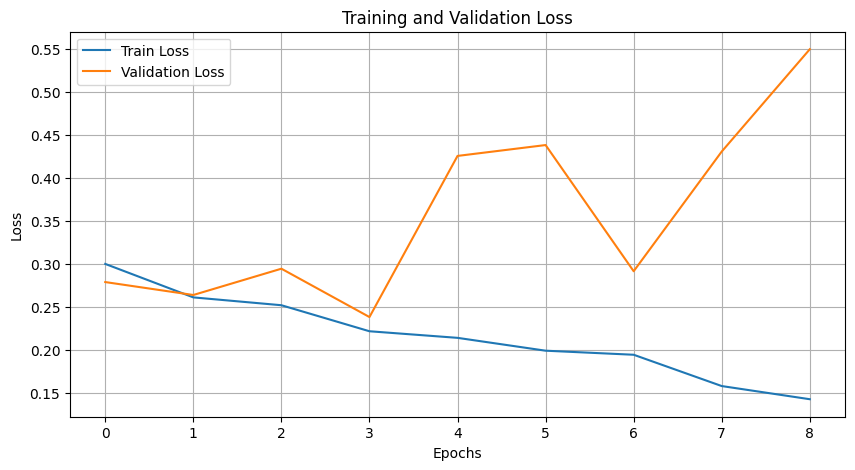

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 8znzwgwy with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.02370662475570029


Detener entrenamiento en la época 5, la mejor pérdida fue 0.25754


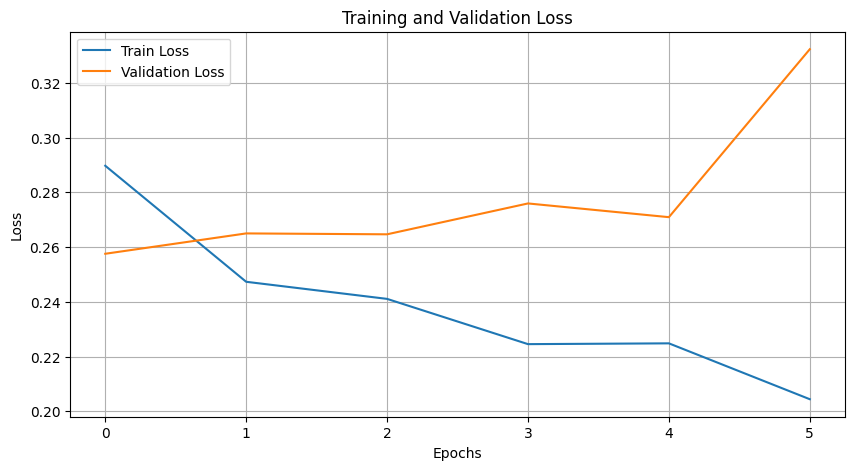

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: docuym7x with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.04305762336189933


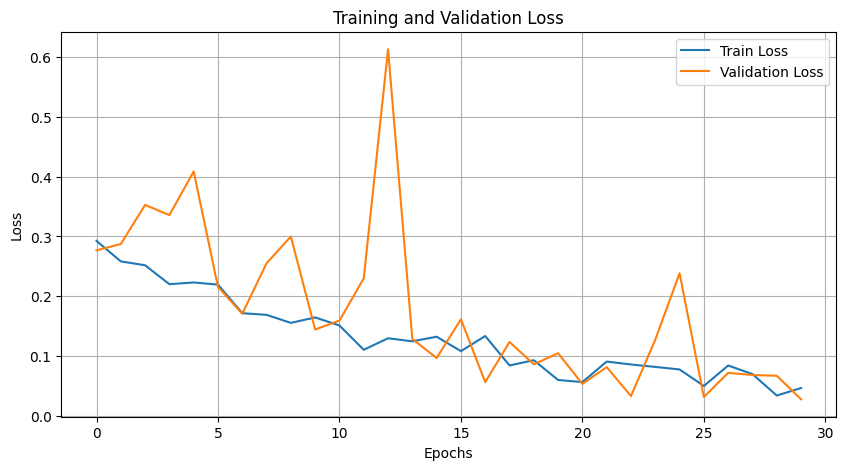

Accuracy: 0.9744

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        93
           1       1.00      0.88      0.93        24

    accuracy                           0.97       117
   macro avg       0.98      0.94      0.96       117
weighted avg       0.98      0.97      0.97       117



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mjf5ygji with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.09474712637106396


Detener entrenamiento en la época 17, la mejor pérdida fue 0.15631


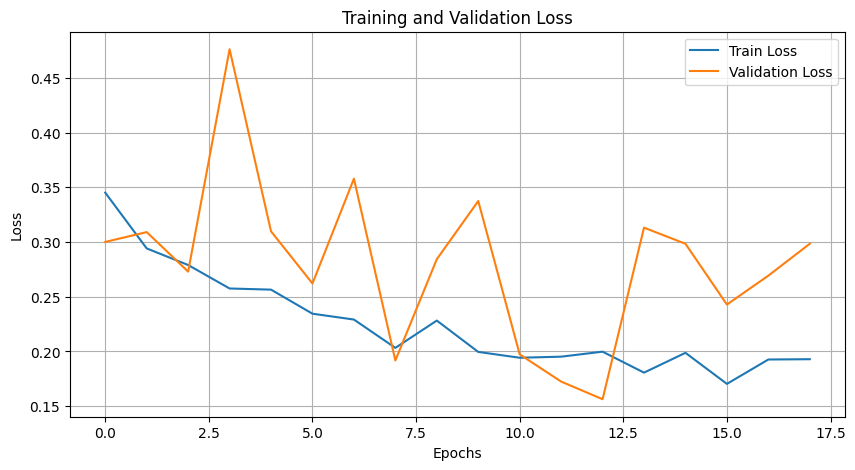

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: v5d1jn4w with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.01620291813388516


Detener entrenamiento en la época 6, la mejor pérdida fue 0.24652


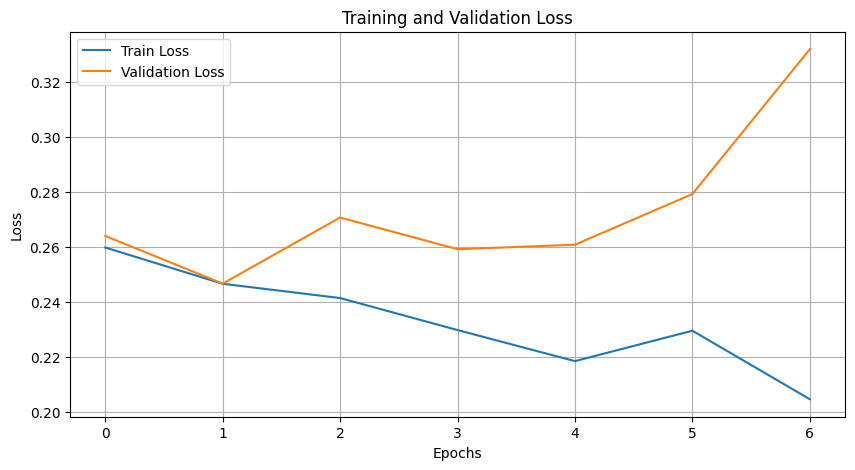

Accuracy: 0.8205

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90        93
           1       0.80      0.17      0.28        24

    accuracy                           0.82       117
   macro avg       0.81      0.58      0.59       117
weighted avg       0.82      0.82      0.77       117



wandb: Agent Starting Run: 1j4y5yor with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.028352846426000142


Detener entrenamiento en la época 21, la mejor pérdida fue 0.03392


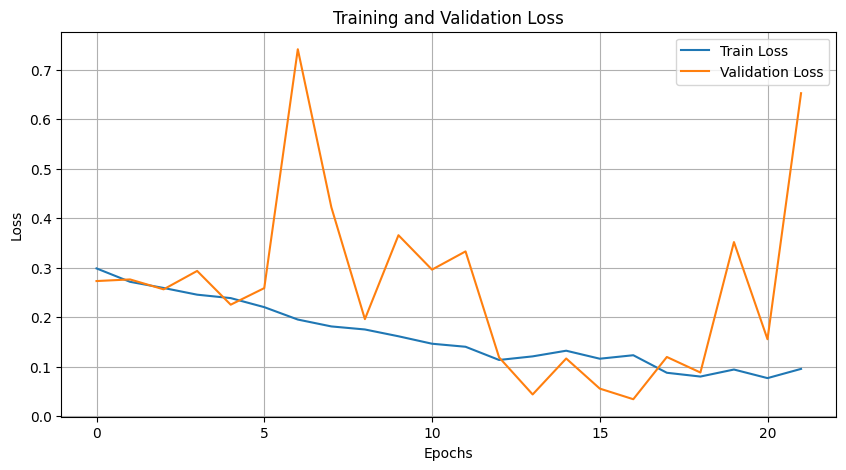

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: bwp1bp6r with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.03703533065991937


Detener entrenamiento en la época 22, la mejor pérdida fue 0.02919


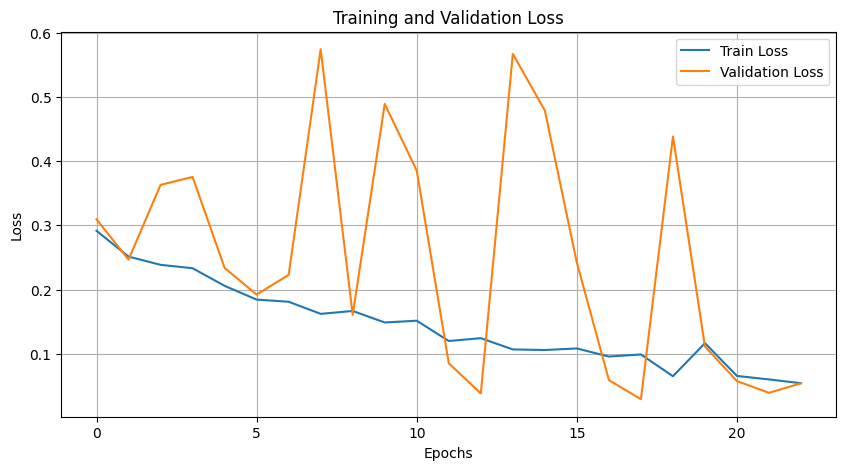

Accuracy: 0.9231

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95        93
           1       0.94      0.67      0.78        24

    accuracy                           0.92       117
   macro avg       0.93      0.83      0.87       117
weighted avg       0.92      0.92      0.92       117



wandb: Agent Starting Run: zjt5gfpl with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.024419707674948887


Detener entrenamiento en la época 21, la mejor pérdida fue 0.05049


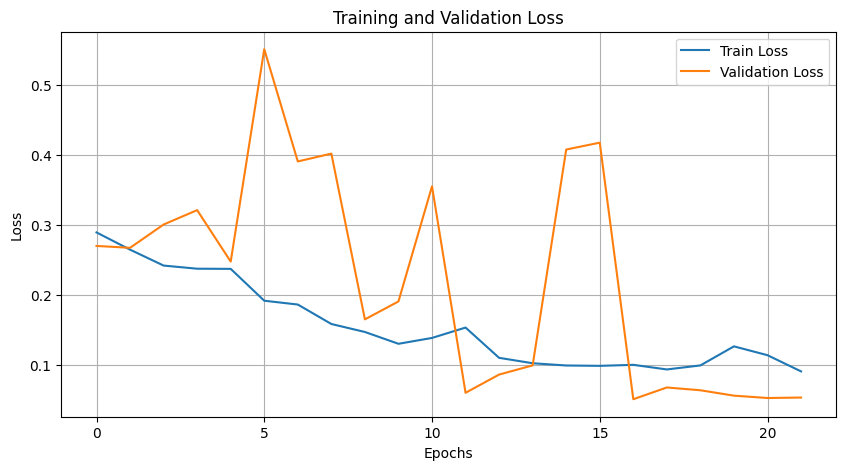

Accuracy: 0.9573

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        93
           1       1.00      0.79      0.88        24

    accuracy                           0.96       117
   macro avg       0.97      0.90      0.93       117
weighted avg       0.96      0.96      0.96       117



wandb: Agent Starting Run: fhamu5mc with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.09804134463337266


Detener entrenamiento en la época 9, la mejor pérdida fue 0.19642


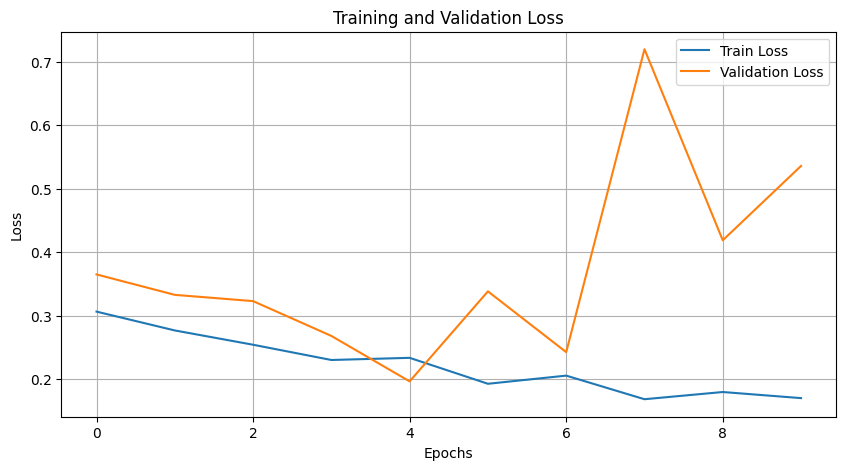

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: 25xmc1iw with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.053167656444957315


Detener entrenamiento en la época 8, la mejor pérdida fue 0.21709


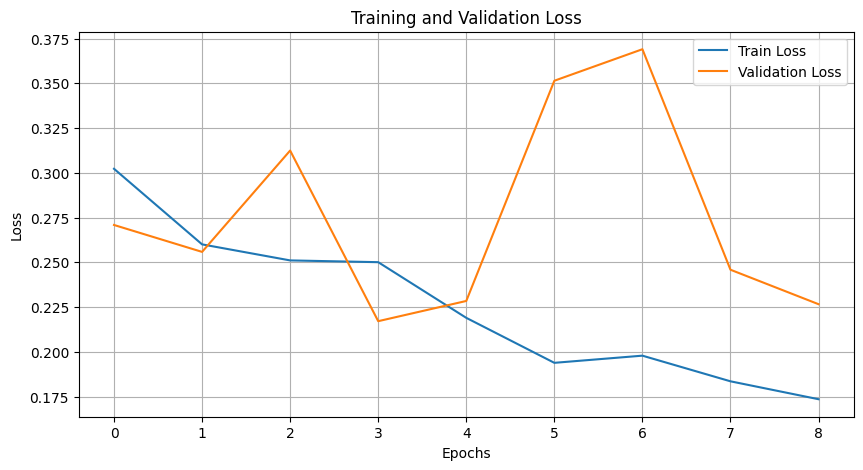

Accuracy: 0.8291

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90        93
           1       1.00      0.17      0.29        24

    accuracy                           0.83       117
   macro avg       0.91      0.58      0.59       117
weighted avg       0.86      0.83      0.78       117



wandb: Agent Starting Run: mjntl71q with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.03616564710393673


Detener entrenamiento en la época 7, la mejor pérdida fue 0.24036


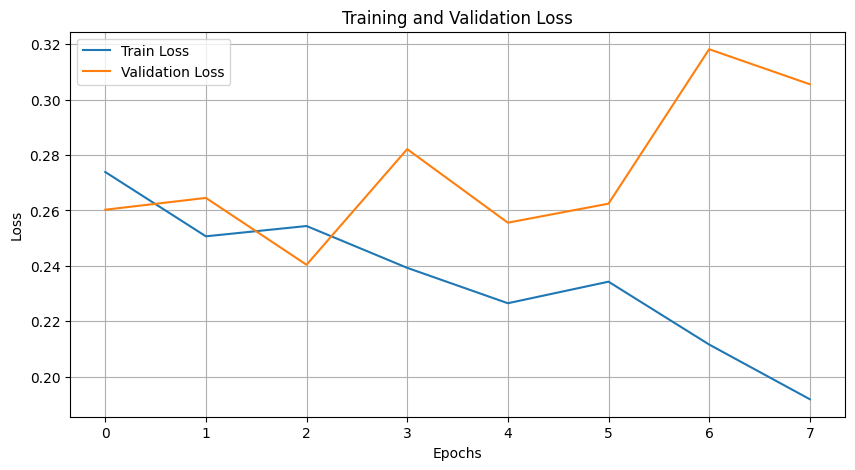

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


wandb: Agent Starting Run: gehzgwf5 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.06958266565083356


Detener entrenamiento en la época 15, la mejor pérdida fue 0.06067


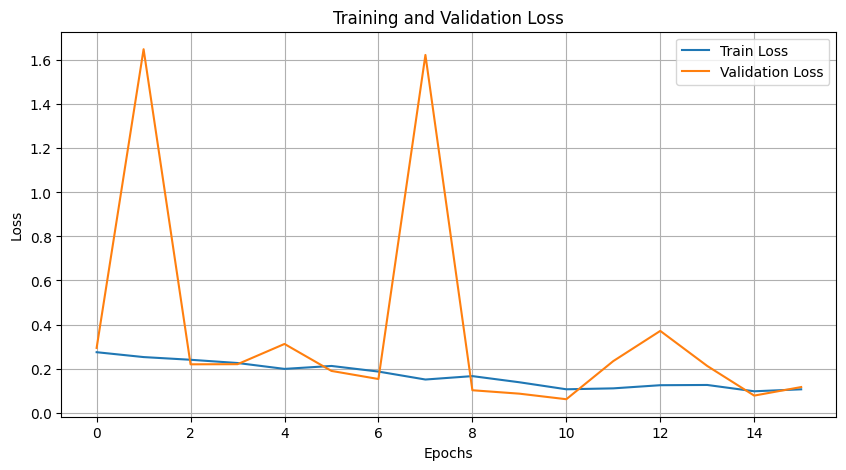

Accuracy: 0.8803

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93        93
           1       1.00      0.42      0.59        24

    accuracy                           0.88       117
   macro avg       0.93      0.71      0.76       117
weighted avg       0.90      0.88      0.86       117



wandb: Agent Starting Run: y1nll54i with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0745744759976211


Detener entrenamiento en la época 26, la mejor pérdida fue 0.05166


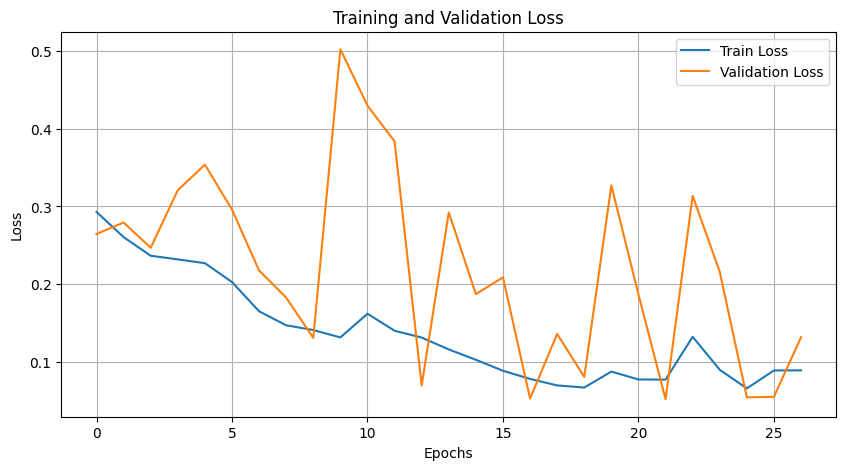

Accuracy: 0.8803

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93        93
           1       1.00      0.42      0.59        24

    accuracy                           0.88       117
   macro avg       0.93      0.71      0.76       117
weighted avg       0.90      0.88      0.86       117



wandb: Agent Starting Run: pf7g84qy with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.016334882027796205


Detener entrenamiento en la época 6, la mejor pérdida fue 0.24558


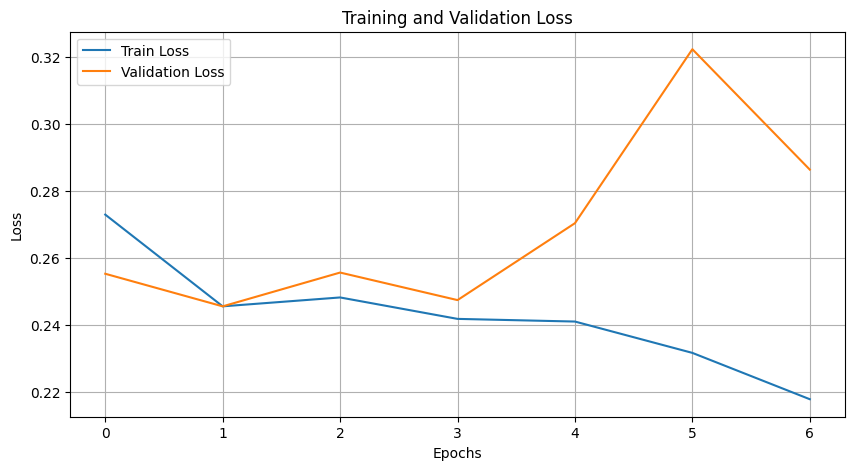

Accuracy: 0.7949

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        93
           1       0.00      0.00      0.00        24

    accuracy                           0.79       117
   macro avg       0.40      0.50      0.44       117
weighted avg       0.63      0.79      0.70       117



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
wandb.agent(
    "ewwdg3m5",
    function=sweep_run,
    count=20,
    project="Obligatorio-ML-en-produccion",
    entity="valeriaeskenazi-universidad-ort-uruguay"
)


El mejor modelo desarrollado fue:
https://wandb.ai/valeriaeskenazi-universidad-ort-uruguay/Obligatorio-ML-en-produccion/runs/45cquk1x

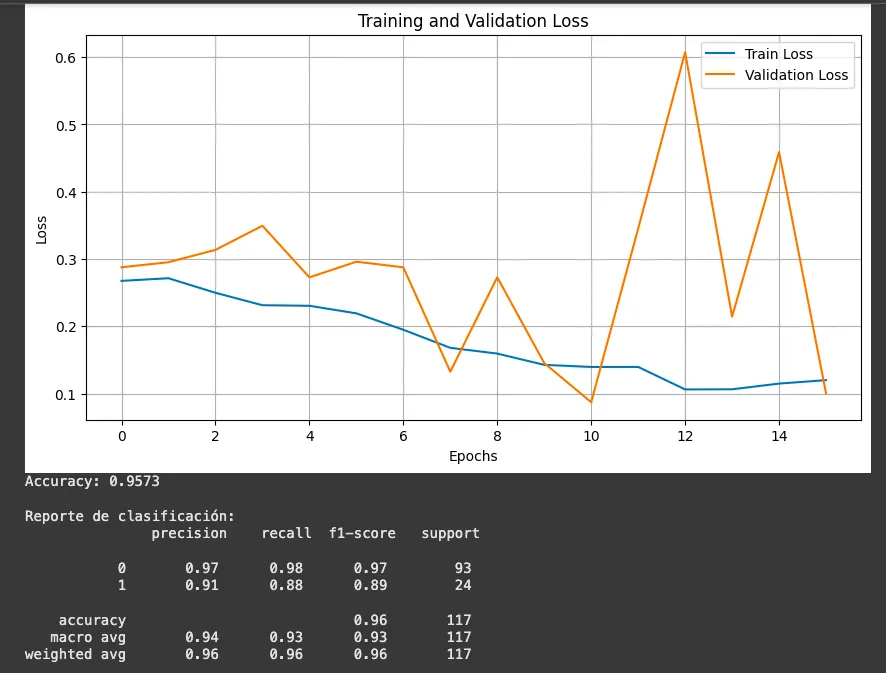

model = ResNet18_4(3, 2).to(DEVICE)

AG_500_5 = T.Compose([
    T.Resize((500, 500)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
])

wandb: 	batch_size: 8
wandb: 	learning_rate: 0.01859257251594534

## Prunning

In [26]:
# SOLUCIÓN COMPLETA - Código corregido

import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.optim as optim
from torch.utils.data import DataLoader
import copy

# 1. DEFINIR DEVICE CORRECTAMENTE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando device: {device}")

# 2. CARGAR EL MODELO
#model = torch.load('Experimento4_500x500noble-sweep-6.pth', map_location=device)
#print("Modelo cargado exitosamente")

# 3. FUNCIÓN DE PRUNING CORREGIDA
def proceso_completo_pruning(modelo_original, train_loader, val_loader, device):
    """
    Proceso completo de pruning paso a paso - VERSIÓN CORREGIDA
    """
    print("=== PROCESO DE PRUNING COMPLETO ===")

    # 1. Evaluar modelo original
    accuracy_original = evaluar_modelo(modelo_original, val_loader, device)
    print(f"1. Accuracy original: {accuracy_original:.2f}%")

    # 2. Hacer copia del modelo
    modelo_copia = copy.deepcopy(modelo_original)

    # 3. Aplicar pruning
    modelo_podado = aplicar_pruning_simple(modelo_copia, porcentaje_eliminar=0.3)

    # 4. Evaluar después del pruning
    accuracy_podado = evaluar_modelo(modelo_podado, val_loader, device)
    print(f"2. Accuracy después del pruning: {accuracy_podado:.2f}%")
    print(f"   Pérdida de accuracy: {accuracy_original - accuracy_podado:.2f}%")

    # 5. Fine-tuning si es necesario
    if accuracy_original - accuracy_podado > 2.0:  # Si perdió más de 2%
        print("3. Accuracy bajó mucho, aplicando fine-tuning...")
        modelo_podado = fine_tuning_rapido(modelo_podado, train_loader, device=device)
        accuracy_final = evaluar_modelo(modelo_podado, val_loader, device)
        print(f"   Accuracy después del fine-tuning: {accuracy_final:.2f}%")
    else:
        print("3. Accuracy se mantuvo bien, no necesita fine-tuning")
        accuracy_final = accuracy_podado

    # 6. Hacer permanente
    modelo_final = hacer_permanente(modelo_podado)

    # 7. Calcular sparsity final
    sparsity_final = calcular_sparsity(modelo_final)

    print(f"\n=== RESULTADOS FINALES ===")
    print(f"Accuracy original: {accuracy_original:.2f}%")
    print(f"Accuracy final: {accuracy_final:.2f}%")
    print(f"Parámetros eliminados: {sparsity_final*100:.1f}%")

    return modelo_final

def aplicar_pruning_simple(model, porcentaje_eliminar=0.3):
    """
    Aplica pruning a un modelo ya entrenado
    """
    print(f"Aplicando pruning: eliminando {porcentaje_eliminar*100}% de parámetros")

    # Obtener todas las capas que se pueden podar
    capas_para_podar = []

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            capas_para_podar.append((module, 'weight'))

    # Aplicar pruning basado en magnitud
    prune.global_unstructured(
        capas_para_podar,
        pruning_method=prune.L1Unstructured,
        amount=porcentaje_eliminar,
    )

    print(f"Pruning aplicado. Parámetros eliminados: {calcular_sparsity(model)*100:.1f}%")
    return model

def evaluar_modelo(model, dataloader, device):
    """
    Evalúa accuracy del modelo
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def fine_tuning_rapido(model, train_loader, num_epochs=3, lr=0.0001, device='cuda'):
    """
    Fine-tuning rápido para recuperar accuracy perdida
    """
    print(f"Haciendo fine-tuning por {num_epochs} épocas...")

    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Solo algunos batches para no demorar
            if i > 50:  # Ajusta según tu dataset
                break

        print(f"Época {epoch+1}/{num_epochs}, Loss: {running_loss/(i+1):.4f}")

    return model

def hacer_permanente(model):
    """
    Hace permanente el pruning
    """
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            try:
                prune.remove(module, 'weight')
            except:
                pass
    return model

def calcular_sparsity(model):
    """
    Función corregida que calcula sparsity correctamente
    """
    total = 0
    zeros = 0

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            # Obtener parámetros del peso
            weight = module.weight
            total += weight.numel()
            zeros += (weight == 0).sum().item()

    return zeros / total if total > 0 else 0



Usando device: cuda


In [27]:
train_loader, valid_loader, test_loader = get_data_loaders_EX2(train_df, val_df, test_df, BS_500_1, AG_500_5, BS_500_1, batch_size=8, num_workers=NUM_WORKERS)

In [29]:
state_dict = torch.load('Experimento4_500x500noble-sweep-6.pth', map_location=device)

# Instantiate the model and load the state dictionary
model_instance = ResNet18_4(3, 2).to(device)
model_instance.load_state_dict(state_dict)

# Aplicar pruning
modelo_podado = proceso_completo_pruning(
    model_instance,
    train_loader,  # Necesitas definir esto
    valid_loader,    # Necesitas definir esto
    device=device
)

# Guardar el modelo podado
torch.save(modelo_podado.state_dict(), 'ResNet18_podado.pth')
print("Modelo podado guardado como 'ResNet18_podado.pth'")

=== PROCESO DE PRUNING COMPLETO ===
1. Accuracy original: 95.73%
Aplicando pruning: eliminando 30.0% de parámetros
Pruning aplicado. Parámetros eliminados: 30.0%
2. Accuracy después del pruning: 93.16%
   Pérdida de accuracy: 2.56%
3. Accuracy bajó mucho, aplicando fine-tuning...
Haciendo fine-tuning por 3 épocas...
Época 1/3, Loss: 0.2518
Época 2/3, Loss: 0.1611
Época 3/3, Loss: 0.1904
   Accuracy después del fine-tuning: 97.44%

=== RESULTADOS FINALES ===
Accuracy original: 95.73%
Accuracy final: 97.44%
Parámetros eliminados: 30.0%
Modelo podado guardado como 'ResNet18_podado.pth'


In [30]:
state_dict = torch.load('ResNet18_podado.pth', map_location=device)
model_instance = ResNet18_4(3, 2).to(device)
model_instance.load_state_dict(state_dict)
model_calassification_report(model_instance, test_loader, DEVICE, 2)

Accuracy: 0.9658

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        93
           1       0.95      0.88      0.91        24

    accuracy                           0.97       117
   macro avg       0.96      0.93      0.95       117
weighted avg       0.97      0.97      0.97       117



In [31]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [34]:
import shutil

# Ruta destino (puede ser la que quieras dentro de tu Drive)
destino = '/content/drive/My Drive/Colab Notebooks/Resnet18_podado.pth'

# Ruta origen (donde está el archivo)
origen = '/content/ResNet18_podado.pth'

# Copiá el archivo
shutil.copy(origen, destino)

'/content/drive/My Drive/Colab Notebooks/Resnet18_podado.pth'

## Explicabilidad

In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

def aplicar_gradcam(model, image_tensor, target_class=None):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(DEVICE)

    # Hook para capturar activaciones y gradientes
    activaciones = []
    gradientes = []

    def hook_activaciones(module, input, output):
        activaciones.append(output)

    def hook_gradientes(module, grad_in, grad_out):
        gradientes.append(grad_out[0])


    # Para el modelo Resnet18_4
    ultimo_bloque = model.conv3_2_2
    handle_activ = ultimo_bloque.register_forward_hook(hook_activaciones)
    handle_grad = ultimo_bloque.register_backward_hook(hook_gradientes)

    output = model(image_tensor)
    if target_class is None:
        target_class = output.argmax().item()

    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    # Procesar Grad-CAM
    grad = gradientes[0].cpu().data.numpy()[0]
    act = activaciones[0].cpu().data.numpy()[0]

    pesos = np.mean(grad, axis=(1, 2))  # Promedio sobre H y W
    cam = np.zeros(act.shape[1:], dtype=np.float32)

    for i, w in enumerate(pesos):
        cam += w * act[i, :, :]

    cam = np.maximum(cam, 0)
    plt.figure()
    plt.title("Mapa CAM crudo")
    plt.imshow(cam, cmap='jet')
    plt.colorbar()
    plt.show()
    cam = cv2.resize(cam, (image_tensor.shape[2], image_tensor.shape[3]))
    cam -= cam.min()
    if cam.max() != 0:
        cam /= cam.max()
    else:
        cam = np.zeros_like(cam)

    # Convertir imagen original para mostrar
    image_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    if image_np.shape[2] == 1:
        image_np = image_np[:, :, 0]

    plt.imshow(image_np, cmap='gray')
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM - Clase predicha: {target_class}")
    plt.axis('off')
    plt.show()

    # Eliminar los hooks
    handle_activ.remove()
    handle_grad.remove()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


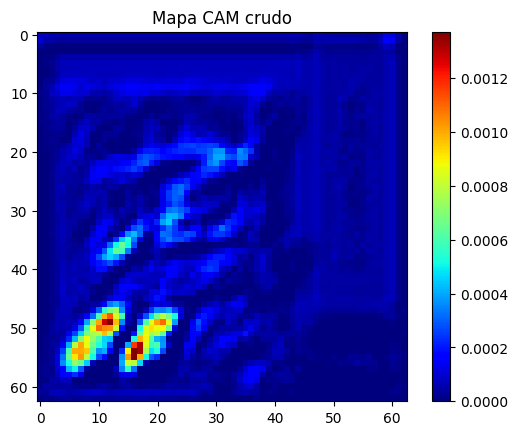

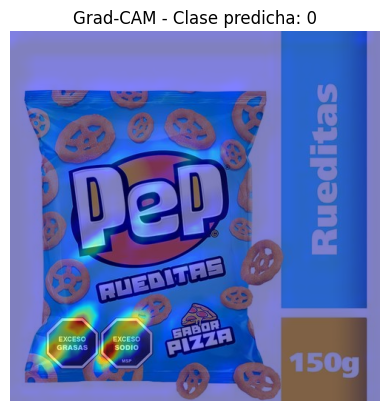

In [67]:
ejemplo = next(iter(valid_loader))[0][7]  # primera imagen del primer batch
state_dict = torch.load('modelo_final_podado_.pth', map_location=device)
model_instance = ResNet18_4(3, 2).to(device)
model_instance.load_state_dict(state_dict)
aplicar_gradcam(model_instance, ejemplo)